# **PROYECTO: Autoencoders Determinísticos**

Hecha por: Adriana García, Sara Marianova y Sara Suárez

Asignatura: Redes de Neuronas

Fecha: 3 de Noviembre de 2025

Máster de Inteligencia Artificial Aplicada


---



Los **autoencoders** son una técnica de aprendizaje no supervisado cuyo objetivo es copiar el input en el output.

Funcionan comprimiendo la entrada en una representación del espacio latente, tambien conocido como cuello de botella, y luego recostruyendo la salida a partir de esta representación. Este algoritmo se puede definir como **un algoritmo de extracción de imagenes**

Los datos de entrada pueden ser voz, texto, imagen o vídeo. En el caso de la práctica que se va a realizar, se utilizaran **imagenes** como inputs.

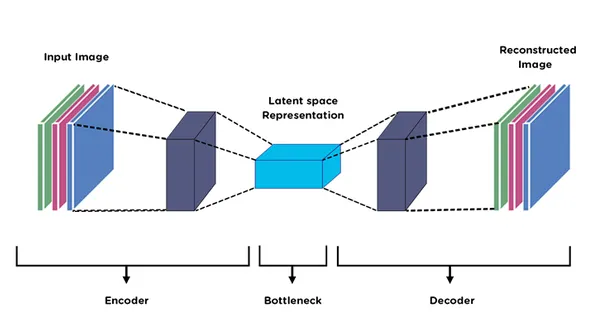

## **1. Librerias**

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from math import log10
import numpy as np
import matplotlib.pyplot as plt

## **2. Uso de la GPU**

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")          # GPUs NVIDIA (raro en Mac)
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")           # Apple Silicon (Metal)
else:
    device = torch.device("cpu")

print(f"Usando dispositivo: {device}")


Usando dispositivo: mps


## **3. Cargar los datasets (MNIST y Fashion-MNIST)**

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNIST (train y test)
train_mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_mnist = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# Loader MNIST
train_loader_mnist = DataLoader(train_mnist, batch_size=128, shuffle=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=128, shuffle=False)

# Fashion-MNIST (train y test)
train_fmnist = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_fmnist = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
# Loader Fashion-MNIST
train_loader_fmnist = DataLoader(train_fmnist, batch_size=128, shuffle=True)
test_loader_fmnist = DataLoader(test_fmnist, batch_size=128, shuffle=False)

## **4. Implementación de diferentes redes**

### 4.1. Convolutional Autoencoder

Creación de métrica **PSNR = Peak Signal-to-Noise Ratio**.
Medida de calidad de reconstrucción de imágenes:

*   PSNR alto -> imagen reconstruida muy parecida a la original
*   PSNR bajo -> imagen reconstruida muy diferente

In [4]:
def psnr(recon, target):
    mse = torch.mean((recon - target) ** 2)
    if mse == 0:
        return torch.tensor(100.0)
    return 10 * torch.log10(1 / mse)

Creación de la función para la reconstrucción hecha por el autoencoder

In [5]:
def show_reconstructions(model, dataloader, device, n=5):
    model.eval()
    imgs, _ = next(iter(dataloader))  # tomar un batch de test
    imgs = imgs.to(device)

    with torch.no_grad():
        recon, _ = model(imgs)

    imgs = imgs.cpu()
    recon = recon.cpu()

    plt.figure(figsize=(12,4))
    for i in range(n):
        # Imagen original
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i][0], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Imagen reconstruida
        plt.subplot(2, n, i+1+n)
        plt.imshow(recon[i][0], cmap='gray')
        plt.title("Recon")
        plt.axis('off')
    plt.show()

In [6]:
@torch.no_grad()
def show_reconstructions_mlp(model, data_loader, n=8, device='cpu', title="Reconstrucciones MLP-AE"):
    model.eval()
    x, _ = next(iter(data_loader))
    x = x[:n].to(device)
    recon, _ = model(x)
    x = x.cpu(); recon = recon.cpu()

    plt.figure(figsize=(12,3))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(x[i,0], cmap='gray'); plt.axis('off')
        if i == 0: plt.ylabel("Original")
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i,0], cmap='gray'); plt.axis('off')
        if i == 0: plt.ylabel("Reconstruida")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [7]:
import time, random, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt

# Reproducibilidad
random.seed(42); np.random.seed(42); torch.manual_seed(42)

@torch.no_grad()
def evaluate_on_loader(model, data_loader, device):
    model.eval()
    vals = []
    for x, _ in data_loader:
        x = x.to(device)
        recon, _ = model(x)
        vals.append(psnr(recon, x).item())
    return float(np.mean(vals))

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



### Arquitectura 1

*   Arquitectura con **3 capas** en encoder/decoder.
*   Probar distintas dimensiones latentes: **15, 30, 50, 100**.
*   Añadir regularización:
      
    **Dropout** en capas intermedias.

    **Penalización L1** del embedding.

*  Evaluación de la calidad de **reconstrucción con PSNR**.



Creación del Autoencoder Convolucional con 3 capas

In [8]:
import torch
import torch.nn as nn

class ConvAutoencoder_3L(nn.Module):
    def __init__(self, latent_dim=30, dropout_p=0.2):
        super().__init__()
        self.latent_dim = latent_dim

        # ----- Encoder (28 -> 14 -> 7 -> 4) -----
        modules = []
        in_ch = 1
        channels = [16, 32, 64]
        for ch in channels:
            modules += [
                nn.Conv2d(in_ch, ch, kernel_size=3, stride=2, padding=1),  # downsample
                nn.BatchNorm2d(ch),
                nn.ReLU(),
                nn.Dropout(dropout_p)
            ]
            in_ch = ch
        self.encoder = nn.Sequential(*modules)

        # Aplanar salida
        self.flatten = nn.Flatten()

        # Dimensión plana tras el encoder
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            out = self.encoder(dummy)                # esperado: (1, 64, 4, 4)
            self.shape_before_fc = out.shape[1:]     # (C, H, W) = (64, 4, 4)
            self.flat_dim = out.numel()              # 64*4*4 = 1024

        # Latente
        self.fc_enc = nn.Linear(self.flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.flat_dim)

        # ----- Decoder (4 -> 7 -> 14 -> 28) -----
        decoder_layers = []
        in_ch = channels[-1]  # 64

        # 4 -> 7  (k=3, s=2, p=1, out_pad=0)
        decoder_layers += [
            nn.ConvTranspose2d(in_ch, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ]
        in_ch = 64

        # 7 -> 14 (k=4, s=2, p=1, out_pad=0)
        decoder_layers += [
            nn.ConvTranspose2d(in_ch, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ]
        in_ch = 32

        # 14 -> 28 (k=4, s=2, p=1, out_pad=0)
        decoder_layers += [
            nn.ConvTranspose2d(in_ch, 16, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ]
        in_ch = 16

        # Salida 28x28, 1 canal
        decoder_layers += [
            nn.Conv2d(in_ch, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        ]
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        z = self.fc_enc(x)
        x = self.fc_dec(z)
        x = x.view(x.size(0), *self.shape_before_fc)  # (B,64,4,4)
        x = self.decoder(x)                           # -> (B,1,28,28)
        return x, z

# ==== Prueba rápida de forma ====
with torch.no_grad():
    m = ConvAutoencoder_3L(latent_dim=30, dropout_p=0.2)
    y, z = m(torch.zeros(1, 1, 28, 28))
    print("Salida:", y.shape, "| Latente:", z.shape)  # Esperado: torch.Size([1, 1, 28, 28]) / torch.Size([1, 30])


Salida: torch.Size([1, 1, 28, 28]) | Latente: torch.Size([1, 30])


Función de entrenamiento del modelo con regularización L1 y medir la calidad de PSNR

In [9]:
def train_autoencoder_3L(model, train_loader, val_loader, epochs, lr, lambda_l1, device=device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            recon, latent = model(imgs)

            mse_loss = criterion(recon, imgs)
            l1_loss = lambda_l1 * torch.mean(torch.abs(latent))
            loss = mse_loss + l1_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validación con PSNR
        model.eval()
        with torch.no_grad():
            psnr_scores = []
            for imgs, _ in val_loader:
                imgs = imgs.to(device)
                recon, _ = model(imgs)
                psnr_scores.append(psnr(recon, imgs).item())
        mean_psnr = np.mean(psnr_scores)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(train_loader):.5f} | PSNR: {mean_psnr:.2f}")

### Arquitectura 2
*   Arquitectura con **5 capas** en encoder/decoder.
*   Probar distintas dimensiones latentes: **15, 30, 50, 100**.
*   Añadir regularización:
      
    **Dropout** en capas intermedias.

    **Penalización L1** del embedding.

*  Evaluación de la calidad de **reconstrucción con PSNR**.

Creación del Autoencoder Convolucional con 5 capas

In [10]:
import torch
import torch.nn as nn

class ConvAutoencoder_5L(nn.Module):
    def __init__(self, latent_dim=30, dropout_p=0.2):
        super().__init__()
        self.latent_dim = latent_dim

        # ----- Encoder (28 -> 14 -> 7 -> 4 -> 4) -----
        # strides: [2, 2, 2, 1, 1]
        enc_layers = []
        in_ch = 1
        channels = [16, 32, 64, 128, 256]
        for i, ch in enumerate(channels):
            stride = 2 if i < 3 else 1
            enc_layers += [
                nn.Conv2d(in_ch, ch, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(ch),
                nn.ReLU(),
                nn.Dropout(dropout_p)
            ]
            in_ch = ch
        self.encoder = nn.Sequential(*enc_layers)

        # Dimensión plana tras el encoder
        self.flatten = nn.Flatten()
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            out = self.encoder(dummy)              # esperado: (1, 256, 4, 4)
            self.shape_before_fc = out.shape[1:]   # (256, 4, 4)
            self.flat_dim = out.numel()            # 256*4*4 = 4096

        # Latente
        self.fc_enc = nn.Linear(self.flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.flat_dim)

        # ----- Decoder (4 -> 4 -> 4 -> 7 -> 14 -> 28) -----
        # Inversa de las dos capas stride=1 del encoder, luego 3 upsamplings
        dec_layers = []
        in_ch = channels[-1]  # 256

        # 4x4 (stride=1) : 256 -> 128 (mantiene 4x4)
        dec_layers += [
            nn.ConvTranspose2d(in_ch, 128, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.BatchNorm2d(128), nn.ReLU()
        ]
        in_ch = 128

        # 4x4 (stride=1) : 128 -> 64 (mantiene 4x4)
        dec_layers += [
            nn.ConvTranspose2d(in_ch, 64, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.BatchNorm2d(64), nn.ReLU()
        ]
        in_ch = 64

        # 4 -> 7  (k=3, s=2, p=1, out_pad=0)
        dec_layers += [
            nn.ConvTranspose2d(in_ch, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64), nn.ReLU()
        ]
        in_ch = 64

        # 7 -> 14 (k=4, s=2, p=1, out_pad=0)
        dec_layers += [
            nn.ConvTranspose2d(in_ch, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32), nn.ReLU()
        ]
        in_ch = 32

        # 14 -> 28 (k=4, s=2, p=1, out_pad=0)
        dec_layers += [
            nn.ConvTranspose2d(in_ch, 16, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(16), nn.ReLU()
        ]
        in_ch = 16

        # Salida 28x28, 1 canal
        dec_layers += [
            nn.Conv2d(in_ch, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        ]

        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        z = self.fc_enc(x)
        x = self.fc_dec(z)
        x = x.view(x.size(0), *self.shape_before_fc)  # (B,256,4,4)
        x = self.decoder(x)                           # -> (B,1,28,28)
        return x, z

# ==== Prueba rápida de forma ====
with torch.no_grad():
    m = ConvAutoencoder_5L(latent_dim=30, dropout_p=0.2)
    y, z = m(torch.zeros(1, 1, 28, 28))
    print("Salida:", y.shape, "| Latente:", z.shape)  # Esperado: [1,1,28,28] y [1,30]


Salida: torch.Size([1, 1, 28, 28]) | Latente: torch.Size([1, 30])


Función de entrenamiento del modelo con regularización L1 y medir la calidad de PSNR

In [11]:
def train_autoencoder_5L(model, train_loader, val_loader, epochs, lr, lambda_l1, device=device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            recon, latent = model(imgs)

            mse_loss = criterion(recon, imgs)
            l1_loss = lambda_l1 * torch.mean(torch.abs(latent))
            loss = mse_loss + l1_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validación con PSNR
        model.eval()
        with torch.no_grad():
            psnr_scores = []
            for imgs, _ in val_loader:
                imgs = imgs.to(device)
                recon, _ = model(imgs)
                psnr_scores.append(psnr(recon, imgs).item())
        mean_psnr = np.mean(psnr_scores)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(train_loader):.5f} | PSNR: {mean_psnr:.2f}")

### **MNIST**

Entrenamiento con Autoencoder de 3 capas de encoder/decoder

In [12]:
from itertools import product
import time
import pandas as pd

# === Define tu grid aquí ===
latent_grid   = [15, 30, 50, 100, 300, 600]
lr_grid       = [1e-3, 1e-4]
lambda_grid   = [0.0, 1e-4, 1e-3]
dropout_grid  = [0.0, 0.1, 0.3]
epochs_grid   = [30]

results_3L = []
best_3L = {"psnr_val": -1.0, "state_dict": None, "cfg": None}

combo_total = len(latent_grid) * len(lr_grid) * len(lambda_grid) * len(dropout_grid) * len(epochs_grid)
print(f"Total combinaciones: {combo_total}")

i = 0
for latent_dim, lr, lambda_l1, dropout_p, epochs in product(latent_grid, lr_grid, lambda_grid, dropout_grid, epochs_grid):
    i += 1
    print(f"\n[{i}/{combo_total}] 3L | latent={latent_dim} | lr={lr} | λL1={lambda_l1} | dropout={dropout_p} | epochs={epochs}")

    model = ConvAutoencoder_3L(latent_dim=latent_dim, dropout_p=dropout_p)

    t0 = time.time()
    train_autoencoder_3L(
        model,
        train_loader=train_loader_mnist,
        val_loader=test_loader_mnist,
        epochs=epochs,
        lr=lr,
        lambda_l1=lambda_l1,
        device=device
    )
    train_time = time.time() - t0

    psnr_val = evaluate_on_loader(model, test_loader_mnist, device=device)

    res = {
        "arch": "3L",
        "latent": latent_dim,
        "lr": lr,
        "lambda_l1": lambda_l1,
        "dropout": dropout_p,
        "epochs": epochs,
        "psnr_val": psnr_val,
        "params": count_params(model),
        "train_time_s": round(train_time, 2),
    }
    results_3L.append(res)

    if psnr_val > best_3L["psnr_val"]:
        best_3L["psnr_val"] = psnr_val
        best_3L["state_dict"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_3L["cfg"] = res.copy()
        print(f"  ✔️ Nuevo mejor PSNR (3L): {psnr_val:.2f} dB")

df_grid_3L = pd.DataFrame(results_3L).sort_values("psnr_val", ascending=False).reset_index(drop=True)
display(df_grid_3L.head(10))

print("\nMejor configuración 3L:")
print(best_3L["cfg"])

# === CREA EL MODELO 'BEST' DE 3L ===
best_model_3L = ConvAutoencoder_3L(
    latent_dim=best_3L["cfg"]["latent"],
    dropout_p=best_3L["cfg"]["dropout"]
).to(device); best_model_3L.load_state_dict(best_3L["state_dict"])


Total combinaciones: 108

[1/108] 3L | latent=15 | lr=0.001 | λL1=0.0 | dropout=0.0 | epochs=30
Epoch [1/30] | Loss: 0.04092 | PSNR: 19.13
Epoch [2/30] | Loss: 0.01120 | PSNR: 20.04
Epoch [3/30] | Loss: 0.00970 | PSNR: 20.49
Epoch [4/30] | Loss: 0.00897 | PSNR: 20.73
Epoch [5/30] | Loss: 0.00855 | PSNR: 20.65
Epoch [6/30] | Loss: 0.00822 | PSNR: 20.97
Epoch [7/30] | Loss: 0.00801 | PSNR: 20.92
Epoch [8/30] | Loss: 0.00778 | PSNR: 21.19
Epoch [9/30] | Loss: 0.00764 | PSNR: 21.17
Epoch [10/30] | Loss: 0.00751 | PSNR: 21.16
Epoch [11/30] | Loss: 0.00739 | PSNR: 21.34
Epoch [12/30] | Loss: 0.00730 | PSNR: 21.38
Epoch [13/30] | Loss: 0.00721 | PSNR: 21.45
Epoch [14/30] | Loss: 0.00712 | PSNR: 21.46
Epoch [15/30] | Loss: 0.00705 | PSNR: 21.54
Epoch [16/30] | Loss: 0.00697 | PSNR: 21.49
Epoch [17/30] | Loss: 0.00695 | PSNR: 21.53
Epoch [18/30] | Loss: 0.00687 | PSNR: 21.53
Epoch [19/30] | Loss: 0.00682 | PSNR: 21.57
Epoch [20/30] | Loss: 0.00679 | PSNR: 21.63
Epoch [21/30] | Loss: 0.00672 | P

arch  latent      lr  lambda_l1  dropout  epochs   psnr_val   params  \
0   3L     600  0.0010     0.0010      0.0      30  31.974330  1332249   
1   3L     600  0.0010     0.0000      0.0      30  31.943235  1332249   
2   3L     600  0.0010     0.0001      0.0      30  31.779604  1332249   
3   3L     300  0.0010     0.0001      0.0      30  31.682591   717549   
4   3L     300  0.0010     0.0010      0.0      30  31.656403   717549   
5   3L     300  0.0010     0.0000      0.0      30  31.598030   717549   
6   3L     600  0.0001     0.0000      0.0      30  30.515779  1332249   
7   3L     600  0.0001     0.0010      0.0      30  30.415656  1332249   
8   3L     600  0.0001     0.0001      0.0      30  30.247931  1332249   
9   3L     100  0.0010     0.0001      0.0      30  29.924348   307749   

   train_time_s  
0        248.99  
1        249.38  
2        249.97  
3        220.89  
4        224.51  
5        222.32  
6        253.35  
7        250.62  
8        246.92  
9        210.45


Mejor configuración 3L:
{'arch': '3L', 'latent': 600, 'lr': 0.001, 'lambda_l1': 0.001, 'dropout': 0.0, 'epochs': 30, 'psnr_val': 31.974329936353467, 'params': 1332249, 'train_time_s': 248.99}


<All keys matched successfully>

In [13]:
best_model_3L = ConvAutoencoder_3L(latent_dim=best_3L["cfg"]["latent"], dropout_p=best_3L["cfg"]["dropout"]).to(device)
best_model_3L.load_state_dict(best_3L["state_dict"])

<All keys matched successfully>

In [97]:
df_grid_3L.to_csv("grid_mnist_3L_results.csv", index=False)
print("Guardado: grid_mnist_3L_results.csv")

Guardado: grid_mnist_3L_results.csv


In [99]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_grid_3L)


arch  latent      lr  lambda_l1  dropout  epochs   psnr_val   params  \
0     3L     600  0.0010     0.0010      0.0      30  31.974330  1332249   
1     3L     600  0.0010     0.0000      0.0      30  31.943235  1332249   
2     3L     600  0.0010     0.0001      0.0      30  31.779604  1332249   
3     3L     300  0.0010     0.0001      0.0      30  31.682591   717549   
4     3L     300  0.0010     0.0010      0.0      30  31.656403   717549   
5     3L     300  0.0010     0.0000      0.0      30  31.598030   717549   
6     3L     600  0.0001     0.0000      0.0      30  30.515779  1332249   
7     3L     600  0.0001     0.0010      0.0      30  30.415656  1332249   
8     3L     600  0.0001     0.0001      0.0      30  30.247931  1332249   
9     3L     100  0.0010     0.0001      0.0      30  29.924348   307749   
10    3L     100  0.0010     0.0010      0.0      30  29.718490   307749   
11    3L     100  0.0010     0.0000      0.0      30  29.707451   307749   
12    3L     300  0.0001     0.0000      0.0      30  29.678981   717549   
13    3L     300  0.0001     0.0001      0.0      30  29.673364   717549   
14    3L     300  0.0001     0.0010      0.0      30  29.328134   717549   
15    3L     100  0.0001     0.0010      0.0      30  28.040533   307749   
16    3L     300  0.0010     0.0001      0.1      30  27.941600   717549   
17    3L     600  0.0010     0.0010      0.1      30  27.914607  1332249   
18    3L     600  0.0010     0.0001      0.1      30  27.906273  1332249   
19    3L     100  0.0001     0.0000      0.0      30  27.878102   307749   
20    3L     300  0.0010     0.0000      0.1      30  27.797629   717549   
21    3L     100  0.0001     0.0001      0.0      30  27.788780   307749   
22    3L     600  0.0010     0.0000      0.1      30  27.637283  1332249   
23    3L     300  0.0010     0.0010      0.1      30  27.592532   717549   
24    3L     100  0.0010     0.0000      0.1      30  27.415717   307749   
25    3L     100  0.0010     0.0001      0.1      30  27.342493   307749   
26    3L      50  0.0010     0.0000      0.0      30  27.327006   205299   
27    3L      50  0.0010     0.0001      0.0      30  27.288455   205299   
28    3L     600  0.0001     0.0000      0.1      30  27.239875  1332249   
29    3L     100  0.0010     0.0010      0.1      30  27.232006   307749   
30    3L     600  0.0001     0.0001      0.1      30  27.193900  1332249   
31    3L      50  0.0010     0.0010      0.0      30  27.193385   205299   
32    3L     600  0.0001     0.0010      0.1      30  27.187027  1332249   
33    3L     300  0.0001     0.0000      0.1      30  26.908923   717549   
34    3L     300  0.0001     0.0001      0.1      30  26.882144   717549   
35    3L     300  0.0001     0.0010      0.1      30  26.842092   717549   
36    3L     100  0.0001     0.0001      0.1      30  26.239256   307749   
37    3L     100  0.0001     0.0000      0.1      30  26.189731   307749   
38    3L     100  0.0001     0.0010      0.1      30  26.151199   307749   
39    3L      50  0.0001     0.0010      0.0      30  25.994196   205299   
40    3L      50  0.0001     0.0000      0.0      30  25.920831   205299   
41    3L      50  0.0001     0.0001      0.0      30  25.903060   205299   
42    3L      50  0.0010     0.0000      0.1      30  25.870087   205299   
43    3L      50  0.0010     0.0001      0.1      30  25.816714   205299   
44    3L      50  0.0010     0.0010      0.1      30  25.695542   205299   
45    3L      50  0.0001     0.0010      0.1      30  25.198393   205299   
46    3L     300  0.0010     0.0000      0.3      30  25.176583   717549   
47    3L     600  0.0010     0.0001      0.3      30  25.144169  1332249   
48    3L     300  0.0010     0.0010      0.3      30  25.129988   717549   
49    3L     600  0.0010     0.0000      0.3      30  25.128372  1332249   
50    3L      50  0.0001     0.0001      0.1      30  25.122385   205299   
51    3L     600  0.0010     0.0010      0.3      30

GridSearch en MNIST con 3 capas
===================================

**Mejor combinación:** `latent=600`, `LR=1e-3`, `dropout=0` y `L1=1e-3`.\
Con esta configuración se alcanzó un PSNR de **31,97 dB**.\
El mismo ajuste sin L1 ofreció un valor muy similar de **31,94 dB**.

Efecto de cada hiperparámetro
-----------------------------

Dimensión latente

-   La tendencia es clara: **600 supera a 300, 300 supera a 100 y así sucesivamente hasta 15**.

-   Con `latent=600` el PSNR se sitúa aproximadamente entre **31,5 y 32,0 dB**.

-   Con `latent=300` el PSNR cae ligeramente y se sitúa entre **31,3 y 31,7 dB**.

-   Con `latent=100` el modelo baja hasta valores entre **29,7 y 29,9 dB**.

-   Con `latent=50` el PSNR se mantiene alrededor de **27,2 y 27,3 dB**.

-   Con `latent=30` se observan valores entre **24,0 y 25,0 dB**.

-   Con `latent=15` el rendimiento desciende hasta **20,0 y 22,0 dB**.

-   Esto ocurre porque una latente pequeña obliga a comprimir demasiado la información y se pierden detalles, mientras que una latente grande conserva mejor la estructura de la imagen.

Learning rate

-   A igualdad de condiciones, **`LR=1e-3`** ofrece **entre uno y dos decibelios más** que **`LR=1e-4`**.

-   Con treinta épocas de entrenamiento, un learning rate más alto permite avanzar de manera suficiente por el paisaje de pérdida y alcanzar mejores mínimos.

-   Un learning rate demasiado bajo deja el modelo sin tiempo efectivo para converger y el PSNR se resiente.

Regularización L1

-   La L1 aporta **una mejora pequeña** cuando el modelo ya converge bien, por ejemplo con latente grande y `LR=1e-3`.

-   En esos casos ayuda a estabilizar el código latente y evita valores extremos, aunque la ganancia es moderada.

-   Con `LR=1e-4` la L1 **tiende a perjudicar** porque añade restricción adicional cuando ya falta avance de optimización, y el modelo termina en soluciones de peor calidad.

Dropout

-   El **dropout degrada de forma consistente** la reconstrucción.

-   Con un valor de **0,1** el PSNR suele caer entre **tres y cuatro decibelios** respecto al mejor caso.

-   Con un valor de **0,3** la caída es más severa y ronda **entre seis y ocho decibelios**.

-   En una tarea de reconstrucción determinista, apagar unidades introduce ruido y reduce la capacidad efectiva del modelo, por lo que se pierden señales débiles y detalles finos.

Interacciones relevantes
------------------------

-   La combinación de **latente grande** y **`LR=1e-3`** es el punto óptimo observado en este experimento.

-   Un **learning rate bajo** junto con **L1** acumula restricciones y reduce el PSNR.

-   El **dropout** intensifica cualquier limitación, ya sea por falta de capacidad en la latente o por falta de convergencia debida a un learning rate insuficiente.

Entrenamiento con Autoencoder de 5 capas encoder/decoder

In [15]:
from itertools import product
import time
import pandas as pd

# === Define tu grid aquí (5L) ===
latent_grid   = [15, 30, 50, 100, 300, 600]
lr_grid       = [1e-3, 1e-4]
lambda_grid   = [0.0, 1e-4, 1e-3]
dropout_grid  = [0.0, 0.1, 0.3]
epochs_grid   = [40]

results_5L = []
best_5L = {"psnr_val": -1.0, "state_dict": None, "cfg": None}

combo_total = len(latent_grid) * len(lr_grid) * len(lambda_grid) * len(dropout_grid) * len(epochs_grid)
print(f"Total combinaciones (5L): {combo_total}")

i = 0
for latent_dim, lr, lambda_l1, dropout_p, epochs in product(latent_grid, lr_grid, lambda_grid, dropout_grid, epochs_grid):
    i += 1
    print(f"\n[{i}/{combo_total}] 5L | latent={latent_dim} | lr={lr} | λL1={lambda_l1} | dropout={dropout_p} | epochs={epochs}")

    # Instancia el modelo 5L (asegúrate de usar la versión que devuelve 28x28 exacto)
    model_5L = ConvAutoencoder_5L(latent_dim=latent_dim, dropout_p=dropout_p)

    # Entrena
    t0 = time.time()
    train_autoencoder_5L(
        model_5L,
        train_loader=train_loader_mnist,   # cambia a *_fmnist si quieres grid en FMNIST
        val_loader=test_loader_mnist,      # validación rápida
        epochs=epochs,
        lr=lr,
        lambda_l1=lambda_l1,
        device=device
    )
    train_time = time.time() - t0

    # Eval PSNR validación
    psnr_val = evaluate_on_loader(model_5L, test_loader_mnist, device=device)

    # Guarda resultados
    res = {
        "arch": "5L",
        "latent": latent_dim,
        "lr": lr,
        "lambda_l1": lambda_l1,
        "dropout": dropout_p,
        "epochs": epochs,
        "psnr_val": psnr_val,
        "params": count_params(model_5L),
        "train_time_s": round(train_time, 2),
    }
    results_5L.append(res)

    # Track mejor
    if psnr_val > best_5L["psnr_val"]:
        best_5L["psnr_val"] = psnr_val
        best_5L["state_dict"] = {k: v.detach().cpu().clone() for k, v in model_5L.state_dict().items()}
        best_5L["cfg"] = res.copy()
        print(f"  ✔️ Nuevo mejor PSNR (5L): {psnr_val:.2f} dB — cfg={res}")

# Tabla ordenada y guardado
df_grid_5L = pd.DataFrame(results_5L).sort_values("psnr_val", ascending=False).reset_index(drop=True)
display(df_grid_5L.head(10))
df_grid_5L.to_csv("grid_mnist_5L_results.csv", index=False)
print("Guardado: grid_mnist_5L_results.csv")

print("\nMejor configuración 5L:")
print(best_5L["cfg"])


Total combinaciones (5L): 108

[1/108] 5L | latent=15 | lr=0.001 | λL1=0.0 | dropout=0.0 | epochs=40
Epoch [1/40] | Loss: 0.03071 | PSNR: 19.31
Epoch [2/40] | Loss: 0.01020 | PSNR: 20.56
Epoch [3/40] | Loss: 0.00872 | PSNR: 20.85
Epoch [4/40] | Loss: 0.00799 | PSNR: 21.00
Epoch [5/40] | Loss: 0.00752 | PSNR: 21.37
Epoch [6/40] | Loss: 0.00715 | PSNR: 21.63
Epoch [7/40] | Loss: 0.00681 | PSNR: 21.68
Epoch [8/40] | Loss: 0.00672 | PSNR: 21.74
Epoch [9/40] | Loss: 0.00652 | PSNR: 21.67
Epoch [10/40] | Loss: 0.00633 | PSNR: 21.70
Epoch [11/40] | Loss: 0.00621 | PSNR: 21.53
Epoch [12/40] | Loss: 0.00611 | PSNR: 21.97
Epoch [13/40] | Loss: 0.00600 | PSNR: 21.98
Epoch [14/40] | Loss: 0.00590 | PSNR: 22.01
Epoch [15/40] | Loss: 0.00585 | PSNR: 21.99
Epoch [16/40] | Loss: 0.00574 | PSNR: 22.17
Epoch [17/40] | Loss: 0.00565 | PSNR: 22.07
Epoch [18/40] | Loss: 0.00558 | PSNR: 22.12
Epoch [19/40] | Loss: 0.00553 | PSNR: 22.32
Epoch [20/40] | Loss: 0.00546 | PSNR: 22.29
Epoch [21/40] | Loss: 0.0054

arch  latent      lr  lambda_l1  dropout  epochs   psnr_val   params  \
0   5L     600  0.0001     0.0010      0.0      40  28.748702  5760729   
1   5L     600  0.0001     0.0001      0.0      40  28.613904  5760729   
2   5L     600  0.0001     0.0000      0.0      40  28.574271  5760729   
3   5L     300  0.0001     0.0000      0.0      40  28.500461  3302829   
4   5L     300  0.0001     0.0010      0.0      40  28.250566  3302829   
5   5L     300  0.0010     0.0001      0.0      40  28.168905  3302829   
6   5L     100  0.0010     0.0010      0.0      40  28.146551  1664229   
7   5L     300  0.0010     0.0010      0.0      40  28.144029  3302829   
8   5L     600  0.0010     0.0010      0.0      40  28.136459  5760729   
9   5L     300  0.0001     0.0001      0.0      40  28.020066  3302829   

   train_time_s  
0        268.38  
1        268.68  
2        268.92  
3        247.29  
4        246.84  
5        247.02  
6        382.08  
7        247.24  
8        360.19  
9        247.20

Guardado: grid_mnist_5L_results.csv

Mejor configuración 5L:
{'arch': '5L', 'latent': 600, 'lr': 0.0001, 'lambda_l1': 0.001, 'dropout': 0.0, 'epochs': 40, 'psnr_val': 28.74870179574701, 'params': 5760729, 'train_time_s': 268.38}


In [16]:
best_model_5L = ConvAutoencoder_5L(latent_dim=best_5L["cfg"]["latent"], dropout_p=best_5L["cfg"]["dropout"]).to(device)
best_model_5L.load_state_dict(best_5L["state_dict"])

<All keys matched successfully>

In [100]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_grid_5L)

arch  latent      lr  lambda_l1  dropout  epochs   psnr_val   params  \
0     5L     600  0.0001     0.0010      0.0      40  28.748702  5760729   
1     5L     600  0.0001     0.0001      0.0      40  28.613904  5760729   
2     5L     600  0.0001     0.0000      0.0      40  28.574271  5760729   
3     5L     300  0.0001     0.0000      0.0      40  28.500461  3302829   
4     5L     300  0.0001     0.0010      0.0      40  28.250566  3302829   
5     5L     300  0.0010     0.0001      0.0      40  28.168905  3302829   
6     5L     100  0.0010     0.0010      0.0      40  28.146551  1664229   
7     5L     300  0.0010     0.0010      0.0      40  28.144029  3302829   
8     5L     600  0.0010     0.0010      0.0      40  28.136459  5760729   
9     5L     300  0.0001     0.0001      0.0      40  28.020066  3302829   
10    5L     100  0.0001     0.0000      0.0      40  27.849801  1664229   
11    5L     300  0.0010     0.0000      0.0      40  27.815876  3302829   
12    5L     100  0.0001     0.0001      0.0      40  27.788815  1664229   
13    5L     600  0.0010     0.0001      0.0      40  27.753749  5760729   
14    5L     100  0.0010     0.0000      0.0      40  27.651414  1664229   
15    5L     100  0.0010     0.0001      0.0      40  27.580803  1664229   
16    5L     600  0.0010     0.0000      0.0      40  27.550700  5760729   
17    5L     100  0.0001     0.0010      0.0      40  27.231485  1664229   
18    5L      50  0.0010     0.0001      0.0      40  27.177646  1254579   
19    5L      50  0.0010     0.0000      0.0      40  26.956000  1254579   
20    5L      50  0.0010     0.0010      0.0      40  26.869590  1254579   
21    5L      50  0.0001     0.0000      0.0      40  26.227534  1254579   
22    5L     300  0.0001     0.0001      0.1      40  25.953467  3302829   
23    5L     300  0.0010     0.0001      0.1      40  25.950084  3302829   
24    5L     600  0.0001     0.0001      0.1      40  25.905811  5760729   
25    5L     600  0.0001     0.0000      0.1      40  25.886457  5760729   
26    5L     300  0.0010     0.0010      0.1      40  25.881672  3302829   
27    5L     600  0.0010     0.0001      0.1      40  25.840547  5760729   
28    5L     300  0.0001     0.0000      0.1      40  25.837657  3302829   
29    5L     600  0.0001     0.0010      0.1      40  25.832985  5760729   
30    5L     300  0.0010     0.0000      0.1      40  25.812978  3302829   
31    5L     100  0.0010     0.0010      0.1      40  25.767206  1664229   
32    5L     600  0.0010     0.0010      0.1      40  25.756857  5760729   
33    5L     100  0.0010     0.0001      0.1      40  25.740046  1664229   
34    5L      50  0.0001     0.0001      0.0      40  25.688877  1254579   
35    5L     600  0.0010     0.0000      0.1      40  25.681841  5760729   
36    5L     100  0.0001     0.0000      0.1      40  25.672818  1664229   
37    5L      30  0.0010     0.0000      0.0      40  25.570575  1090719   
38    5L     100  0.0001     0.0001      0.1      40  25.522507  1664229   
39    5L     100  0.0010     0.0000      0.1      40  25.510616  1664229   
40    5L     100  0.0001     0.0010      0.1      40  25.472842  1664229   
41    5L     300  0.0001     0.0010      0.1      40  25.463617  3302829   
42    5L      50  0.0010     0.0000      0.1      40  25.384777  1254579   
43    5L      30  0.0010     0.0001      0.0      40  25.349048  1090719   
44    5L      50  0.0010     0.0001      0.1      40  25.332634  1254579   
45    5L      30  0.0010     0.0010      0.0      40  25.224528  1090719   
46    5L      50  0.0010     0.0010      0.1      40  25.120730  1254579   
47    5L      50  0.0001     0.0001      0.1      40  25.002955  1254579   
48    5L      50  0.0001     0.0000      0.1      40  24.992789  1254579   
49    5L      50  0.0001     0.0010      0.0      40  24.869656  1254579   
50    5L      50  0.0001     0.0010      0.1      40  24.801720  1254579   
51    5L      30  0.0001     0.0000      0.0      40

GridSearch en MNIST con 5 capas
===================================

**Mejor combinación:** `latent=600`, `LR=1e-4`, `dropout=0` y `L1=1e-3`.\
Con esta configuración se alcanzó un PSNR de **28,74 dB**. Los siguientes mejores valores, también sin dropout y con `LR=1e-4`, quedaron muy próximos: **28,61 dB** con `L1=1e-4` y **28,57 dB** sin L1.

Efecto de cada hiperparámetro
-----------------------------

### Dimensión latente

-   La relación capacidad--calidad es nítida: **600 > 300 > 100 > 50 > 30 > 15**.

-   Con `latent=600` el modelo preserva mejor la estructura y alcanza ~28,6--28,7 dB con `LR=1e-4` y sin dropout.

-   Reducir la latente a **300** baja el PSNR a ~28,0--28,5 dB; con **100** cae hasta ~27,6--28,1 dB; con **50** ronda ~26--27 dB; con **30** queda alrededor de ~24--25 dB; y con **15** desciende a ~22 dB.

-   La causa es la misma que en 3 capas: menos capacidad latente implica compresión más agresiva y pérdida de detalle, pero el efecto es más acusado al tener una red más profunda que tiende a suavizar.

### Learning rate

-   A diferencia del caso de 3 capas, aquí **`LR=1e-4` supera de forma consistente a `LR=1e-3`** con 40 épocas, especialmente en latentes grandes.

-   En redes más profundas, un paso más pequeño facilita una **optimización estable** y evita sobrepasar buenos mínimos; con `LR=1e-3` aparecen resultados 0,4--1,0 dB más bajos en varias combinaciones.

-   Conclusión práctica: para **5 capas y 40 épocas**, conviene **bajar el LR** para estabilizar el entrenamiento.

### Regularización L1

-   El impacto de L1 es **moderado**. En el mejor caso, `L1=1e-3` aporta una **ligera mejora** frente a `L1=0` y `L1=1e-4`.

-   En el resto de combinaciones, la L1 **no cambia sustancialmente** el PSNR y rara vez compensa ajustes subóptimos de LR o latente.

### Dropout

-   El **dropout perjudica de forma clara** la reconstrucción.

-   Con **0,1**, los resultados caen típicamente a **25--26 dB** incluso con latentes grandes y buenos LR.

-   Con **0,3**, la degradación es **severa** y sitúa el PSNR alrededor de **22--23 dB**.

-   En reconstrucción determinista, apagar unidades añade ruido y reduce capacidad efectiva, acentuando el suavizado propio de una red más profunda.

Interacciones relevantes
------------------------

-   **Latente grande + LR=1e-4 + sin dropout** define el punto óptimo en esta arquitectura.

-   **LR alto** combinado con **red profunda** produce convergencias menos estables y peores mínimos.

-   **Dropout** magnifica cualquier limitación existente, ya sea por **latente pequeña** o por **LR inadecuado**.

Comparativa: MNIST con 3 capas vs 5 capas
=========================================

**Mejores combinaciones:**

-   **3 capas:** `latent=600`, `LR=1e-3`, `dropout=0`, `L1=1e-3` → **PSNR = 31,97 dB**.

-   **5 capas:** `latent=600`, `LR=1e-4`, `dropout=0`, `L1=1e-3` → **PSNR = 28,74 dB**.

Diferencias globales de rendimiento
-----------------------------------

-   La red de **3 capas supera a la de 5 capas en ~3 dB** en el mejor caso.

-   La **5 capas tiende a "suavizar"** más las reconstrucciones: esto reduce ruido, pero también borra detalle fino y baja el PSNR.

-   Con **latentes pequeñas**, la caída es más pronunciada en 5 capas por la combinación de mayor profundidad y menor capacidad efectiva.

Efecto de cada hiperparámetro
-----------------------------

### Dimensión latente

-   **Tendencia común:** más latente → mejor PSNR en ambas.

-   **Sensibilidad:** la **5 capas** penaliza más las latentes pequeñas; pasa de ~28,7 dB (600) a ~24--22 dB (50--30).

-   **Interpretación:** la profundidad amplifica la compresión cuando el cuello de botella es estrecho; 3 capas preserva mejor contornos en latentes medias.

### Learning rate

-   **3 capas:** funciona mejor con **`LR=1e-3`** en 30 épocas porque necesita un paso mayor para converger.

-   **5 capas:** rinde mejor con **`LR=1e-4`** en 40 épocas; un paso menor estabiliza la optimización en redes más profundas.

-   **Conclusión:** a mayor profundidad, **bajar el LR** y **dar más épocas** mejora la estabilidad y el mínimo alcanzado.

### Regularización L1

-   **Impacto leve** en ambas arquitecturas.

-   **3 capas:** puede aportar una mejora pequeña cuando ya se ha alcanzado buena convergencia.

-   **5 capas:** efecto similar, con ganancias discretas; no compensa un LR o una latente mal elegidos.

### Dropout

-   **Perjudica en ambos casos**, pero el efecto es **más severo en 5 capas**.

-   Con **0,1** ya se observan caídas importantes; con **0,3** el PSNR desciende a rangos 22--23 dB en 5 capas.

-   **Motivo:** la reconstrucción es determinista; apagar unidades reduce capacidad y borra señales débiles, y la profundidad amplifica ese efecto.

Interacciones relevantes
------------------------

-   **3 capas:** el "punto dulce" es **latente grande + LR alto (1e-3) + sin dropout**.

-   **5 capas:** el equilibrio óptimo pasa por **latente grande + LR bajo (1e-4) + sin dropout**.

-   En ambas, **L1** solo refina cuando el entrenamiento ya es estable y bien configurado.

### **Fashion-MNIST**

Entrenamiento con Autoencoder de 3 capas de encoder/decoder

Total combinaciones FMNIST-3L: 108

[1/108] FMNIST 3L | latent=15 | lr=0.001 | λL1=0.0 | dropout=0.0 | epochs=30
Epoch [1/30] | Loss: 0.02134 | PSNR: 18.67
Epoch [2/30] | Loss: 0.01262 | PSNR: 19.29
Epoch [3/30] | Loss: 0.01150 | PSNR: 19.47
Epoch [4/30] | Loss: 0.01097 | PSNR: 19.63
Epoch [5/30] | Loss: 0.01062 | PSNR: 19.75
Epoch [6/30] | Loss: 0.01038 | PSNR: 19.89
Epoch [7/30] | Loss: 0.01020 | PSNR: 19.91
Epoch [8/30] | Loss: 0.01005 | PSNR: 19.90
Epoch [9/30] | Loss: 0.00988 | PSNR: 20.03
Epoch [10/30] | Loss: 0.00979 | PSNR: 20.07
Epoch [11/30] | Loss: 0.00971 | PSNR: 20.04
Epoch [12/30] | Loss: 0.00964 | PSNR: 20.07
Epoch [13/30] | Loss: 0.00955 | PSNR: 20.12
Epoch [14/30] | Loss: 0.00949 | PSNR: 20.12
Epoch [15/30] | Loss: 0.00942 | PSNR: 20.15
Epoch [16/30] | Loss: 0.00938 | PSNR: 20.18
Epoch [17/30] | Loss: 0.00934 | PSNR: 20.21
Epoch [18/30] | Loss: 0.00927 | PSNR: 20.25
Epoch [19/30] | Loss: 0.00924 | PSNR: 20.16
Epoch [20/30] | Loss: 0.00918 | PSNR: 20.24
Epoch [21/30] | 

arch dataset  latent      lr  lambda_l1  dropout  epochs   psnr_val  \
0   3L  FMNIST     600  0.0010     0.0001      0.0      30  28.570433   
1   3L  FMNIST     600  0.0010     0.0010      0.0      30  28.568711   
2   3L  FMNIST     600  0.0010     0.0000      0.0      30  28.395263   
3   3L  FMNIST     300  0.0010     0.0010      0.0      30  27.537476   
4   3L  FMNIST     300  0.0010     0.0000      0.0      30  27.446798   
5   3L  FMNIST     300  0.0010     0.0001      0.0      30  27.383011   
6   3L  FMNIST     600  0.0001     0.0001      0.0      30  26.207213   
7   3L  FMNIST     600  0.0001     0.0010      0.0      30  26.081954   
8   3L  FMNIST     600  0.0001     0.0000      0.0      30  25.877211   
9   3L  FMNIST     600  0.0010     0.0001      0.1      30  25.132361   

    params  train_time_s  
0  1332249        148.94  
1  1332249        149.42  
2  1332249        150.96  
3   717549        149.27  
4   717549        148.75  
5   717549        148.34  
6  1332249        148.92  
7  1332249        149.61  
8  1332249        150.18  
9  1332249        154.84

Guardado: grid_fmnist_3L_results.csv

Mejor configuración FMNIST-3L:
{'arch': '3L', 'dataset': 'FMNIST', 'latent': 600, 'lr': 0.001, 'lambda_l1': 0.0001, 'dropout': 0.0, 'epochs': 30, 'psnr_val': 28.570432662963867, 'params': 1332249, 'train_time_s': 148.94}


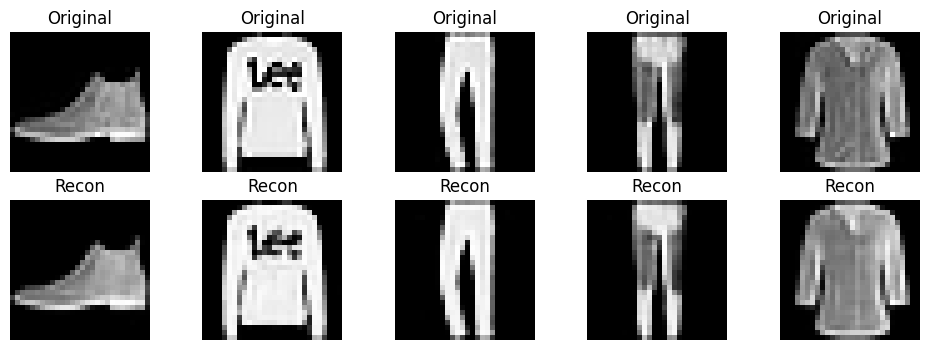

In [18]:
from itertools import product
import time
import pandas as pd

# === Grid para FMNIST (3L) ===
latent_grid   = [15, 30, 50, 100, 300, 600]
lr_grid       = [1e-3, 1e-4]
lambda_grid   = [0.0, 1e-4, 1e-3]
dropout_grid  = [0.0, 0.1, 0.3]
epochs_grid   = [30]   # ajusta si quieres (p.ej. 40)

results_fmnist_3L = []
best_fmnist_3L = {"psnr_val": -1.0, "state_dict": None, "cfg": None}

combo_total = len(latent_grid) * len(lr_grid) * len(lambda_grid) * len(dropout_grid) * len(epochs_grid)
print(f"Total combinaciones FMNIST-3L: {combo_total}")

i = 0
for latent_dim, lr, lambda_l1, dropout_p, epochs in product(latent_grid, lr_grid, lambda_grid, dropout_grid, epochs_grid):
    i += 1
    print(f"\n[{i}/{combo_total}] FMNIST 3L | latent={latent_dim} | lr={lr} | λL1={lambda_l1} | dropout={dropout_p} | epochs={epochs}")

    # Instancia modelo
    model_FMNIST_3L = ConvAutoencoder_3L(latent_dim=latent_dim, dropout_p=dropout_p)

    # Entrena
    t0 = time.time()
    train_autoencoder_3L(
        model=model_FMNIST_3L,
        train_loader=train_loader_fmnist,
        val_loader=test_loader_fmnist,   # validación rápida
        epochs=epochs,
        lr=lr,
        lambda_l1=lambda_l1,
        device=device
    )
    train_time = time.time() - t0

    # Eval PSNR validación
    psnr_val = evaluate_on_loader(model_FMNIST_3L, test_loader_fmnist, device=device)

    # Guarda resultados
    res = {
        "arch": "3L",
        "dataset": "FMNIST",
        "latent": latent_dim,
        "lr": lr,
        "lambda_l1": lambda_l1,
        "dropout": dropout_p,
        "epochs": epochs,
        "psnr_val": psnr_val,
        "params": count_params(model_FMNIST_3L),
        "train_time_s": round(train_time, 2),
    }
    results_fmnist_3L.append(res)

    # Track mejor
    if psnr_val > best_fmnist_3L["psnr_val"]:
        best_fmnist_3L["psnr_val"] = psnr_val
        best_fmnist_3L["state_dict"] = {k: v.detach().cpu().clone() for k, v in model_FMNIST_3L.state_dict().items()}
        best_fmnist_3L["cfg"] = res.copy()
        print(f"  ✔️ Nuevo mejor PSNR (FMNIST-3L): {psnr_val:.2f} dB — cfg={res}")

# Tabla ordenada y guardado
df_grid_fmnist_3L = pd.DataFrame(results_fmnist_3L).sort_values("psnr_val", ascending=False).reset_index(drop=True)
display(df_grid_fmnist_3L.head(10))
df_grid_fmnist_3L.to_csv("grid_fmnist_3L_results.csv", index=False)
print("Guardado: grid_fmnist_3L_results.csv")

print("\nMejor configuración FMNIST-3L:")
print(best_fmnist_3L["cfg"])

# === Crea el modelo 'best' de FMNIST-3L ===
best_model_fmnist_3L = ConvAutoencoder_3L(
    latent_dim=best_fmnist_3L["cfg"]["latent"],
    dropout_p=best_fmnist_3L["cfg"]["dropout"]
).to(device); best_model_fmnist_3L.load_state_dict(best_fmnist_3L["state_dict"])

# Visualiza algunas reconstrucciones con el mejor
show_reconstructions(best_model_fmnist_3L, test_loader_fmnist, device, n=5)


In [101]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_grid_fmnist_3L)

arch dataset  latent      lr  lambda_l1  dropout  epochs   psnr_val  \
0     3L  FMNIST     600  0.0010     0.0001      0.0      30  28.570433   
1     3L  FMNIST     600  0.0010     0.0010      0.0      30  28.568711   
2     3L  FMNIST     600  0.0010     0.0000      0.0      30  28.395263   
3     3L  FMNIST     300  0.0010     0.0010      0.0      30  27.537476   
4     3L  FMNIST     300  0.0010     0.0000      0.0      30  27.446798   
5     3L  FMNIST     300  0.0010     0.0001      0.0      30  27.383011   
6     3L  FMNIST     600  0.0001     0.0001      0.0      30  26.207213   
7     3L  FMNIST     600  0.0001     0.0010      0.0      30  26.081954   
8     3L  FMNIST     600  0.0001     0.0000      0.0      30  25.877211   
9     3L  FMNIST     600  0.0010     0.0001      0.1      30  25.132361   
10    3L  FMNIST     300  0.0001     0.0010      0.0      30  25.055440   
11    3L  FMNIST     300  0.0001     0.0001      0.0      30  25.024903   
12    3L  FMNIST     600  0.0010     0.0010      0.1      30  24.999101   
13    3L  FMNIST     600  0.0010     0.0000      0.1      30  24.957063   
14    3L  FMNIST     300  0.0001     0.0000      0.0      30  24.955741   
15    3L  FMNIST     300  0.0010     0.0000      0.1      30  24.830978   
16    3L  FMNIST     300  0.0010     0.0010      0.1      30  24.809316   
17    3L  FMNIST     300  0.0010     0.0001      0.1      30  24.787774   
18    3L  FMNIST     100  0.0010     0.0000      0.0      30  24.250896   
19    3L  FMNIST     100  0.0010     0.0001      0.0      30  24.168880   
20    3L  FMNIST     600  0.0001     0.0000      0.1      30  24.158514   
21    3L  FMNIST     600  0.0001     0.0001      0.1      30  24.133362   
22    3L  FMNIST     600  0.0001     0.0010      0.1      30  24.069378   
23    3L  FMNIST     100  0.0010     0.0010      0.0      30  24.064327   
24    3L  FMNIST     300  0.0001     0.0000      0.1      30  23.604058   
25    3L  FMNIST     300  0.0001     0.0010      0.1      30  23.582119   
26    3L  FMNIST     300  0.0001     0.0001      0.1      30  23.558326   
27    3L  FMNIST     100  0.0010     0.0000      0.1      30  23.302685   
28    3L  FMNIST     100  0.0010     0.0001      0.1      30  23.239993   
29    3L  FMNIST     100  0.0001     0.0001      0.0      30  23.217269   
30    3L  FMNIST     100  0.0010     0.0010      0.1      30  23.196598   
31    3L  FMNIST     100  0.0001     0.0010      0.0      30  23.153138   
32    3L  FMNIST     100  0.0001     0.0000      0.0      30  23.147881   
33    3L  FMNIST      50  0.0010     0.0001      0.0      30  22.682817   
34    3L  FMNIST      50  0.0010     0.0000      0.0      30  22.578149   
35    3L  FMNIST     100  0.0001     0.0010      0.1      30  22.563117   
36    3L  FMNIST      50  0.0010     0.0010      0.0      30  22.558732   
37    3L  FMNIST     300  0.0010     0.0000      0.3      30  22.504432   
38    3L  FMNIST     600  0.0010     0.0001      0.3      30  22.502350   
39    3L  FMNIST     300  0.0010     0.0010      0.3      30  22.492977   
40    3L  FMNIST     600  0.0010     0.0000      0.3      30  22.453570   
41    3L  FMNIST     300  0.0010     0.0001      0.3      30  22.452434   
42    3L  FMNIST     600  0.0010     0.0010      0.3      30  22.449292   
43    3L  FMNIST     100  0.0001     0.0000      0.1      30  22.438897   
44    3L  FMNIST     100  0.0001     0.0001      0.1      30  22.430709   
45    3L  FMNIST      50  0.0010     0.0000      0.1      30  22.106447   
46    3L  FMNIST      50  0.0010     0.0001      0.1      30  22.084784   
47    3L  FMNIST     600  0.0001     0.0010      0.3      30  22.051137   
48    3L  FMNIST      50  0.0010     0.0010      0.1      30  22.019840   
49    3L  FMNIST     600  0.0001     0.0000      0.3      30  21.994250   
50    3L  FMNIST     100  0.0010     0.0000      0.3      30  21.988361   
51    3L  FMNIST     100  0.0010     0.0010      0.3      30  21.967709   
52    3L  FMNIST     600  0.0

GridSearch en FMNIST con 3 capas
================================

**Mejor combinación:** `latent=600`, `LR=1e-3`, `dropout=0` y `L1=1e-4`.\
Con esta configuración se alcanzó un PSNR de **28,57 dB**. El mismo ajuste con `L1=1e-3` obtuvo **28,56 dB** y sin L1 **28,39 dB**, lo que confirma que la regularización L1 aporta una mejora ligera cuando el entrenamiento ya está estable.

Efecto de cada hiperparámetro
-----------------------------

### Dimensión latente

-   La relación entre capacidad y calidad es clara: **600 supera a 300, 300 supera a 100, 100 supera a 50, 50 supera a 30 y 30 supera a 15**.

-   Con `latent=600` el modelo preserva mejor las formas de las prendas y alcanza valores próximos a **28,6 dB** con `LR=1e-3` y sin dropout.

-   Al reducir la latente a **300**, el PSNR desciende a alrededor de **27,4--27,5 dB**. Con **100** baja a **24,1--24,3 dB** y con **50** se sitúa cerca de **22,6--22,7 dB**. Con **30** y **15** el rendimiento cae hasta la banda **21--20 dB**.

-   Esto sucede porque un cuello de botella más estrecho obliga a comprimir demasiada información, lo que elimina texturas y bordes finos característicos de FMNIST.

### Learning rate

-   Con **treinta épocas**, **`LR=1e-3`** ofrece sistemáticamente mejores resultados que **`LR=1e-4`**. La diferencia típica ronda entre uno y dos decibelios en configuraciones comparables.

-   Un paso de aprendizaje más alto permite recorrer el paisaje de pérdida con mayor eficacia en el tiempo disponible. En cambio, `1e-4` deja el entrenamiento a medio camino y se observan PSNR en torno a **25--26 dB** incluso con latente grande.

### Regularización L1

-   La **L1** aporta **mejoras pequeñas** cuando la optimización ya es adecuada. Con `latent=600` y `LR=1e-3`, añadir L1 eleva el PSNR desde **28,39 dB** sin L1 hasta **28,56--28,57 dB** con valores suaves.

-   En latentes menores o con `LR=1e-4`, la L1 no compensa la falta de capacidad o de avance de optimización y su efecto es marginal.

### Dropout

-   El **dropout** perjudica de forma consistente la reconstrucción.

-   Con **0,1**, el PSNR cae a la franja **24--25 dB** en latentes grandes y a **23--24 dB** en latentes medias.

-   Con **0,3**, la degradación es marcada y sitúa el PSNR alrededor de **22 dB** o por debajo.

-   En una tarea de reconstrucción determinista, apagar unidades introduce ruido y reduce la capacidad efectiva del modelo, lo que borra detalles finos necesarios para distinguir clases visualmente cercanas en FMNIST.

Interacciones relevantes
------------------------

-   **Latente grande y `LR=1e-3` sin dropout** define el punto óptimo de esta arquitectura.

-   **Learning rate bajo y L1** combinados añaden limitaciones simultáneas y conducen a mínimos peores.

-   **Dropout** amplifica cualquier restricción previa, ya sea una latente estrecha o una optimización insuficiente.

Entrenamiento con Autoencoder de 5 capas de encoder/decoder

Total combinaciones FMNIST-5L: 108

[1/108] FMNIST 5L | latent=15 | lr=0.001 | λL1=0.0 | dropout=0.0 | epochs=30
Epoch [1/30] | Loss: 0.02394 | PSNR: 17.93
Epoch [2/30] | Loss: 0.01314 | PSNR: 19.19
Epoch [3/30] | Loss: 0.01158 | PSNR: 19.56
Epoch [4/30] | Loss: 0.01075 | PSNR: 19.68
Epoch [5/30] | Loss: 0.01030 | PSNR: 19.96
Epoch [6/30] | Loss: 0.00997 | PSNR: 20.03
Epoch [7/30] | Loss: 0.00971 | PSNR: 20.14
Epoch [8/30] | Loss: 0.00953 | PSNR: 20.19
Epoch [9/30] | Loss: 0.00939 | PSNR: 20.13
Epoch [10/30] | Loss: 0.00924 | PSNR: 20.25
Epoch [11/30] | Loss: 0.00912 | PSNR: 20.32
Epoch [12/30] | Loss: 0.00900 | PSNR: 20.34
Epoch [13/30] | Loss: 0.00890 | PSNR: 20.35
Epoch [14/30] | Loss: 0.00882 | PSNR: 20.28
Epoch [15/30] | Loss: 0.00879 | PSNR: 20.41
Epoch [16/30] | Loss: 0.00867 | PSNR: 20.42
Epoch [17/30] | Loss: 0.00866 | PSNR: 20.52
Epoch [18/30] | Loss: 0.00857 | PSNR: 20.54
Epoch [19/30] | Loss: 0.00848 | PSNR: 20.53
Epoch [20/30] | Loss: 0.00842 | PSNR: 20.53
Epoch [21/30] | 

arch dataset  latent      lr  lambda_l1  dropout  epochs   psnr_val  \
0   5L  FMNIST     600  0.0001     0.0010      0.0      30  24.574794   
1   5L  FMNIST     600  0.0001     0.0000      0.0      30  24.553386   
2   5L  FMNIST     600  0.0001     0.0001      0.0      30  24.303045   
3   5L  FMNIST     300  0.0001     0.0001      0.0      30  24.169885   
4   5L  FMNIST     300  0.0001     0.0000      0.0      30  24.088630   
5   5L  FMNIST     300  0.0001     0.0010      0.0      30  24.028657   
6   5L  FMNIST     300  0.0010     0.0010      0.0      30  23.890075   
7   5L  FMNIST     600  0.0010     0.0010      0.0      30  23.824891   
8   5L  FMNIST     600  0.0010     0.0001      0.0      30  23.485970   
9   5L  FMNIST     300  0.0010     0.0001      0.0      30  23.445219   

    params  train_time_s  
0  5760729        290.34  
1  5760729        287.70  
2  5760729        285.70  
3  3302829        287.85  
4  3302829        279.00  
5  3302829        286.92  
6  3302829        276.97  
7  5760729        288.60  
8  5760729        285.51  
9  3302829        275.26

Guardado: grid_fmnist_5L_results.csv

Mejor configuración FMNIST-5L:
{'arch': '5L', 'dataset': 'FMNIST', 'latent': 600, 'lr': 0.0001, 'lambda_l1': 0.001, 'dropout': 0.0, 'epochs': 30, 'psnr_val': 24.574793634535393, 'params': 5760729, 'train_time_s': 290.34}


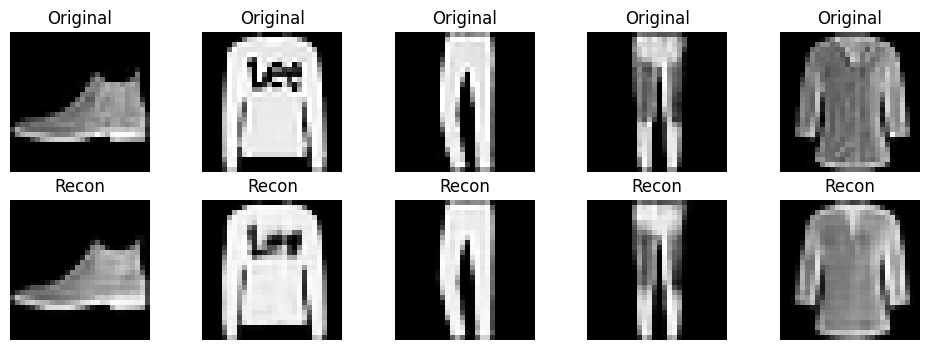

In [19]:
from itertools import product
import time
import pandas as pd

# === Grid para FMNIST (5L) ===
latent_grid   = [15, 30, 50, 100, 300, 600]
lr_grid       = [1e-3, 1e-4]
lambda_grid   = [0.0, 1e-4, 1e-3]
dropout_grid  = [0.0, 0.1, 0.3]
epochs_grid   = [30]   # ajusta si quieres (p.ej., 40)

results_fmnist_5L = []
best_fmnist_5L = {"psnr_val": -1.0, "state_dict": None, "cfg": None}

combo_total = len(latent_grid) * len(lr_grid) * len(lambda_grid) * len(dropout_grid) * len(epochs_grid)
print(f"Total combinaciones FMNIST-5L: {combo_total}")

i = 0
for latent_dim, lr, lambda_l1, dropout_p, epochs in product(latent_grid, lr_grid, lambda_grid, dropout_grid, epochs_grid):
    i += 1
    print(f"\n[{i}/{combo_total}] FMNIST 5L | latent={latent_dim} | lr={lr} | λL1={lambda_l1} | dropout={dropout_p} | epochs={epochs}")

    # Instancia modelo 5L (asegúrate de usar la versión que devuelve 28x28 exacto)
    model_FMNIST_5L = ConvAutoencoder_5L(latent_dim=latent_dim, dropout_p=dropout_p)

    # Entrena
    t0 = time.time()
    train_autoencoder_5L(
        model=model_FMNIST_5L,
        train_loader=train_loader_fmnist,
        val_loader=test_loader_fmnist,   # validación rápida
        epochs=epochs,
        lr=lr,
        lambda_l1=lambda_l1,
        device=device
    )
    train_time = time.time() - t0

    # Eval PSNR validación
    psnr_val = evaluate_on_loader(model_FMNIST_5L, test_loader_fmnist, device=device)

    # Guarda resultados
    res = {
        "arch": "5L",
        "dataset": "FMNIST",
        "latent": latent_dim,
        "lr": lr,
        "lambda_l1": lambda_l1,
        "dropout": dropout_p,
        "epochs": epochs,
        "psnr_val": psnr_val,
        "params": count_params(model_FMNIST_5L),
        "train_time_s": round(train_time, 2),
    }
    results_fmnist_5L.append(res)

    # Track mejor
    if psnr_val > best_fmnist_5L["psnr_val"]:
        best_fmnist_5L["psnr_val"] = psnr_val
        best_fmnist_5L["state_dict"] = {k: v.detach().cpu().clone() for k, v in model_FMNIST_5L.state_dict().items()}
        best_fmnist_5L["cfg"] = res.copy()
        print(f"  ✔️ Nuevo mejor PSNR (FMNIST-5L): {psnr_val:.2f} dB — cfg={res}")

# Tabla ordenada y guardado
df_grid_fmnist_5L = pd.DataFrame(results_fmnist_5L).sort_values("psnr_val", ascending=False).reset_index(drop=True)
display(df_grid_fmnist_5L.head(10))
df_grid_fmnist_5L.to_csv("grid_fmnist_5L_results.csv", index=False)
print("Guardado: grid_fmnist_5L_results.csv")

print("\nMejor configuración FMNIST-5L:")
print(best_fmnist_5L["cfg"])

# === Crea el modelo 'best' de FMNIST-5L ===
best_model_fmnist_5L = ConvAutoencoder_5L(
    latent_dim=best_fmnist_5L["cfg"]["latent"],
    dropout_p=best_fmnist_5L["cfg"]["dropout"]
).to(device); best_model_fmnist_5L.load_state_dict(best_fmnist_5L["state_dict"])

# Visualiza reconstrucciones del mejor
show_reconstructions(best_model_fmnist_5L, test_loader_fmnist, device, n=5)


In [102]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_grid_fmnist_5L)

arch dataset  latent      lr  lambda_l1  dropout  epochs   psnr_val  \
0     5L  FMNIST     600  0.0001     0.0010      0.0      30  24.574794   
1     5L  FMNIST     600  0.0001     0.0000      0.0      30  24.553386   
2     5L  FMNIST     600  0.0001     0.0001      0.0      30  24.303045   
3     5L  FMNIST     300  0.0001     0.0001      0.0      30  24.169885   
4     5L  FMNIST     300  0.0001     0.0000      0.0      30  24.088630   
5     5L  FMNIST     300  0.0001     0.0010      0.0      30  24.028657   
6     5L  FMNIST     300  0.0010     0.0010      0.0      30  23.890075   
7     5L  FMNIST     600  0.0010     0.0010      0.0      30  23.824891   
8     5L  FMNIST     600  0.0010     0.0001      0.0      30  23.485970   
9     5L  FMNIST     300  0.0010     0.0001      0.0      30  23.445219   
10    5L  FMNIST     100  0.0010     0.0010      0.0      30  23.364771   
11    5L  FMNIST     600  0.0010     0.0000      0.0      30  23.286086   
12    5L  FMNIST     100  0.0010     0.0001      0.0      30  23.267479   
13    5L  FMNIST     300  0.0010     0.0000      0.0      30  23.262661   
14    5L  FMNIST     100  0.0001     0.0000      0.0      30  23.146885   
15    5L  FMNIST     100  0.0001     0.0001      0.0      30  23.127225   
16    5L  FMNIST     100  0.0001     0.0010      0.0      30  23.104760   
17    5L  FMNIST     100  0.0010     0.0000      0.0      30  23.021031   
18    5L  FMNIST      50  0.0010     0.0001      0.0      30  22.672690   
19    5L  FMNIST     600  0.0001     0.0000      0.1      30  22.651870   
20    5L  FMNIST     600  0.0001     0.0010      0.1      30  22.636792   
21    5L  FMNIST      50  0.0010     0.0000      0.0      30  22.635648   
22    5L  FMNIST     300  0.0010     0.0010      0.1      30  22.627708   
23    5L  FMNIST      50  0.0010     0.0010      0.0      30  22.580303   
24    5L  FMNIST     600  0.0010     0.0010      0.1      30  22.577084   
25    5L  FMNIST     600  0.0001     0.0001      0.1      30  22.575840   
26    5L  FMNIST     300  0.0001     0.0000      0.1      30  22.485104   
27    5L  FMNIST     300  0.0010     0.0001      0.1      30  22.467107   
28    5L  FMNIST     600  0.0010     0.0001      0.1      30  22.451104   
29    5L  FMNIST     300  0.0001     0.0001      0.1      30  22.413617   
30    5L  FMNIST     100  0.0010     0.0001      0.1      30  22.378305   
31    5L  FMNIST     300  0.0001     0.0010      0.1      30  22.341348   
32    5L  FMNIST     100  0.0010     0.0010      0.1      30  22.299768   
33    5L  FMNIST      50  0.0001     0.0001      0.0      30  22.222468   
34    5L  FMNIST     100  0.0010     0.0000      0.1      30  22.215816   
35    5L  FMNIST      50  0.0001     0.0000      0.0      30  22.128781   
36    5L  FMNIST     600  0.0010     0.0000      0.1      30  22.103681   
37    5L  FMNIST     100  0.0001     0.0001      0.1      30  22.089266   
38    5L  FMNIST     100  0.0001     0.0000      0.1      30  22.081074   
39    5L  FMNIST      50  0.0001     0.0010      0.0      30  22.078855   
40    5L  FMNIST     300  0.0010     0.0000      0.1      30  22.052514   
41    5L  FMNIST     100  0.0001     0.0010      0.1      30  22.024897   
42    5L  FMNIST      50  0.0010     0.0001      0.1      30  21.942394   
43    5L  FMNIST      30  0.0010     0.0000      0.0      30  21.913248   
44    5L  FMNIST      50  0.0010     0.0000      0.1      30  21.887797   
45    5L  FMNIST      30  0.0010     0.0001      0.0      30  21.853207   
46    5L  FMNIST      50  0.0010     0.0010      0.1      30  21.783998   
47    5L  FMNIST      30  0.0010     0.0010      0.0      30  21.678773   
48    5L  FMNIST      50  0.0001     0.0000      0.1      30  21.612280   
49    5L  FMNIST      50  0.0001     0.0001      0.1      30  21.597299   
50    5L  FMNIST      50  0.0001     0.0010      0.1      30  21.474243   
51    5L  FMNIST      30  0.0001     0.0000      0.0      30  21.466353   
52    5L  FMNIST      30  0.0

GridSearch en FMNIST con 5 capas
================================

**Mejor combinación:** `latent=600`, `LR=1e-4`, `dropout=0` y `L1=1e-3`.\
Con esta configuración se alcanzó un PSNR de **24,57 dB**. Con `LR=1e-4` y sin dropout, los valores cercanos fueron **24,55 dB** sin L1 y **24,30 dB** con L1=1e-4, lo que indica un efecto pequeño de L1 cuando la optimización es estable.

Efecto de cada hiperparámetro
-----------------------------

### Dimensión latente

-   Se mantiene la relación capacidad--calidad: **600 > 300 > 100 > 50 > 30 > 15**.

-   **600**: ~24,3--24,6 dB con `LR=1e-4` y sin dropout.

-   **300**: ~24,0--24,2 dB;

-   **100**: ~23,1--23,4 dB;

-   **50**: ~22,2--22,7 dB;

-   **30**: ~21,3--21,9 dB;

-   **15**: ~19,5--20,7 dB.

-   En una red profunda, una latente pequeña amplifica la pérdida de detalle por compresión y por el suavizado acumulado de capas.

### Learning rate

-   En **5 capas** y **30 épocas**, **`LR=1e-4` supera consistentemente a `LR=1e-3`**.

-   Con `LR=1e-4` la optimización es más estable y alcanza mejores mínimos; con `LR=1e-3` aparecen resultados típicamente **0,3--0,8 dB** inferiores en las mismas latentes.

### Regularización L1

-   **Impacto moderado**. En el mejor caso, **L1=1e-3** aporta una **ligera ganancia** frente a no usar L1 o usar L1=1e-4.

-   En combinaciones subóptimas de latente o LR, L1 no compensa la falta de capacidad ni de convergencia.

### Dropout

-   **Perjudica de forma sistemática** la reconstrucción.

-   Con **0,1**, el PSNR cae a **~22--23 dB** incluso con latente grande.

-   Con **0,3**, la degradación es notable y sitúa los resultados alrededor de **20--21 dB**.

-   En tareas de reconstrucción determinista, apagar unidades reduce capacidad efectiva y borra señales débiles; la profundidad acentúa este efecto.

Interacciones relevantes
------------------------

-   El **punto óptimo** se logra con **latente grande** y **LR bajo (1e-4)**, **sin dropout**.

-   **LR alto** en una red profunda genera trayectorias de entrenamiento menos estables y peores mínimos.

-   **Dropout** magnifica cualquier limitación previa, ya sea latente estrecha o LR inadecuado.

Comparativa: FMNIST con 3 capas vs 5 capas
==========================================

**Mejores combinaciones:**

-   **3 capas:** `latent=600`, `LR=1e-3`, `dropout=0`, `L1=1e-4` → **PSNR = 28,57 dB**.

-   **5 capas:** `latent=600`, `LR=1e-4`, `dropout=0`, `L1=1e-3` → **PSNR = 24,57 dB**.

Diferencias globales de rendimiento
-----------------------------------

-   La red de **3 capas supera a la de 5 capas ~4 dB** en su mejor caso.

-   En FMNIST, las prendas contienen bordes finos y texturas sutiles; la **red más profunda tiende a suavizar** en exceso, borrando detalle y reduciendo el PSNR.

-   Con latentes pequeñas, la caída es mucho **más pronunciada en 5 capas**, por la combinación de compresión fuerte y mayor profundidad.

Efecto de cada hiperparámetro
-----------------------------

### Dimensión latente

-   **Tendencia común:** a mayor latente, mejor PSNR en ambas.

-   **Sensibilidad:** la **5 capas** es más frágil con latentes pequeñas; pasa de ~24,6 dB (600) a ~22,2 dB (50) y ~21,3 dB (30). La **3 capas** degrada más suavemente: ~28,6 dB (600) → ~22,6--24,3 dB (50--100).

-   **Lectura:** la profundidad amplifica la pérdida de información cuando el cuello de botella es estrecho.

### Learning rate

-   **3 capas:** rinde mejor con **`LR=1e-3`** en 30 épocas; necesita un paso mayor para converger.

-   **5 capas:** rinde mejor con **`LR=1e-4`** en 30 épocas; un paso más pequeño estabiliza la optimización en redes profundas.

-   **Conclusión:** a mayor profundidad conviene **bajar el LR** o **aumentar las épocas**; en redes menos profundas, **subir el LR** acelera una convergencia efectiva.

### Regularización L1

-   **Efecto leve** en ambas. En 3 capas añade una ganancia pequeña cuando ya hay buena convergencia; en 5 capas también ayuda de forma marginal, pero no corrige un LR o una latente mal elegidos.

### Dropout

-   **Perjudica sistemáticamente** la reconstrucción en las dos arquitecturas.

-   El impacto es **más severo en 5 capas**: con `dropout=0.1` baja a ~22--23 dB y con `0.3` cae a ~20--21 dB.

-   En tareas de reconstrucción determinista, apagar unidades reduce capacidad efectiva y borra señales débiles; la profundidad intensifica este efecto.

Interacciones relevantes
------------------------

-   **3 capas:** "punto dulce" con **latente grande + `LR=1e-3` + sin dropout**.

-   **5 capas:** "punto dulce" con **latente grande + `LR=1e-4` + sin dropout**.

-   **LR bajo + L1** suma restricciones y **empeora** si la red ya está limitada por capacidad o por pocas épocas.

-   **Dropout** agrava cualquier limitación previa en ambas.

Comparativa global: MNIST vs FMNIST
===================================

**Mejores resultados por arquitectura**

-   **3 capas:** MNIST **31,97 dB** vs FMNIST **28,57 dB** → diferencia ≈ **+3,4 dB** a favor de MNIST.

-   **5 capas:** MNIST **28,74 dB** vs FMNIST **24,57 dB** → diferencia ≈ **+4,2 dB** a favor de MNIST.

Lectura general
---------------

-   **MNIST es más "fácil" de reconstruir**: dígitos con trazos gruesos y fondos limpios producen PSNR más altos.

-   **FMNIST es más complejo**: prendas con texturas finas y bordes menos definidos; cualquier pérdida de detalle penaliza más el PSNR.

-   La **profundidad (5 capas)** tiende a **suavizar**; ese suavizado afecta mucho más a FMNIST que a MNIST.

Efecto de los hiperparámetros en ambos datasets
-----------------------------------------------

### Dimensión latente

-   Tendencia idéntica: **más latente → más PSNR**.

-   **Sensibilidad mayor en FMNIST**: bajar de 600 a 100--50 causa caídas más bruscas que en MNIST, por la mayor riqueza de detalles que se comprimen en el cuello de botella.

### Learning rate

-   En **3 capas**, el mejor LR es **1e-3** tanto en MNIST como en FMNIST, con 30 épocas: se necesita un paso suficiente para converger.

-   En **5 capas**, el mejor LR es **1e-4** en ambos datasets: el entrenamiento profundo es más estable con pasos pequeños.

-   Conclusión: **la profundidad, no el dataset**, marca el LR óptimo.

### Regularización L1

-   **Efecto leve** en los dos datasets: aporta pequeñas mejoras cuando el entrenamiento ya es estable (latente grande y LR adecuado).

-   No corrige configuraciones subóptimas de latente o LR.

### Dropout

-   **Perjudica sistemáticamente** en ambos.

-   **FMNIST sufre más**: a igualdad de hiperparámetros, el descenso de PSNR por usar 0,1--0,3 es mayor que en MNIST porque se pierden texturas y contornos finos.

Profundidad: 3 vs 5 capas en cada dataset
-----------------------------------------

-   **MNIST:** 3 capas > 5 capas por ~3 dB en el tope; la 5L necesita LR bajo y más épocas para acercarse, pero sigue por detrás.

-   **FMNIST:** la brecha se agranda (~4 dB) porque la 5L suaviza más y borra detalles relevantes de ropa.

## Denoising Autoencoder (DAE)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from math import log10
import matplotlib.pyplot as plt

# Ruido gaussiano con clamp a [0,1]
def add_gaussian_noise(x, sigma):
    if sigma <= 0:
        return x
    noisy = x + torch.randn_like(x) * sigma
    return torch.clamp(noisy, 0.0, 1.0)

# PSNR batch medio (reutiliza tu psnr si ya la tienes)
def batch_psnr(recon, target):
    mse = torch.mean((recon - target) ** 2)
    if mse.item() == 0:
        return 100.0
    return 10.0 * torch.log10(1.0 / mse).item()


In [21]:
def train_denoising_autoencoder(
        model,
        train_loader,
        val_loader=None,
        epochs=10,
        lr=1e-3,
        lambda_l1=1e-4,
        sigma_train=0.3,
        device=device,
        use_scheduler=True,
        early_stopping_patience=5,
        name_prefix="DAE"
    ):
    """
    Entrena un DAE: entrada = x + N(0, sigma_train^2), target = x limpio.
    Pérdida = MSE(recon, x) + lambda_l1 * mean(|z|).
    Valida con el mismo sigma_train (opcional).
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    mse = nn.MSELoss()
    best_val_psnr = -1.0
    best_state = None
    bad_epochs = 0

    for epoch in range(1, epochs + 1):
        # -------- Train --------
        model.train()
        running_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            x_noisy = add_gaussian_noise(x, sigma_train)

            optimizer.zero_grad()
            recon, z = model(x_noisy)
            loss = mse(recon, x) + lambda_l1 * torch.mean(torch.abs(z))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # -------- Val --------
        val_psnr = None
        if val_loader is not None:
            model.eval()
            psnrs = []
            with torch.no_grad():
                for x, _ in val_loader:
                    x = x.to(device)
                    x_noisy = add_gaussian_noise(x, sigma_train)
                    recon, _ = model(x_noisy)
                    psnrs.append(batch_psnr(recon, x))
            val_psnr = float(np.mean(psnrs))

            # early stopping & scheduler
            if scheduler is not None:
                scheduler.step(val_psnr)

            if val_psnr > best_val_psnr:
                best_val_psnr = val_psnr
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                bad_epochs = 0
            else:
                bad_epochs += 1

        # Print
        if val_psnr is None:
            print(f"[{name_prefix}] Epoch {epoch:02d}/{epochs} | TrainLoss={train_loss:.5f}")
        else:
            print(f"[{name_prefix}] Epoch {epoch:02d}/{epochs} | TrainLoss={train_loss:.5f} | ValPSNR@σ={sigma_train:.2f}: {val_psnr:.2f} dB")

        # Early stopping
        if val_loader is not None and early_stopping_patience is not None and bad_epochs >= early_stopping_patience:
            print(f"[{name_prefix}] Early stopping en epoch {epoch}.")
            break

    # Carga mejor estado si hubo validación
    if best_state is not None:
        model.load_state_dict(best_state)

    return model


In [22]:
@torch.no_grad()
def evaluate_psnr_vs_sigma(model, data_loader, sigma_list, device='cpu'):
    """
    Evalúa el modelo entrenado con diferentes niveles de ruido de entrada.
    Devuelve dict {sigma: PSNR_medio}
    """
    model.eval()
    results = {}
    for sigma in sigma_list:
        psnrs = []
        for x, _ in data_loader:
            x = x.to(device)
            x_noisy = add_gaussian_noise(x, sigma)
            recon, _ = model(x_noisy)
            psnrs.append(batch_psnr(recon, x))
        results[sigma] = float(np.mean(psnrs))
    return results

def plot_psnr_vs_sigma(results_dict, title="PSNR vs σ (ruido gaussiano)"):
    sigmas = sorted(results_dict.keys())
    psnrs  = [results_dict[s] for s in sigmas]
    plt.figure(figsize=(5,4))
    plt.plot(sigmas, psnrs, marker='o')
    plt.xlabel("σ (desviación estándar del ruido)")
    plt.ylabel("PSNR (dB)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


In [23]:
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def show_denoising_examples(model, data_loader, sigma=0.3, n=8, device=device):
    model.eval()
    x, _ = next(iter(data_loader))
    x = x[:n].to(device)
    x_noisy = add_gaussian_noise(x, sigma)
    recon, _ = model(x_noisy)

    # Baja a CPU para dibujar
    x = x.cpu(); x_noisy = x_noisy.cpu(); recon = recon.cpu()

    plt.figure(figsize=(12,4))
    for i in range(n):
        # Limpia
        plt.subplot(3, n, i+1); plt.imshow(x[i,0], cmap='gray'); plt.axis('off')
        if i == 0: plt.ylabel("Limpia")
        # Ruidosa
        plt.subplot(3, n, n+i+1); plt.imshow(x_noisy[i,0], cmap='gray'); plt.axis('off')
        if i == 0: plt.ylabel(f"Ruidosa σ={sigma}")
        # Reconstruida
        plt.subplot(3, n, 2*n+i+1); plt.imshow(recon[i,0], cmap='gray'); plt.axis('off')
        if i == 0: plt.ylabel("Reconstruida")
    plt.suptitle("Denoising AE — ejemplos")
    plt.tight_layout()
    plt.show()


Se va a entrenar con una arquitectura de 3 capas para MNIST

>> Inicializado DAE-3L con pesos del mejor AE-3L
[DAE_MNIST_3L_fromAE_lat600] Epoch 01/15 | TrainLoss=0.00574 | ValPSNR@σ=0.30: 23.02 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 02/15 | TrainLoss=0.00493 | ValPSNR@σ=0.30: 23.11 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 03/15 | TrainLoss=0.00480 | ValPSNR@σ=0.30: 23.28 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 04/15 | TrainLoss=0.00473 | ValPSNR@σ=0.30: 23.33 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 05/15 | TrainLoss=0.00467 | ValPSNR@σ=0.30: 23.27 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 06/15 | TrainLoss=0.00461 | ValPSNR@σ=0.30: 23.45 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 07/15 | TrainLoss=0.00457 | ValPSNR@σ=0.30: 23.48 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 08/15 | TrainLoss=0.00456 | ValPSNR@σ=0.30: 23.47 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 09/15 | TrainLoss=0.00452 | ValPSNR@σ=0.30: 23.44 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 10/15 | TrainLoss=0.00450 | ValPSNR@σ=0.30: 23.51 dB
[DAE_MNIST_3L_fromAE_lat600] Epoch 11/15 | TrainLoss=0.00448 | ValPSNR@

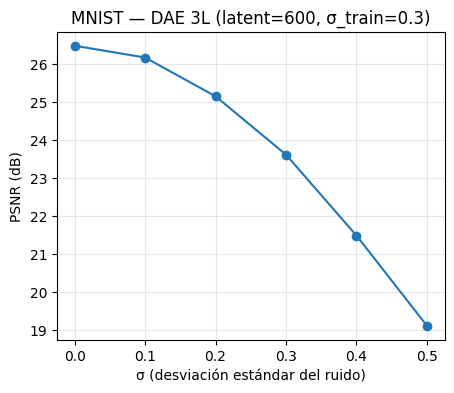

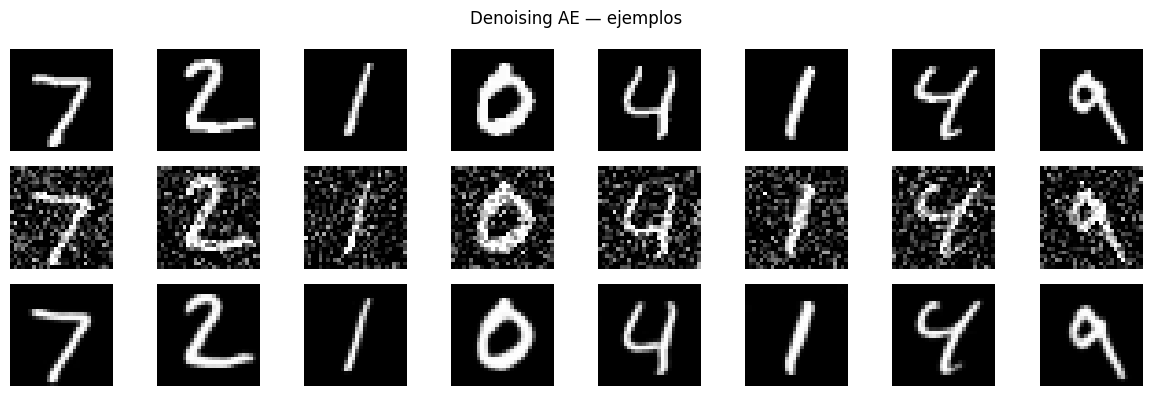

In [24]:
# === DAE desde tu mejor AE-3L ===
assert 'best_3L' in globals() and best_3L["state_dict"] is not None, "best_3L no definido o sin state_dict."

sigma_train = 0.3
epochs = 15          # un poco más que AE
lr = 1e-3
lambda_l1 = 1e-4

latent_dim_best_3L = best_3L["cfg"]["latent"]
dropout_best_3L    = best_3L["cfg"]["dropout"]

# Instancia con la mejor config encontrada
model_dae_mnist_3L = ConvAutoencoder_3L(latent_dim=latent_dim_best_3L, dropout_p=dropout_best_3L)

# Inicializa con pesos del mejor AE (acelera y mejora el DAE)
model_dae_mnist_3L.load_state_dict(best_3L["state_dict"], strict=True)
print(">> Inicializado DAE-3L con pesos del mejor AE-3L")

# Validación (si tienes val_loader propio, úsalo aquí)
val_loader_mnist = test_loader_mnist

# Entrenamiento DAE
model_dae_mnist_3L = train_denoising_autoencoder(
    model=model_dae_mnist_3L,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=epochs,
    lr=lr,
    lambda_l1=lambda_l1,
    sigma_train=sigma_train,
    device=device,
    name_prefix=f"DAE_MNIST_3L_fromAE_lat{latent_dim_best_3L}"
)

# PSNR vs σ
sigma_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results_mnist_3L = evaluate_psnr_vs_sigma(model_dae_mnist_3L, test_loader_mnist, sigma_list, device=device)
print("MNIST (3L-DAE) — PSNR medios por σ:", results_mnist_3L)

plot_psnr_vs_sigma(results_mnist_3L, title=f"MNIST — DAE 3L (latent={latent_dim_best_3L}, σ_train={sigma_train})")

# Ejemplos visuales
show_denoising_examples(model_dae_mnist_3L, test_loader_mnist, sigma=sigma_train, n=8, device=device)


Tambien se va a probar con una arquitectura de 5 capas para el dataset MNIST

>> Inicializado DAE-5L con pesos del mejor AE-5L
[DAE_MNIST_5L_fromAE_lat600] Epoch 01/15 | TrainLoss=0.01762 | ValPSNR@σ=0.30: 20.87 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 02/15 | TrainLoss=0.00749 | ValPSNR@σ=0.30: 21.30 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 03/15 | TrainLoss=0.00682 | ValPSNR@σ=0.30: 21.78 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 04/15 | TrainLoss=0.00640 | ValPSNR@σ=0.30: 22.14 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 05/15 | TrainLoss=0.00614 | ValPSNR@σ=0.30: 22.27 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 06/15 | TrainLoss=0.00599 | ValPSNR@σ=0.30: 22.27 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 07/15 | TrainLoss=0.00587 | ValPSNR@σ=0.30: 22.33 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 08/15 | TrainLoss=0.00573 | ValPSNR@σ=0.30: 22.42 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 09/15 | TrainLoss=0.00566 | ValPSNR@σ=0.30: 22.63 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 10/15 | TrainLoss=0.00555 | ValPSNR@σ=0.30: 22.59 dB
[DAE_MNIST_5L_fromAE_lat600] Epoch 11/15 | TrainLoss=0.00547 | ValPSNR@

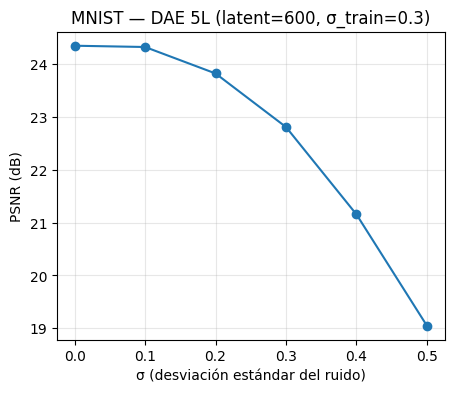

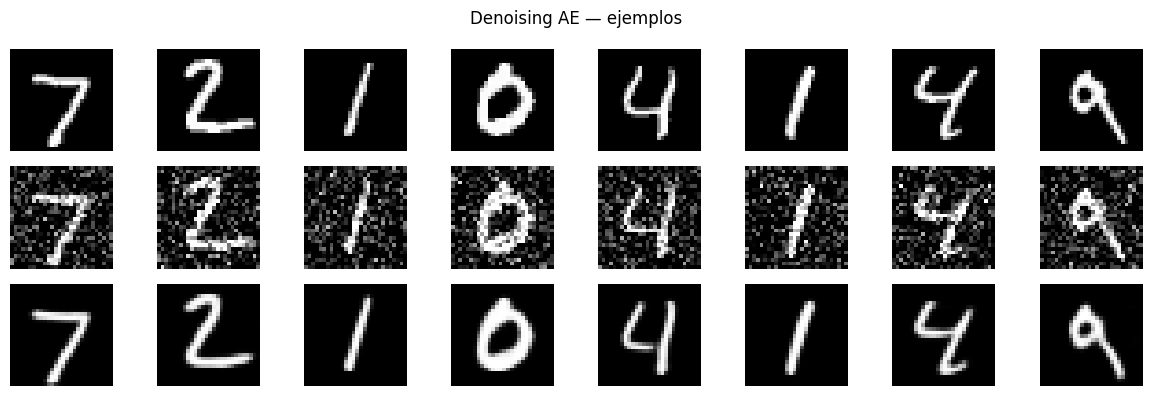

In [25]:
# === DAE desde tu mejor AE-5L ===
assert 'best_5L' in globals() and best_5L["state_dict"] is not None, "best_5L no definido o sin state_dict."

sigma_train = 0.3
epochs = 15
lr = 1e-3
lambda_l1 = 1e-4

latent_dim_best_5L = best_5L["cfg"]["latent"]
dropout_best_5L    = best_5L["cfg"]["dropout"]

model_dae_mnist_5L = ConvAutoencoder_5L(latent_dim=latent_dim_best_5L, dropout_p=dropout_best_5L)
model_dae_mnist_5L.load_state_dict(best_5L["state_dict"], strict=True)
print(">> Inicializado DAE-5L con pesos del mejor AE-5L")

val_loader_mnist = test_loader_mnist

model_dae_mnist_5L = train_denoising_autoencoder(
    model=model_dae_mnist_5L,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=epochs,
    lr=lr,
    lambda_l1=lambda_l1,
    sigma_train=sigma_train,
    device=device,
    name_prefix=f"DAE_MNIST_5L_fromAE_lat{latent_dim_best_5L}"
)

sigma_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results_mnist_5L = evaluate_psnr_vs_sigma(model_dae_mnist_5L, test_loader_mnist, sigma_list, device=device)
print("MNIST (5L-DAE) — PSNR medios por σ:", results_mnist_5L)

plot_psnr_vs_sigma(results_mnist_5L, title=f"MNIST — DAE 5L (latent={latent_dim_best_5L}, σ_train={sigma_train})")

# Ejemplos visuales
show_denoising_examples(model_dae_mnist_5L, test_loader_mnist, sigma=sigma_train, n=8, device=device)


Tambien se va a probar con una arquitectura de 3 capas para el dataset FMNIST

>> Inicializado DAE-FMNIST-3L con pesos del mejor AE-FMNIST-3L
[DAE_FMNIST_3L_fromAE_lat600] Epoch 01/15 | TrainLoss=0.00843 | ValPSNR@σ=0.30: 21.05 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 02/15 | TrainLoss=0.00777 | ValPSNR@σ=0.30: 20.98 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 03/15 | TrainLoss=0.00759 | ValPSNR@σ=0.30: 21.24 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 04/15 | TrainLoss=0.00749 | ValPSNR@σ=0.30: 21.28 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 05/15 | TrainLoss=0.00742 | ValPSNR@σ=0.30: 21.12 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 06/15 | TrainLoss=0.00739 | ValPSNR@σ=0.30: 21.35 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 07/15 | TrainLoss=0.00733 | ValPSNR@σ=0.30: 21.40 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 08/15 | TrainLoss=0.00727 | ValPSNR@σ=0.30: 21.39 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 09/15 | TrainLoss=0.00722 | ValPSNR@σ=0.30: 21.39 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 10/15 | TrainLoss=0.00720 | ValPSNR@σ=0.30: 21.41 dB
[DAE_FMNIST_3L_fromAE_lat600] Epoch 11/15 | Tra

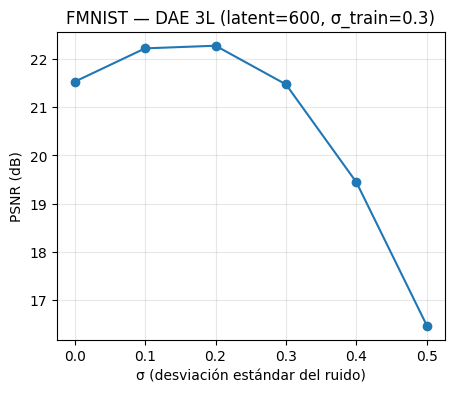

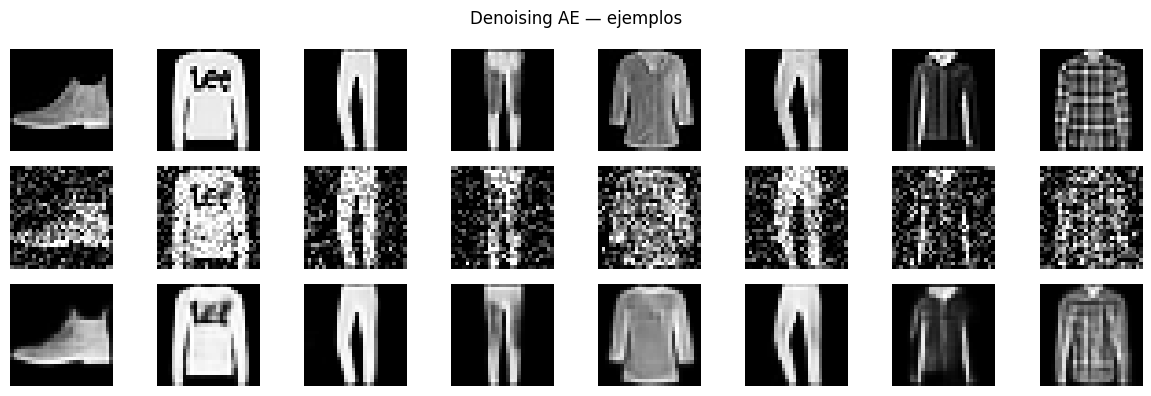

In [26]:
# === DAE desde tu mejor AE-3L en FMNIST ===
assert 'best_fmnist_3L' in globals() and best_fmnist_3L["state_dict"] is not None, "best_fmnist_3L no definido o sin state_dict."

sigma_train = 0.3
epochs = 15
lr = 1e-3
lambda_l1 = 1e-4

latent_dim_best_f3L = best_fmnist_3L["cfg"]["latent"]
dropout_best_f3L    = best_fmnist_3L["cfg"]["dropout"]

model_dae_fmnist_3L = ConvAutoencoder_3L(latent_dim=latent_dim_best_f3L, dropout_p=dropout_best_f3L)
model_dae_fmnist_3L.load_state_dict(best_fmnist_3L["state_dict"], strict=True)
print(">> Inicializado DAE-FMNIST-3L con pesos del mejor AE-FMNIST-3L")

val_loader_fmnist = test_loader_fmnist  # usa tu val_loader propio si lo tienes

model_dae_fmnist_3L = train_denoising_autoencoder(
    model=model_dae_fmnist_3L,
    train_loader=train_loader_fmnist,
    val_loader=val_loader_fmnist,
    epochs=epochs,
    lr=lr,
    lambda_l1=lambda_l1,
    sigma_train=sigma_train,
    device=device,
    name_prefix=f"DAE_FMNIST_3L_fromAE_lat{latent_dim_best_f3L}"
)

sigma_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results_fmnist_3L = evaluate_psnr_vs_sigma(model_dae_fmnist_3L, test_loader_fmnist, sigma_list, device=device)
print("FMNIST (3L-DAE) — PSNR medios por σ:", results_fmnist_3L)

plot_psnr_vs_sigma(results_fmnist_3L, title=f"FMNIST — DAE 3L (latent={latent_dim_best_f3L}, σ_train={sigma_train})")
show_denoising_examples(model_dae_fmnist_3L, test_loader_fmnist, sigma=sigma_train, n=8, device=device)


Tambien se va a probar con una arquitectura de 5 capas para el dataset FMNIST

>> Inicializado DAE-FMNIST-5L con pesos del mejor AE-FMNIST-5L
[DAE_FMNIST_5L_fromAE_lat600] Epoch 01/15 | TrainLoss=0.01782 | ValPSNR@σ=0.30: 19.12 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 02/15 | TrainLoss=0.01130 | ValPSNR@σ=0.30: 19.66 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 03/15 | TrainLoss=0.01027 | ValPSNR@σ=0.30: 19.94 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 04/15 | TrainLoss=0.00982 | ValPSNR@σ=0.30: 19.95 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 05/15 | TrainLoss=0.00949 | ValPSNR@σ=0.30: 20.16 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 06/15 | TrainLoss=0.00925 | ValPSNR@σ=0.30: 20.26 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 07/15 | TrainLoss=0.00903 | ValPSNR@σ=0.30: 20.27 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 08/15 | TrainLoss=0.00893 | ValPSNR@σ=0.30: 20.41 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 09/15 | TrainLoss=0.00882 | ValPSNR@σ=0.30: 20.47 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 10/15 | TrainLoss=0.00865 | ValPSNR@σ=0.30: 20.59 dB
[DAE_FMNIST_5L_fromAE_lat600] Epoch 11/15 | Tra

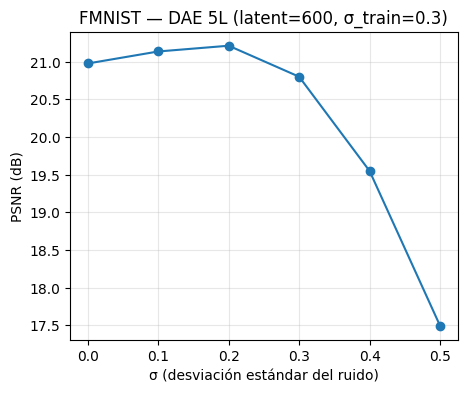

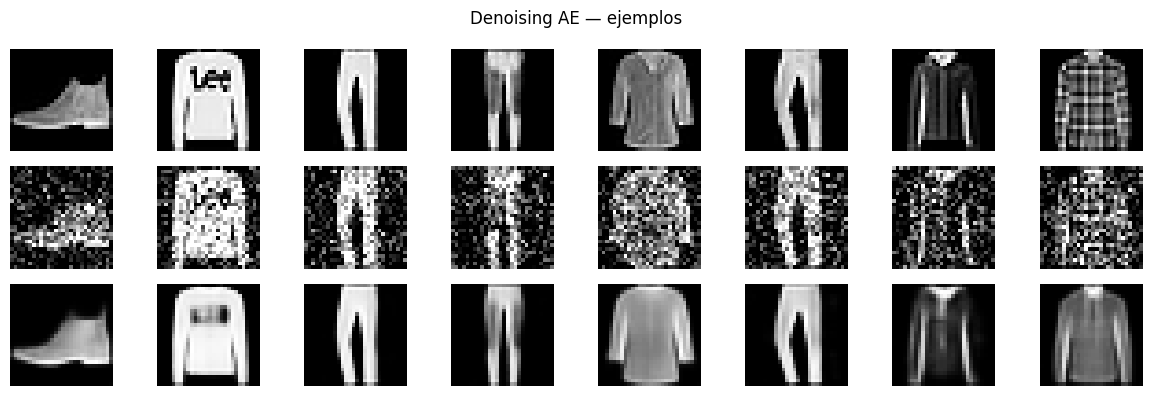

In [27]:
# === DAE desde tu mejor AE-5L en FMNIST ===
assert 'best_fmnist_5L' in globals() and best_fmnist_5L["state_dict"] is not None, "best_fmnist_5L no definido o sin state_dict."

sigma_train = 0.3
epochs = 15
lr = 1e-3
lambda_l1 = 1e-4

latent_dim_best_f5L = best_fmnist_5L["cfg"]["latent"]
dropout_best_f5L    = best_fmnist_5L["cfg"]["dropout"]

model_dae_fmnist_5L = ConvAutoencoder_5L(latent_dim=latent_dim_best_f5L, dropout_p=dropout_best_f5L)
model_dae_fmnist_5L.load_state_dict(best_fmnist_5L["state_dict"], strict=True)
print(">> Inicializado DAE-FMNIST-5L con pesos del mejor AE-FMNIST-5L")

val_loader_fmnist = test_loader_fmnist

model_dae_fmnist_5L = train_denoising_autoencoder(
    model=model_dae_fmnist_5L,
    train_loader=train_loader_fmnist,
    val_loader=val_loader_fmnist,
    epochs=epochs,
    lr=lr,
    lambda_l1=lambda_l1,
    sigma_train=sigma_train,
    device=device,
    name_prefix=f"DAE_FMNIST_5L_fromAE_lat{latent_dim_best_f5L}"
)

sigma_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results_fmnist_5L = evaluate_psnr_vs_sigma(model_dae_fmnist_5L, test_loader_fmnist, sigma_list, device=device)
print("FMNIST (5L-DAE) — PSNR medios por σ:", results_fmnist_5L)

plot_psnr_vs_sigma(results_fmnist_5L, title=f"FMNIST — DAE 5L (latent={latent_dim_best_f5L}, σ_train={sigma_train})")
show_denoising_examples(model_dae_fmnist_5L, test_loader_fmnist, sigma=sigma_train, n=8, device=device)


## Extraer embeddings y visualizar con t-SNE / PCA

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

@torch.no_grad()
def get_embeddings(model, data_loader, max_samples=2000, device='cpu'):
    """
    Pasa imágenes por el encoder y retorna:
    Z: (n_muestras, latent_dim), y: etiquetas (n_muestras,)
    Limita a max_samples para acelerar t-SNE.
    """
    model.eval()
    zs, ys = [], []
    seen = 0
    for x, y in data_loader:
        x = x.to(device)
        _, z = model(x)         # forward devuelve (recon, z)
        zs.append(z.detach().cpu())
        ys.append(y.detach().cpu())
        seen += x.size(0)
        if seen >= max_samples:
            break
    Z = torch.cat(zs, dim=0).numpy()
    y = torch.cat(ys, dim=0).numpy()
    if Z.shape[0] > max_samples:
        Z = Z[:max_samples]
        y = y[:max_samples]
    return Z, y

def plot_tsne(Z, y, perplexity=30, n_iter=1000, title="t-SNE del embedding"):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, init='pca', learning_rate='auto', random_state=42)
    Z2 = tsne.fit_transform(Z)
    plt.figure(figsize=(6,5))
    sc = plt.scatter(Z2[:,0], Z2[:,1], c=y, s=8, cmap='tab10', alpha=0.8)
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    cb = plt.colorbar(sc, ticks=range(len(np.unique(y))))
    cb.set_label('Clase')
    plt.show()

def plot_pca(Z, y, title="PCA del embedding"):
    pca = PCA(n_components=2, random_state=42)
    Z2 = pca.fit_transform(Z)
    var = pca.explained_variance_ratio_.sum()*100
    plt.figure(figsize=(6,5))
    sc = plt.scatter(Z2[:,0], Z2[:,1], c=y, s=8, cmap='tab10', alpha=0.8)
    plt.title(f"{title} — Var.Exp.≈{var:.1f}%")
    plt.xticks([]); plt.yticks([])
    cb = plt.colorbar(sc, ticks=range(len(np.unique(y))))
    cb.set_label('Clase')
    plt.show()


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmat

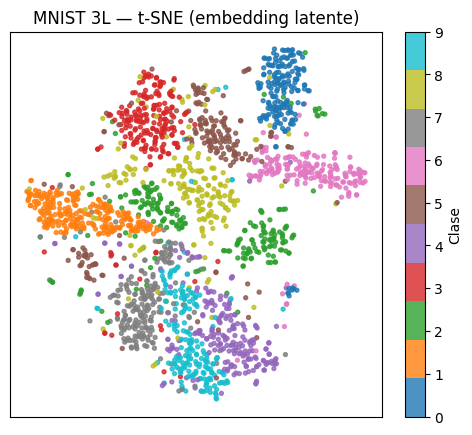

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid val

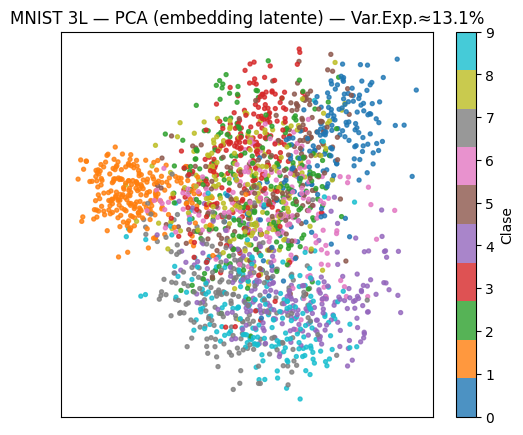

In [29]:
# Ejemplo con MNIST y 3 capas
best_model_1 = best_model_3L  
Z, y = get_embeddings(best_model_1, test_loader_mnist, max_samples=2000, device=device)

plot_tsne(Z, y, perplexity=30, n_iter=1200, title="MNIST 3L — t-SNE (embedding latente)")
plot_pca(Z, y, title="MNIST 3L — PCA (embedding latente)")


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmat

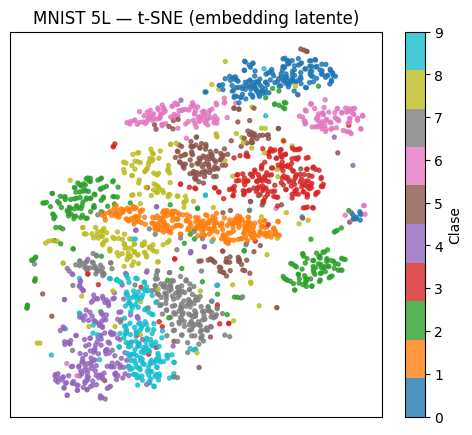

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid val

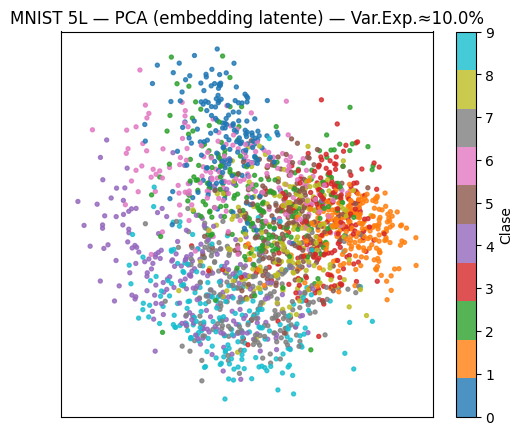

In [30]:
# Ejemplo con MNIST y 5 capas
best_model_2= best_model_5L  
Z, y = get_embeddings(best_model_2, test_loader_mnist, max_samples=2000, device=device)

plot_tsne(Z, y, perplexity=30, n_iter=1200, title="MNIST 5L — t-SNE (embedding latente)")
plot_pca(Z, y, title="MNIST 5L — PCA (embedding latente)")


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmat

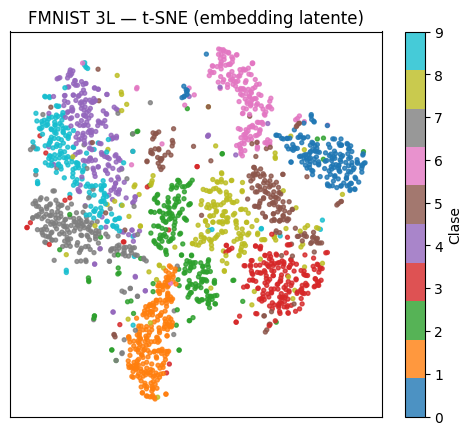

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid val

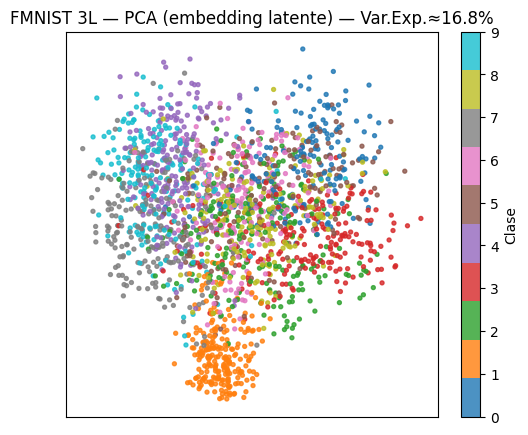

In [34]:
# Ejemplo con FMNIST y tres capas
best_model_3 = best_model_fmnist_3L  
Z, y = get_embeddings(best_model_3, test_loader_mnist, max_samples=2000, device=device)

plot_tsne(Z, y, perplexity=30, n_iter=1200, title="FMNIST 3L — t-SNE (embedding latente)")
plot_pca(Z, y, title="FMNIST 3L — PCA (embedding latente)")


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmat

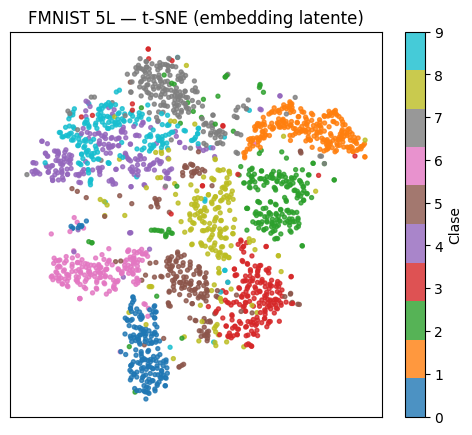

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid val

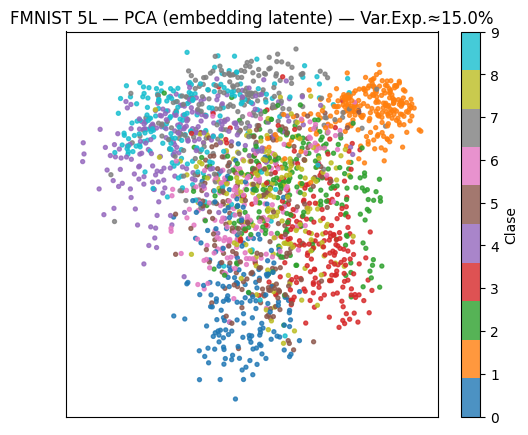

In [35]:
# Ejemplo con FMNIST y tres capas
best_model_4 = best_model_fmnist_5L  
Z, y = get_embeddings(best_model_4, test_loader_mnist, max_samples=2000, device=device)

plot_tsne(Z, y, perplexity=30, n_iter=1200, title="FMNIST 5L — t-SNE (embedding latente)")
plot_pca(Z, y, title="FMNIST 5L — PCA (embedding latente)")


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def psnr_per_image(x, recon):
    """
    PSNR por imagen en un batch. Asume rango [0,1].
    Devuelve tensor (batch,)
    """
    mse = torch.mean((recon - x) ** 2, dim=(1,2,3))  # promedio por imagen
    mse = torch.clamp(mse, min=1e-12)                # evita /0
    psnr = 10.0 * torch.log10(1.0 / mse)
    return psnr

@torch.no_grad()
def collect_psnr_samples(model, data_loader, max_samples=512, device='cpu', noise_sigma=None):
    """
    Recorre el loader, computa PSNR por imagen y guarda tuplas (psnr, x, recon).
    Si noise_sigma se da, añade ruido a la entrada (para evaluar DAE).
    """
    model.eval()
    records = []
    seen = 0
    for x, _ in data_loader:
        x = x.to(device)
        x_in = x
        if noise_sigma is not None and noise_sigma > 0:
            x_in = torch.clamp(x + torch.randn_like(x)*noise_sigma, 0.0, 1.0)
        recon, _ = model(x_in)
        ps = psnr_per_image(x, recon).detach().cpu()
        for i in range(x.size(0)):
            records.append((ps[i].item(), x[i].detach().cpu(), recon[i].detach().cpu()))
        seen += x.size(0)
        if seen >= max_samples:
            break
    return records

def show_best_worst(records, k=6, title="Reconstrucciones: mejores vs peores"):
    """
    records: lista de (psnr, x, recon). Muestra top-k y bottom-k
    """
    # Ordena por PSNR descendente
    records_sorted = sorted(records, key=lambda t: t[0], reverse=True)
    best = records_sorted[:k]
    worst = records_sorted[-k:] if len(records_sorted) >= k else records_sorted[-len(records_sorted):]

    n = max(len(best), len(worst))
    plt.figure(figsize=(12, 4))
    # Fila 1: mejores (original, recon)
    for i, (ps, x, recon) in enumerate(best):
        plt.subplot(2, n, i+1)
        plt.imshow(x[0], cmap='gray'); plt.axis('off')
        plt.title(f"Best#{i+1}\nPSNR {ps:.1f}dB", fontsize=9)
    for i, (ps, x, recon) in enumerate(best):
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[0], cmap='gray'); plt.axis('off')
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

    # Fila 2: peores (original, recon)
    plt.figure(figsize=(12, 4))
    for i, (ps, x, recon) in enumerate(worst):
        plt.subplot(2, n, i+1)
        plt.imshow(x[0], cmap='gray'); plt.axis('off')
        plt.title(f"Worst#{i+1}\nPSNR {ps:.1f}dB", fontsize=9)
    for i, (ps, x, recon) in enumerate(worst):
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[0], cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


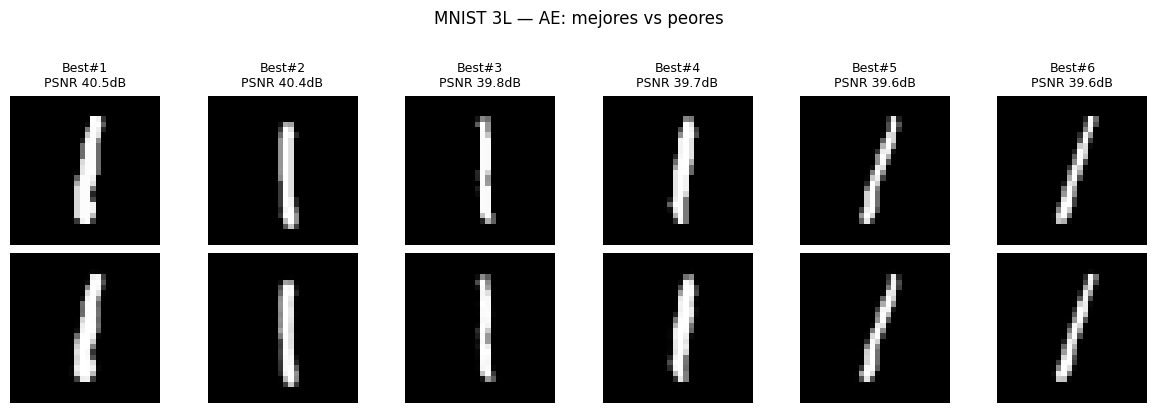

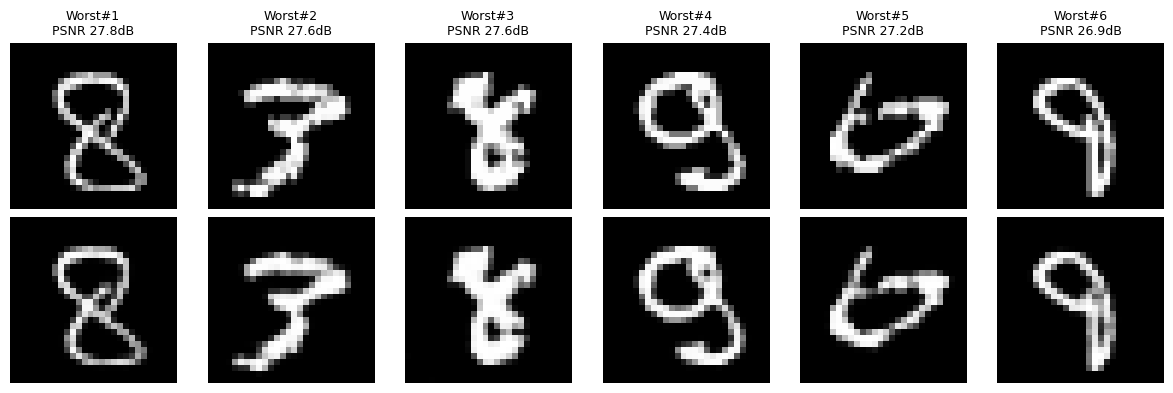

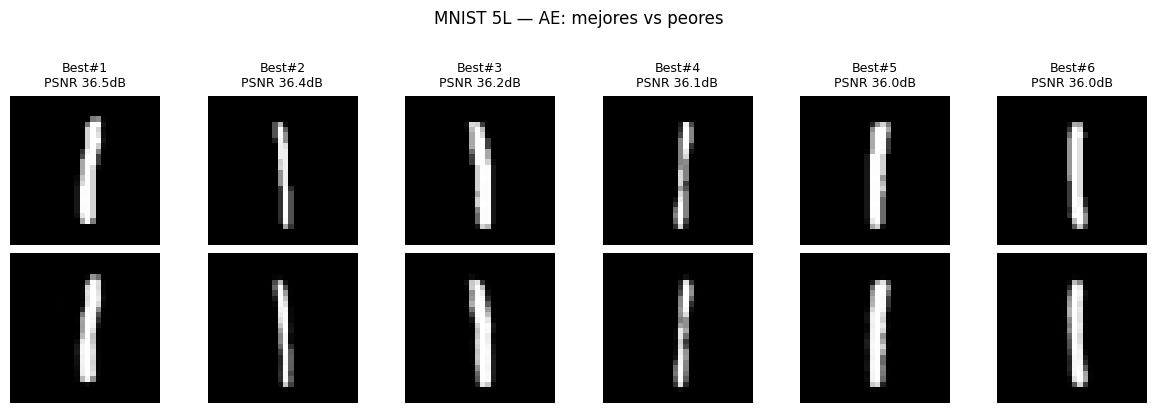

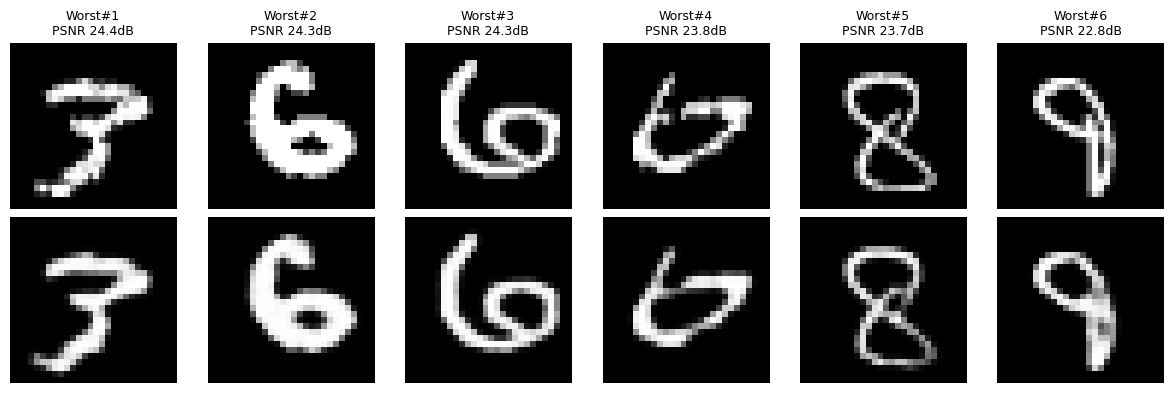

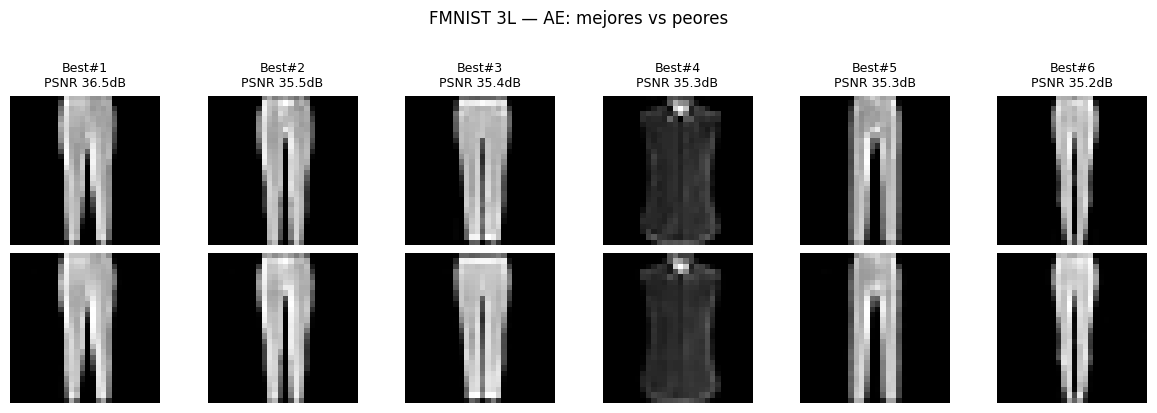

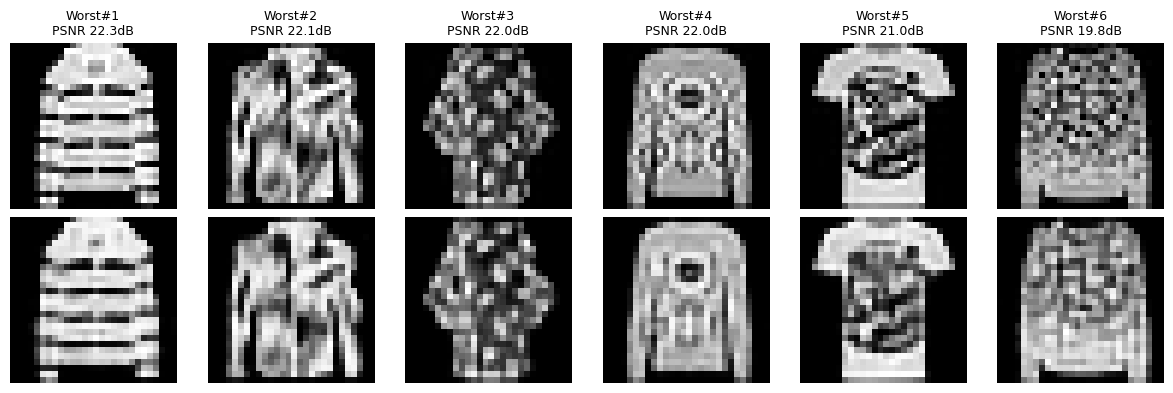

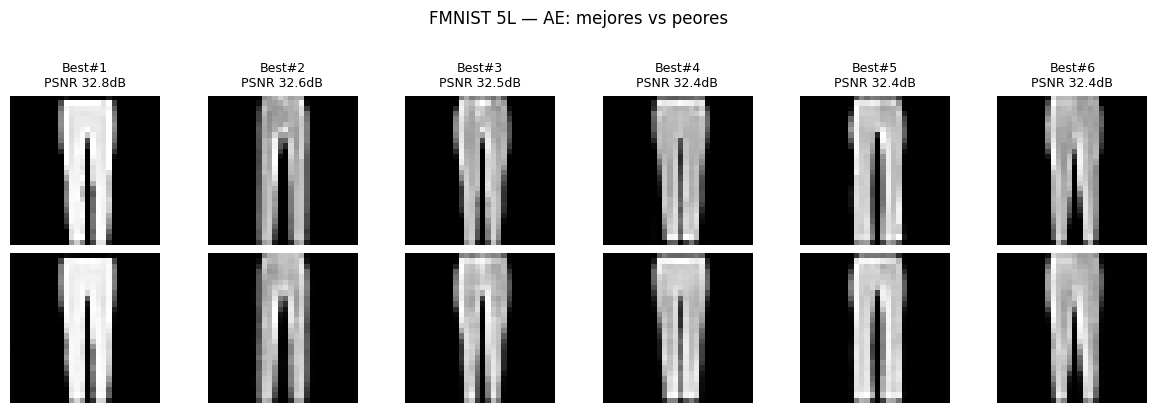

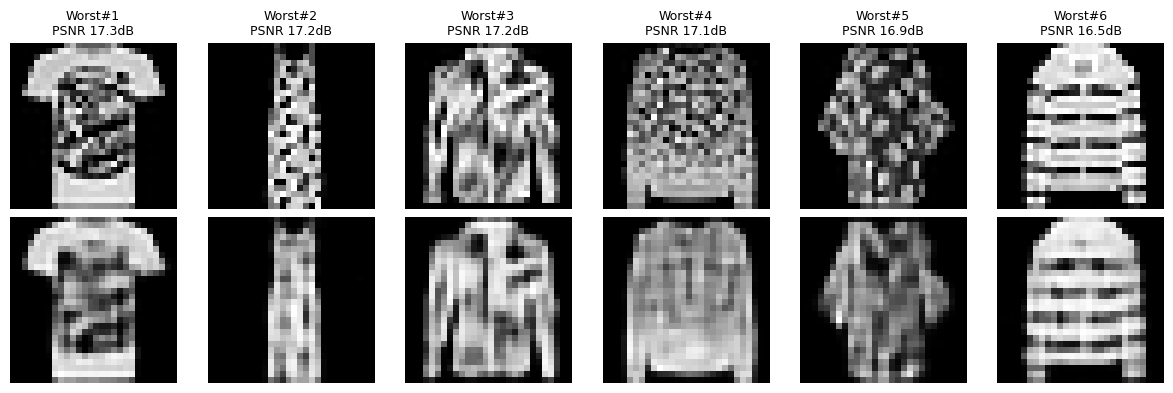

In [37]:
# (a) AE “limpio” (sin ruido) – MNIST
records_clean = collect_psnr_samples(best_model_1, test_loader_mnist, max_samples=512, device=device, noise_sigma=None)
show_best_worst(records_clean, k=6, title="MNIST 3L — AE: mejores vs peores")

# (a) AE “limpio” (sin ruido) – FMNIST
records_clean = collect_psnr_samples(best_model_2, test_loader_mnist, max_samples=512, device=device, noise_sigma=None)
show_best_worst(records_clean, k=6, title="MNIST 5L — AE: mejores vs peores")

# (a) AE “limpio” (sin ruido) – FMNIST
records_clean = collect_psnr_samples(best_model_3, test_loader_fmnist, max_samples=512, device=device, noise_sigma=None)
show_best_worst(records_clean, k=6, title="FMNIST 3L — AE: mejores vs peores")

# (a) AE “limpio” (sin ruido) – FMNIST
records_clean = collect_psnr_samples(best_model_4, test_loader_fmnist, max_samples=512, device=device, noise_sigma=None)
show_best_worst(records_clean, k=6, title="FMNIST 5L — AE: mejores vs peores")

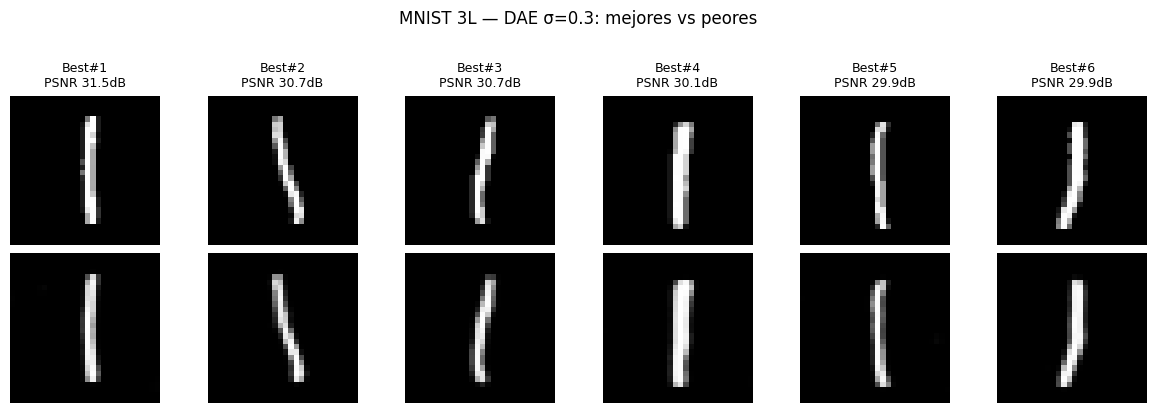

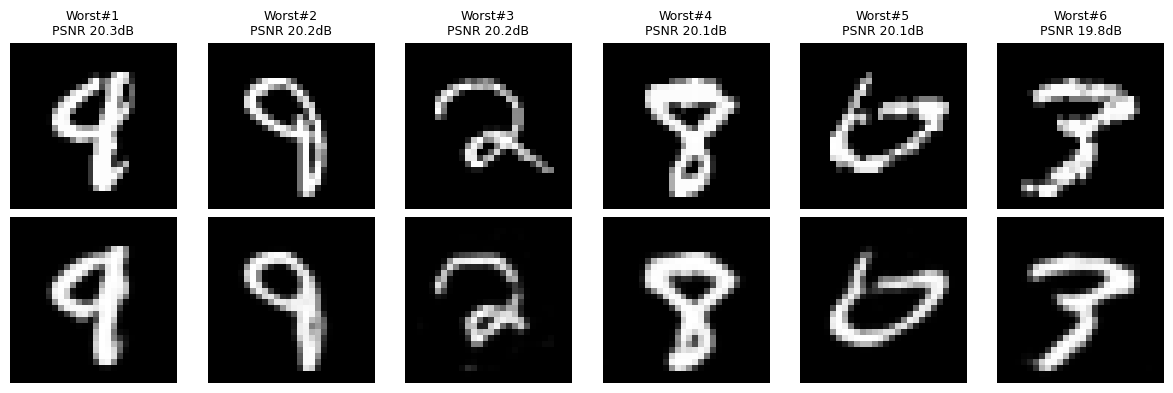

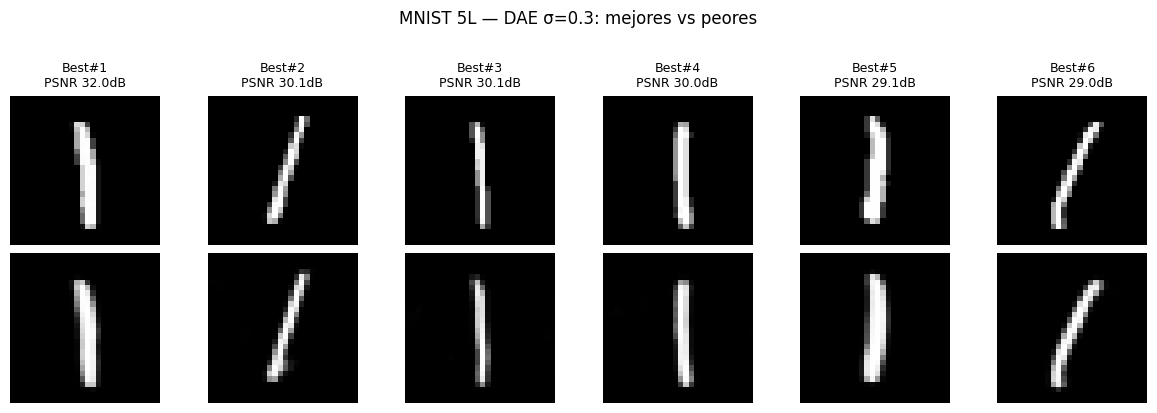

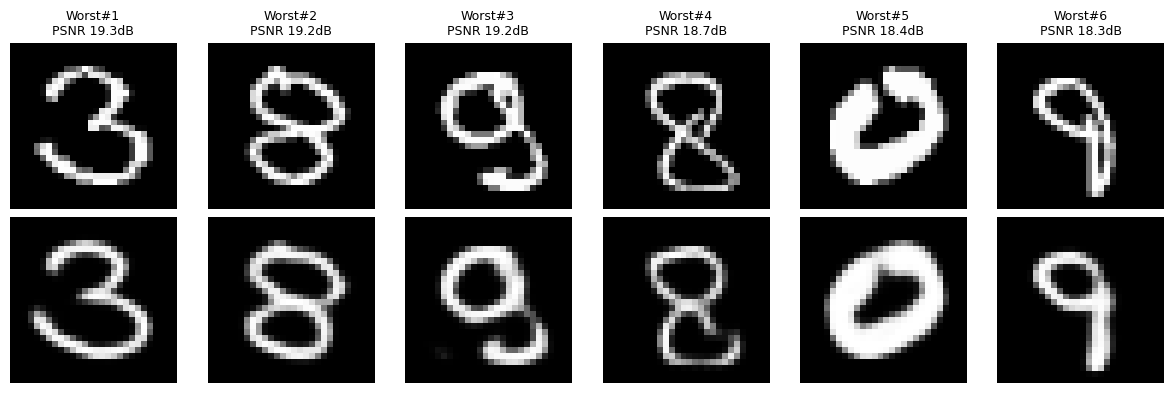

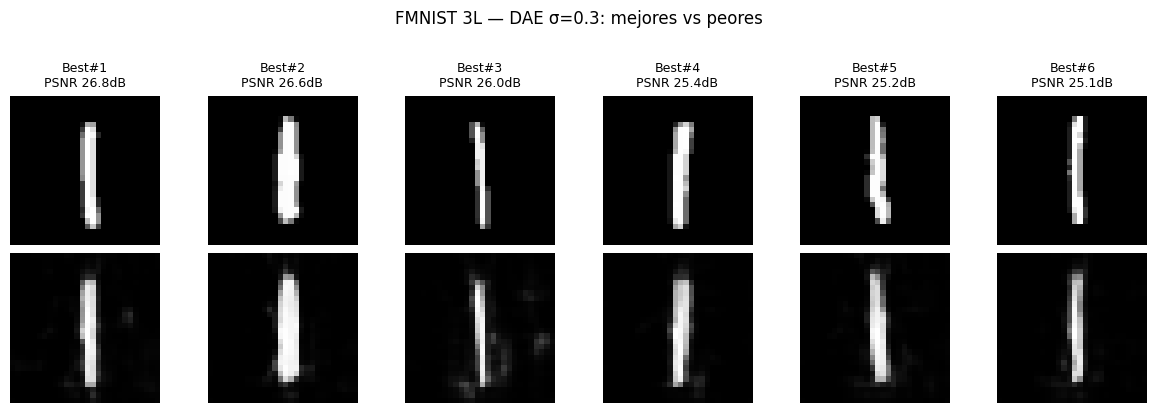

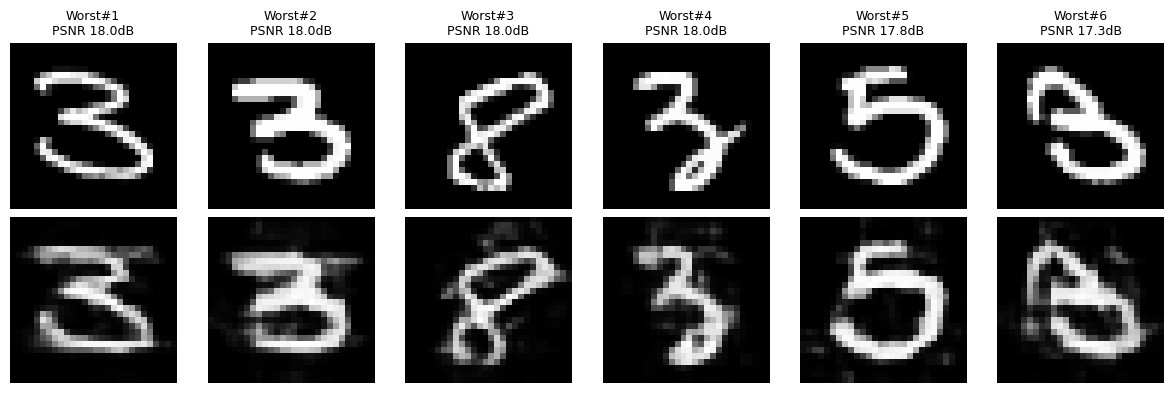

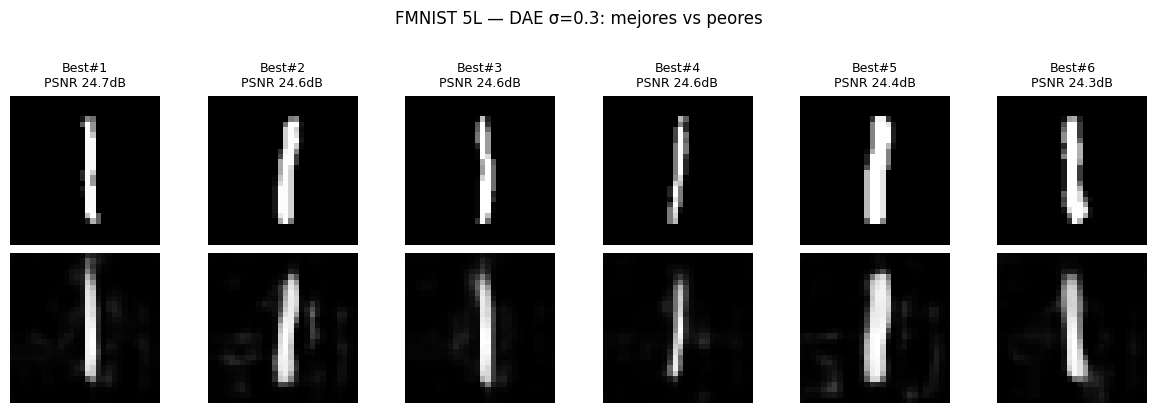

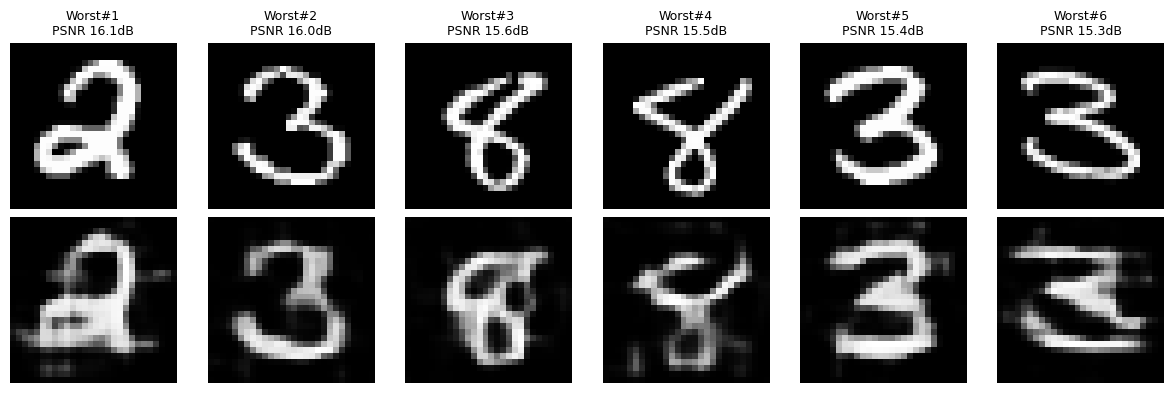

In [38]:
# (b) DAE con ruido (si ya entrenaste el denoising)
sigma_eval = 0.3
records_noisy = collect_psnr_samples(model_dae_mnist_3L, test_loader_mnist, max_samples=512, device=device, noise_sigma=sigma_eval)
show_best_worst(records_noisy, k=6, title=f"MNIST 3L — DAE σ={sigma_eval}: mejores vs peores")

# (b) DAE con ruido (si ya entrenaste el denoising)
sigma_eval = 0.3
records_noisy = collect_psnr_samples(model_dae_mnist_5L, test_loader_mnist, max_samples=512, device=device, noise_sigma=sigma_eval)
show_best_worst(records_noisy, k=6, title=f"MNIST 5L — DAE σ={sigma_eval}: mejores vs peores")

# (b) DAE con ruido (si ya entrenaste el denoising)
sigma_eval = 0.3
records_noisy = collect_psnr_samples(model_dae_fmnist_3L, test_loader_mnist, max_samples=512, device=device, noise_sigma=sigma_eval)
show_best_worst(records_noisy, k=6, title=f"FMNIST 3L — DAE σ={sigma_eval}: mejores vs peores")

# (b) DAE con ruido (si ya entrenaste el denoising)
sigma_eval = 0.3
records_noisy = collect_psnr_samples(model_dae_fmnist_5L, test_loader_mnist, max_samples=512, device=device, noise_sigma=sigma_eval)
show_best_worst(records_noisy, k=6, title=f"FMNIST 5L — DAE σ={sigma_eval}: mejores vs peores")


## Autoencoder MLP

In [65]:
@torch.no_grad()
def evaluate_on_loader(model, test_loader, device):
    model.eval()
    psnr_list = []
    for x, _ in test_loader:
        x = x.to(device)
        x_hat, _ = model(x)
        mse = torch.mean((x_hat - x) ** 2, dim=(1,2,3)).clamp_(min=1e-12)
        psnr = 10.0 * torch.log10(1.0 / mse)
        psnr_list.append(psnr.detach().cpu().numpy())
    psnr_list = np.concatenate(psnr_list, axis=0)
    return float(np.mean(psnr_list)), float(np.std(psnr_list))


In [66]:
import torch.nn as nn
import torch.optim as optim

class MLP_Autoencoder(nn.Module):
    def __init__(self, latent_dim=100, dropout_p=0.0):
        super().__init__()
        self.latent_dim = latent_dim
        dp = dropout_p

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512), nn.ReLU(), nn.Dropout(dp),
            nn.Linear(512, 256),   nn.ReLU(), nn.Dropout(dp),
            nn.Linear(256, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(), nn.Dropout(dp),
            nn.Linear(256, 512),        nn.ReLU(), nn.Dropout(dp),
            nn.Linear(512, 28*28), nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        recon = self.decoder(z).view(x.size(0), 1, 28, 28)
        return recon.clamp(0,1), z

def train_autoencoder_mlp(model, train_loader, val_loader, epochs=30, lr=1e-3, lambda_l1=1e-4,
                          device='cpu', use_scheduler=True, es_patience=6):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=2) if use_scheduler else None

    best_psnr = -1.0; best_state=None; bad=0
    for ep in range(1, epochs+1):
        model.train(); running = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            recon, z = model(x)
            loss = mse(recon, x) + lambda_l1 * torch.mean(torch.abs(z))
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * x.size(0)
        train_loss = running / len(train_loader.dataset)

        model.eval(); vals=[]
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                recon, _ = model(x)
                vals.append(psnr(recon, x).item())
        val_psnr = float(np.mean(vals))

        if sched: sched.step(val_psnr)
        if val_psnr > best_psnr:
            best_psnr = val_psnr
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        print(f"[MLP] Epoch {ep:02d}/{epochs} | Loss: {train_loss:.5f} | PSNR: {val_psnr:.2f} dB (best {best_psnr:.2f})")
        if es_patience is not None and bad >= es_patience:
            print("Early stopping."); break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


In [67]:
from itertools import product

def run_grid(model_ctor, train_fn, train_loader, val_loader, grid_cfg, label_arch, label_dataset, device,
             use_scheduler=True, es_patience=6):
    """
    model_ctor: callable(**kwargs) -> model
    train_fn(model, train_loader, val_loader, epochs, lr, lambda_l1, device, ...)
    grid_cfg: dict con claves ('latent_grid','lr_grid','lambda_grid', ['dropout_grid'], 'epochs')
    """
    latent_grid = grid_cfg['latent_grid']
    lr_grid     = grid_cfg['lr_grid']
    lambda_grid = grid_cfg['lambda_grid']
    epochs      = grid_cfg['epochs']
    dropout_grid = grid_cfg.get('dropout_grid', None)

    if dropout_grid is None:
        combos = list(product(latent_grid, lr_grid, lambda_grid))
    else:
        combos = list(product(latent_grid, lr_grid, lambda_grid, dropout_grid))

    print(f"Total combinaciones {label_dataset}-{label_arch}: {len(combos)}")

    results = []
    best = {"psnr_val": -1.0, "state_dict": None, "cfg": None}

    for i, combo in enumerate(combos, 1):
        if dropout_grid is None:
            latent_dim, lr, lam = combo
            dropout = None
            print(f"\n[{i}/{len(combos)}] {label_dataset} {label_arch} | latent={latent_dim} | lr={lr} | λ={lam} | epochs={epochs}")
            model = model_ctor(latent_dim=latent_dim)
            train_fn(model, train_loader, val_loader, epochs=epochs, lr=lr, lambda_l1=lam,
                     device=device, use_scheduler=True, es_patience=es_patience)
        else:
            latent_dim, lr, lam, dropout = combo
            print(f"\n[{i}/{len(combos)}] {label_dataset} {label_arch} | latent={latent_dim} | lr={lr} | λ={lam} | dropout={dropout} | epochs={epochs}")
            model = model_ctor(latent_dim=latent_dim, dropout_p=dropout)
            train_fn(model, train_loader, val_loader, epochs=epochs, lr=lr, lambda_l1=lam,
                     device=device)  # tus trainers CNN ya imprimen y validan

        # evaluación y logging
        val_psnr = evaluate_on_loader(model, val_loader, device=device)
        res = {
            "arch": label_arch,
            "dataset": label_dataset,
            "latent": latent_dim,
            "lr": lr,
            "lambda_l1": lam,
            "epochs": epochs,
            "psnr_val": val_psnr,
            "params": count_params(model),
            "dropout": (dropout if dropout is not None else 0.0),
        }
        results.append(res)

        if val_psnr > best["psnr_val"]:
            best["psnr_val"] = val_psnr
            best["state_dict"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best["cfg"] = res.copy()
            print(f"  ✔️ Nuevo mejor PSNR ({label_dataset}-{label_arch}): {val_psnr:.2f} dB — cfg={res}")

    df = pd.DataFrame(results).sort_values("psnr_val", ascending=False).reset_index(drop=True)
    return df, best


Entrenamiento

In [68]:
import torch.optim as optim
import numpy as np
from math import log10

def train_autoencoder_mlp(model, train_loader, val_loader,
                                     epochs=30, lr=1e-3, lambda_l1=1e-4, device='cpu',
                                     weight_decay=0.0):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse = nn.MSELoss()

    for epoch in range(1, epochs+1):
        # ---- train ----
        model.train()
        run_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            x_hat, z = model(x)
            loss = mse(x_hat, x) + lambda_l1 * z.abs().mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            run_loss += loss.item() * x.size(0)

        train_loss = run_loss / len(train_loader.dataset)

        # ---- validate (PSNR) ----
        model.eval()
        psnrs = []
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                x_hat, _ = model(x)
                mse_val = torch.mean((x_hat - x)**2, dim=(1,2,3)).clamp_min(1e-12)
                psnr = 10.0 * torch.log10(1.0 / mse_val)
                psnrs.append(psnr.mean().item())

        val_psnr = float(np.mean(psnrs))
        print(f"[MLP] Epoch {epoch:02d}/{epochs} | Loss: {train_loss:.5f} | PSNR: {val_psnr:.2f} dB")

    return model


Ejecucion MNIST y Fashion - MNIST

In [69]:
# === Grid para MLP ===
latent_grid   = [15, 30, 50, 100, 300, 600]
lr_grid       = [1e-3, 1e-4]
lambda_grid   = [0.0, 1e-4, 1e-3]
dropout_grid  = [0.0, 0.1, 0.3]
epochs_grid   = 30  

Total combinaciones MLP-MNIST: 108

[1/108] MLP | latent=15 | lr=0.001 | λL1=0.0 | dropout=0.0 | epochs=30
[MLP] Epoch 01/30 | Loss: 0.04123 | PSNR: 17.10 dB
[MLP] Epoch 02/30 | Loss: 0.01912 | PSNR: 18.80 dB
[MLP] Epoch 03/30 | Loss: 0.01472 | PSNR: 19.65 dB
[MLP] Epoch 04/30 | Loss: 0.01288 | PSNR: 20.06 dB
[MLP] Epoch 05/30 | Loss: 0.01182 | PSNR: 20.37 dB
[MLP] Epoch 06/30 | Loss: 0.01111 | PSNR: 20.58 dB
[MLP] Epoch 07/30 | Loss: 0.01057 | PSNR: 20.78 dB
[MLP] Epoch 08/30 | Loss: 0.01015 | PSNR: 20.90 dB
[MLP] Epoch 09/30 | Loss: 0.00982 | PSNR: 21.00 dB
[MLP] Epoch 10/30 | Loss: 0.00955 | PSNR: 21.08 dB
[MLP] Epoch 11/30 | Loss: 0.00929 | PSNR: 21.19 dB
[MLP] Epoch 12/30 | Loss: 0.00909 | PSNR: 21.33 dB
[MLP] Epoch 13/30 | Loss: 0.00889 | PSNR: 21.33 dB
[MLP] Epoch 14/30 | Loss: 0.00873 | PSNR: 21.33 dB
[MLP] Epoch 15/30 | Loss: 0.00860 | PSNR: 21.46 dB
[MLP] Epoch 16/30 | Loss: 0.00844 | PSNR: 21.50 dB
[MLP] Epoch 17/30 | Loss: 0.00832 | PSNR: 21.52 dB
[MLP] Epoch 18/30 | Loss: 

arch dataset  latent     lr  lambda_l1  dropout  epochs   psnr_val   params  \
0  MLP   MNIST     600  0.001     0.0010      0.0      30  26.078922  1375080   
1  MLP   MNIST     600  0.001     0.0001      0.0      30  25.917772  1375080   
2  MLP   MNIST     300  0.001     0.0010      0.0      30  25.832935  1221180   
3  MLP   MNIST     300  0.001     0.0001      0.0      30  25.697617  1221180   
4  MLP   MNIST     600  0.001     0.0000      0.0      30  25.655163  1375080   
5  MLP   MNIST     300  0.001     0.0000      0.0      30  25.516163  1221180   
6  MLP   MNIST     100  0.001     0.0010      0.0      30  25.335421  1118580   
7  MLP   MNIST     100  0.001     0.0000      0.0      30  25.203369  1118580   
8  MLP   MNIST     100  0.001     0.0001      0.0      30  25.172110  1118580   
9  MLP   MNIST      50  0.001     0.0001      0.0      30  25.035696  1092930   

   train_time_s  
0        109.18  
1        109.89  
2        102.74  
3        104.03  
4        107.01  
5        104.35  
6        100.10  
7        100.69  
8         99.98  
9         99.20

Guardado: grid_mlp_mnist_results.csv


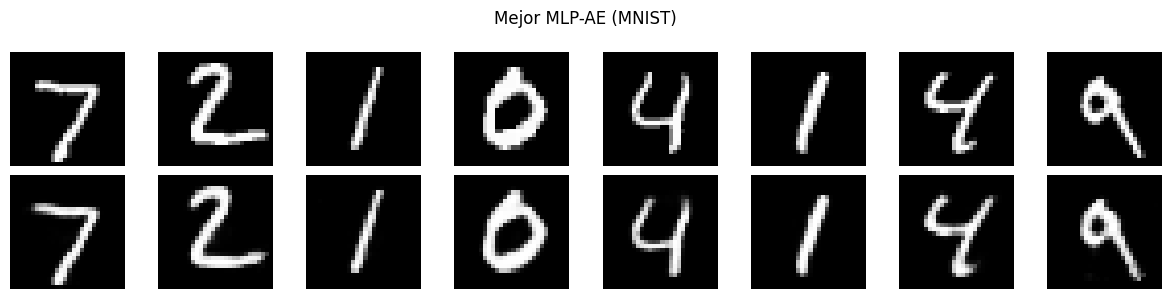

In [ ]:
from itertools import product

results_mlp_mnist = []
best_mlp_mnist = {"psnr_val": -1.0, "state_dict": None, "cfg": None}

combos = list(product(latent_grid, lr_grid, lambda_grid, dropout_grid))
print(f"Total combinaciones MLP-MNIST: {len(combos)}")

for i, (latent_dim, lr, lam, dp) in enumerate(combos, 1):
    print(f"\n[{i}/{len(combos)}] MLP | latent={latent_dim} | lr={lr} | λL1={lam} | dropout={dp} | epochs={epochs_grid}")

    model = MLP_Autoencoder(latent_dim=latent_dim, dropout_p=dp)

    t0 = time.time()
    train_autoencoder_mlp(   
        model,
        train_loader=train_loader_mnist,
        val_loader=test_loader_mnist,
        epochs=epochs_grid,
        lr=lr,
        lambda_l1=lam,
        device=device,
    )
    train_time = time.time() - t0

    psnr_mean, _ = evaluate_on_loader(model, test_loader_mnist, device=device)

    res = {
        "arch": "MLP",
        "dataset": "MNIST",
        "latent": latent_dim,
        "lr": lr,
        "lambda_l1": lam,
        "dropout": dp,
        "epochs": epochs_grid,
        "psnr_val": psnr_mean,
        "params": count_params(model),
        "train_time_s": round(train_time, 2),
    }
    results_mlp_mnist.append(res)

    if psnr_mean > best_mlp_mnist["psnr_val"]:
        best_mlp_mnist["psnr_val"] = psnr_mean
        best_mlp_mnist["state_dict"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_mlp_mnist["cfg"] = res.copy()
        print(f"  ✔️ Nuevo mejor PSNR (MLP-MNIST): {psnr_mean:.2f} dB — cfg={res}")

df_grid_mlp_mnist = pd.DataFrame(results_mlp_mnist).sort_values("psnr_val", ascending=False).reset_index(drop=True)
display(df_grid_mlp_mnist.head(10))
df_grid_mlp_mnist.to_csv("grid_mlp_mnist_results.csv", index=False)
print("Guardado: grid_mlp_mnist_results.csv")

# Instancia el mejor y cárgalo
best_model_mlp_mnist = MLP_Autoencoder(
    latent_dim=best_mlp_mnist["cfg"]["latent"],
    dropout_p=best_mlp_mnist["cfg"]["dropout"]
).to(device)
best_model_mlp_mnist.load_state_dict(best_mlp_mnist["state_dict"])

show_reconstructions_mlp(best_model_mlp_mnist, test_loader_mnist, n=8, device=device, title="Mejor MLP-AE (MNIST)")

In [103]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_grid_mlp_mnist)

arch dataset  latent      lr  lambda_l1  dropout  epochs   psnr_val  \
0    MLP   MNIST     600  0.0010     0.0010      0.0      30  26.078922   
1    MLP   MNIST     600  0.0010     0.0001      0.0      30  25.917772   
2    MLP   MNIST     300  0.0010     0.0010      0.0      30  25.832935   
3    MLP   MNIST     300  0.0010     0.0001      0.0      30  25.697617   
4    MLP   MNIST     600  0.0010     0.0000      0.0      30  25.655163   
5    MLP   MNIST     300  0.0010     0.0000      0.0      30  25.516163   
6    MLP   MNIST     100  0.0010     0.0010      0.0      30  25.335421   
7    MLP   MNIST     100  0.0010     0.0000      0.0      30  25.203369   
8    MLP   MNIST     100  0.0010     0.0001      0.0      30  25.172110   
9    MLP   MNIST      50  0.0010     0.0001      0.0      30  25.035696   
10   MLP   MNIST      50  0.0010     0.0000      0.0      30  25.017595   
11   MLP   MNIST      50  0.0010     0.0010      0.0      30  24.917648   
12   MLP   MNIST      30  0.0010     0.0000      0.0      30  24.109179   
13   MLP   MNIST      30  0.0010     0.0010      0.0      30  24.080044   
14   MLP   MNIST      30  0.0010     0.0001      0.0      30  24.060440   
15   MLP   MNIST     600  0.0001     0.0010      0.0      30  23.540787   
16   MLP   MNIST     600  0.0001     0.0001      0.0      30  23.154398   
17   MLP   MNIST     300  0.0001     0.0010      0.0      30  23.075363   
18   MLP   MNIST     100  0.0001     0.0010      0.0      30  22.703266   
19   MLP   MNIST     300  0.0001     0.0001      0.0      30  22.685741   
20   MLP   MNIST     600  0.0001     0.0000      0.0      30  22.660746   
21   MLP   MNIST     600  0.0010     0.0010      0.1      30  22.578371   
22   MLP   MNIST      50  0.0001     0.0010      0.0      30  22.567352   
23   MLP   MNIST     600  0.0010     0.0001      0.1      30  22.538534   
24   MLP   MNIST     300  0.0010     0.0000      0.1      30  22.508575   
25   MLP   MNIST     300  0.0010     0.0001      0.1      30  22.493944   
26   MLP   MNIST     600  0.0010     0.0000      0.1      30  22.478853   
27   MLP   MNIST     300  0.0010     0.0010      0.1      30  22.478394   
28   MLP   MNIST     100  0.0010     0.0010      0.1      30  22.448603   
29   MLP   MNIST     100  0.0010     0.0000      0.1      30  22.448427   
30   MLP   MNIST     100  0.0001     0.0001      0.0      30  22.419594   
31   MLP   MNIST      50  0.0010     0.0001      0.1      30  22.400356   
32   MLP   MNIST      30  0.0001     0.0010      0.0      30  22.398296   
33   MLP   MNIST     300  0.0001     0.0000      0.0      30  22.382650   
34   MLP   MNIST     100  0.0010     0.0001      0.1      30  22.380806   
35   MLP   MNIST      50  0.0010     0.0010      0.1      30  22.295563   
36   MLP   MNIST      30  0.0010     0.0001      0.1      30  22.247684   
37   MLP   MNIST      50  0.0010     0.0000      0.1      30  22.234783   
38   MLP   MNIST      50  0.0001     0.0001      0.0      30  22.219612   
39   MLP   MNIST      30  0.0010     0.0010      0.1      30  22.154360   
40   MLP   MNIST      30  0.0010     0.0000      0.1      30  22.129509   
41   MLP   MNIST     100  0.0001     0.0000      0.0      30  22.074738   
42   MLP   MNIST      30  0.0001     0.0001      0.0      30  22.062641   
43   MLP   MNIST      15  0.0010     0.0000      0.0      30  21.849470   
44   MLP   MNIST      15  0.0010     0.0001      0.0      30  21.842506   
45   MLP   MNIST      50  0.0001     0.0000      0.0      30  21.820641   
46   MLP   MNIST      15  0.0010     0.0010      0.0      30  21.762547   
47   MLP   MNIST     600  0.0001     0.0010      0.1      30  21.687078   
48   MLP   MNIST     600  0.0001     0.0000      0.1      30  21.652182   
49   MLP   MNIST     600  0.0001     0.0001      0.1      30  21.649784   
50   MLP   MNIST     300  0.0001     0.0010      0.1      30  21.483356   
51   MLP   MNIST     300  0.0001     0.0000      0.1      30  21.480387   
52   MLP   MNIST     300  0.0

GridSearch con MNIST --- MLP
==========================

**Mejor combinación:** `latent=600`, `LR=1e-3`, `dropout=0`, `L1=1e-3` → **PSNR = 26,07 dB**.

Efecto de cada hiperparámetro
-----------------------------

### Dimensión latente

-   Se observa una relación directa entre el tamaño del espacio latente y la calidad de reconstrucción.

-   Con `latent=600` el PSNR se sitúa en **25,6--26,1 dB**; con `300` baja a **25,5--25,8 dB**; con `100` cae a **25,1--25,3 dB**; con `50` ronda **25,0 dB**; con `30` desciende a **~24,1 dB**; y con `15` se reduce a **~21,7--21,8 dB**.

-   Un cuello de botella más amplio preserva más detalle de los dígitos y reduce el error de reconstrucción.

### Learning rate

-   Con **30 épocas**, **`LR=1e-3` supera de forma consistente a `1e-4`** en todas las latentes, con ventajas típicas de **~2--3 dB**.

-   Ejemplo con `latent=600`: **26,07 dB** con `1e-3` frente a **23,54--23,15--22,66 dB** con `1e-4` según la L1.

-   Un paso de optimización mayor permite a un MLP poco profundo alcanzar mejores mínimos en el tiempo de entrenamiento disponible.

### Regularización L1

-   **Efecto positivo y suave** cuando el modelo ya converge bien con `LR=1e-3`.

-   En `latent=600`, pasar de **L1=0** a **L1=1e-4** y a **L1=1e-3** mejora gradualmente el PSNR (**25,65 → 25,91 → 26,07 dB**), lo que indica que una penalización moderada ayuda a estabilizar y a reducir pequeños sobreajustes.

-   Con `LR=1e-4` la L1 puede ordenar ligeramente los resultados, pero el límite real lo marca la falta de convergencia por un paso demasiado bajo.

### Dropout

-   **Perjudica de manera sistemática** la reconstrucción en MLP para MNIST.

-   Con `dropout=0,1`, incluso con latente grande, el PSNR cae a **~22,4--22,6 dB**.

-   Con `dropout=0,3` la degradación es severa: **~19--20,2 dB** en la mayoría de combinaciones.

-   En una tarea determinista de reconstrucción, apagar unidades reduce la capacidad efectiva y borra trazos finos de los dígitos.

Interacciones relevantes
------------------------

-   El **punto dulce** se encuentra en **latente grande** (`600` o `300`) con **`LR=1e-3`** y **sin dropout**; añadir **L1 pequeña** aporta una mejora adicional pero limitada.

-   Combinar **`LR=1e-4` con latente pequeña o con dropout** acumula restricciones y conduce a subentrenamiento y PSNR bajo.

ENTRENAMIENTO EN FMNIST CON MLP

Total combinaciones MLP-MNIST: 108

[1/108] MLP | latent=15 | lr=0.001 | λL1=0.0 | dropout=0.0 | epochs=30
[MLP] Epoch 01/30 | Loss: 0.03231 | PSNR: 17.54 dB
[MLP] Epoch 02/30 | Loss: 0.01804 | PSNR: 18.45 dB
[MLP] Epoch 03/30 | Loss: 0.01547 | PSNR: 19.10 dB
[MLP] Epoch 04/30 | Loss: 0.01400 | PSNR: 19.49 dB
[MLP] Epoch 05/30 | Loss: 0.01309 | PSNR: 19.78 dB
[MLP] Epoch 06/30 | Loss: 0.01245 | PSNR: 19.96 dB
[MLP] Epoch 07/30 | Loss: 0.01194 | PSNR: 20.20 dB
[MLP] Epoch 08/30 | Loss: 0.01155 | PSNR: 20.31 dB
[MLP] Epoch 09/30 | Loss: 0.01124 | PSNR: 20.44 dB
[MLP] Epoch 10/30 | Loss: 0.01098 | PSNR: 20.51 dB
[MLP] Epoch 11/30 | Loss: 0.01080 | PSNR: 20.58 dB
[MLP] Epoch 12/30 | Loss: 0.01062 | PSNR: 20.67 dB
[MLP] Epoch 13/30 | Loss: 0.01050 | PSNR: 20.68 dB
[MLP] Epoch 14/30 | Loss: 0.01037 | PSNR: 20.75 dB
[MLP] Epoch 15/30 | Loss: 0.01028 | PSNR: 20.70 dB
[MLP] Epoch 16/30 | Loss: 0.01018 | PSNR: 20.70 dB
[MLP] Epoch 17/30 | Loss: 0.01009 | PSNR: 20.86 dB
[MLP] Epoch 18/30 | Loss: 

arch dataset  latent     lr  lambda_l1  dropout  epochs   psnr_val   params  \
0  MLP  FMNIST     600  0.001     0.0010      0.0      30  23.327831  1375080   
1  MLP  FMNIST     300  0.001     0.0001      0.0      30  23.182795  1221180   
2  MLP  FMNIST     600  0.001     0.0000      0.0      30  23.161097  1375080   
3  MLP  FMNIST     600  0.001     0.0001      0.0      30  23.159477  1375080   
4  MLP  FMNIST     300  0.001     0.0010      0.0      30  23.128178  1221180   
5  MLP  FMNIST     300  0.001     0.0000      0.0      30  23.065348  1221180   
6  MLP  FMNIST     100  0.001     0.0010      0.0      30  22.935362  1118580   
7  MLP  FMNIST     100  0.001     0.0000      0.0      30  22.860884  1118580   
8  MLP  FMNIST     100  0.001     0.0001      0.0      30  22.849096  1118580   
9  MLP  FMNIST      50  0.001     0.0001      0.0      30  22.609337  1092930   

   train_time_s  
0        110.06  
1        103.78  
2        110.07  
3        110.20  
4        103.73  
5        104.00  
6        100.57  
7        100.78  
8        100.70  
9         97.77

Guardado: grid_mlp_fmnist_results.csv


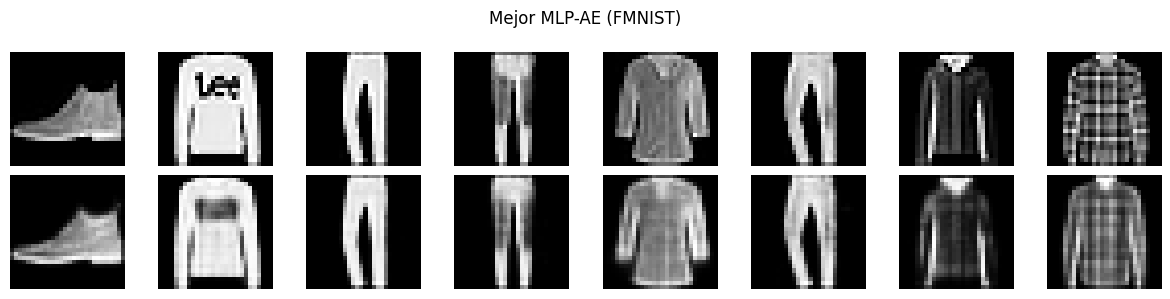

In [75]:
from itertools import product

results_mlp_fmnist = []
best_mlp_fmnist = {"psnr_val": -1.0, "state_dict": None, "cfg": None}

combos = list(product(latent_grid, lr_grid, lambda_grid, dropout_grid))
print(f"Total combinaciones MLP-MNIST: {len(combos)}")

for i, (latent_dim, lr, lam, dp) in enumerate(combos, 1):
    print(f"\n[{i}/{len(combos)}] MLP | latent={latent_dim} | lr={lr} | λL1={lam} | dropout={dp} | epochs={epochs_grid}")

    model = MLP_Autoencoder(latent_dim=latent_dim, dropout_p=dp)

    t0 = time.time()
    train_autoencoder_mlp(   
        model,
        train_loader=train_loader_fmnist,
        val_loader=test_loader_fmnist,
        epochs=epochs_grid,
        lr=lr,
        lambda_l1=lam,
        device=device,
    )
    train_time = time.time() - t0

    psnr_mean, _ = evaluate_on_loader(model, test_loader_fmnist, device=device)

    res = {
        "arch": "MLP",
        "dataset": "FMNIST",
        "latent": latent_dim,
        "lr": lr,
        "lambda_l1": lam,
        "dropout": dp,
        "epochs": epochs_grid,
        "psnr_val": psnr_mean,
        "params": count_params(model),
        "train_time_s": round(train_time, 2),
    }
    results_mlp_fmnist.append(res)

    if psnr_mean > best_mlp_fmnist["psnr_val"]:
        best_mlp_fmnist["psnr_val"] = psnr_mean
        best_mlp_fmnist["state_dict"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_mlp_fmnist["cfg"] = res.copy()
        print(f"  ✔️ Nuevo mejor PSNR (MLP-MNIST): {psnr_mean:.2f} dB — cfg={res}")

df_grid_mlp_fmnist = pd.DataFrame(results_mlp_fmnist).sort_values("psnr_val", ascending=False).reset_index(drop=True)
display(df_grid_mlp_fmnist.head(10))
df_grid_mlp_fmnist.to_csv("grid_mlp_fmnist_results.csv", index=False)
print("Guardado: grid_mlp_fmnist_results.csv")

# Instancia el mejor y cárgalo
best_model_mlp_fmnist = MLP_Autoencoder(
    latent_dim=best_mlp_fmnist["cfg"]["latent"],
    dropout_p=best_mlp_fmnist["cfg"]["dropout"]
).to(device)
best_model_mlp_fmnist.load_state_dict(best_mlp_fmnist["state_dict"])

show_reconstructions_mlp(best_model_mlp_fmnist, test_loader_fmnist, n=8, device=device, title="Mejor MLP-AE (FMNIST)")

In [104]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_grid_mlp_fmnist)

arch dataset  latent      lr  lambda_l1  dropout  epochs   psnr_val  \
0    MLP  FMNIST     600  0.0010     0.0010      0.0      30  23.327831   
1    MLP  FMNIST     300  0.0010     0.0001      0.0      30  23.182795   
2    MLP  FMNIST     600  0.0010     0.0000      0.0      30  23.161097   
3    MLP  FMNIST     600  0.0010     0.0001      0.0      30  23.159477   
4    MLP  FMNIST     300  0.0010     0.0010      0.0      30  23.128178   
5    MLP  FMNIST     300  0.0010     0.0000      0.0      30  23.065348   
6    MLP  FMNIST     100  0.0010     0.0010      0.0      30  22.935362   
7    MLP  FMNIST     100  0.0010     0.0000      0.0      30  22.860884   
8    MLP  FMNIST     100  0.0010     0.0001      0.0      30  22.849096   
9    MLP  FMNIST      50  0.0010     0.0001      0.0      30  22.609337   
10   MLP  FMNIST      50  0.0010     0.0000      0.0      30  22.607319   
11   MLP  FMNIST      50  0.0010     0.0010      0.0      30  22.394449   
12   MLP  FMNIST      30  0.0010     0.0000      0.0      30  22.135832   
13   MLP  FMNIST      30  0.0010     0.0001      0.0      30  22.118816   
14   MLP  FMNIST      30  0.0010     0.0010      0.0      30  22.020607   
15   MLP  FMNIST      15  0.0010     0.0001      0.0      30  21.178724   
16   MLP  FMNIST      15  0.0010     0.0000      0.0      30  21.165651   
17   MLP  FMNIST      15  0.0010     0.0010      0.0      30  21.077631   
18   MLP  FMNIST      50  0.0010     0.0000      0.1      30  21.004126   
19   MLP  FMNIST     100  0.0010     0.0001      0.1      30  21.003195   
20   MLP  FMNIST      30  0.0010     0.0000      0.1      30  21.002821   
21   MLP  FMNIST     100  0.0010     0.0000      0.1      30  20.976166   
22   MLP  FMNIST     600  0.0001     0.0010      0.0      30  20.964600   
23   MLP  FMNIST     100  0.0010     0.0010      0.1      30  20.955362   
24   MLP  FMNIST     600  0.0010     0.0010      0.1      30  20.942327   
25   MLP  FMNIST     300  0.0010     0.0001      0.1      30  20.934748   
26   MLP  FMNIST      50  0.0010     0.0001      0.1      30  20.918232   
27   MLP  FMNIST      30  0.0010     0.0001      0.1      30  20.917135   
28   MLP  FMNIST     600  0.0010     0.0001      0.1      30  20.901863   
29   MLP  FMNIST     300  0.0010     0.0010      0.1      30  20.874853   
30   MLP  FMNIST     600  0.0010     0.0000      0.1      30  20.864344   
31   MLP  FMNIST      50  0.0010     0.0010      0.1      30  20.850798   
32   MLP  FMNIST      30  0.0010     0.0010      0.1      30  20.847937   
33   MLP  FMNIST     300  0.0010     0.0000      0.1      30  20.830446   
34   MLP  FMNIST     300  0.0001     0.0010      0.0      30  20.717176   
35   MLP  FMNIST      15  0.0010     0.0001      0.1      30  20.624559   
36   MLP  FMNIST      15  0.0010     0.0000      0.1      30  20.568754   
37   MLP  FMNIST      50  0.0001     0.0010      0.0      30  20.563389   
38   MLP  FMNIST     100  0.0001     0.0010      0.0      30  20.562496   
39   MLP  FMNIST     600  0.0001     0.0001      0.0      30  20.540148   
40   MLP  FMNIST      15  0.0010     0.0010      0.1      30  20.508791   
41   MLP  FMNIST      30  0.0001     0.0010      0.0      30  20.507706   
42   MLP  FMNIST     300  0.0001     0.0001      0.0      30  20.448713   
43   MLP  FMNIST     100  0.0001     0.0001      0.0      30  20.429649   
44   MLP  FMNIST      50  0.0001     0.0001      0.0      30  20.384544   
45   MLP  FMNIST      30  0.0001     0.0001      0.0      30  20.375902   
46   MLP  FMNIST     600  0.0001     0.0000      0.0      30  20.277922   
47   MLP  FMNIST      15  0.0001     0.0010      0.0      30  20.179585   
48   MLP  FMNIST      15  0.0001     0.0001      0.0      30  20.161537   
49   MLP  FMNIST      50  0.0001     0.0000      0.0      30  20.151236   
50   MLP  FMNIST     600  0.0001     0.0000      0.1      30  20.123449   
51   MLP  FMNIST     300  0.0001     0.0000      0.0      30  20.116867   
52   MLP  FMNIST     600  0.0

GridSearch con FMNIST --- MLP
===========================

**Mejor combinación:** `latent=600`, `LR=1e-3`, `dropout=0`, `L1=1e-3` → **PSNR = 23,32 dB**.

Efecto de cada hiperparámetro
-----------------------------

### Dimensión latente

-   La calidad aumenta al ampliar el espacio latente: **600 > 300 > 100 > 50 > 30 > 15**.

-   Rangos representativos con `LR=1e-3` y sin dropout:

    -   **600:** ~23,15--23,32 dB

    -   **300:** ~23,06--23,18 dB

    -   **100:** ~22,85--22,93 dB

    -   **50:** ~22,39--22,61 dB

    -   **30:** ~22,02--22,14 dB

    -   **15:** ~21,08--21,18 dB

-   Interpretación: un cuello de botella mayor retiene más información de textura y contornos; latentes pequeñas comprimen en exceso y pierden detalle.

### Learning rate

-   Con **30 épocas**, **`LR=1e-3` supera sistemáticamente a `1e-4`** en todos los tamaños latentes, con diferencias típicas de **~2--3 dB**.

-   Razón: con un presupuesto de épocas limitado, un paso mayor acelera la convergencia del MLP y evita quedarse en una zona de alto error.

### Regularización L1

-   **Efecto moderado y positivo** cuando el modelo ya converge con `LR=1e-3`: en `latent=600` se pasa de **23,16 dB (L1=0)** a **23,32 dB (L1=1e-3)**.

-   En latentes medias (`300`) la L1 aporta mejoras pequeñas pero consistentes (~+0,06--0,12 dB).

-   Con `LR=1e-4` su impacto es menor frente al dominante efecto del subentrenamiento.

### Dropout

-   **Perjudica la reconstrucción**:

    -   Con **`dropout=0,1`** el PSNR cae a **~20,9--21,0 dB** incluso con latente grande.

    -   Con **`dropout=0,3`** la degradación es severa (**~18,7--19,6 dB**).

-   Motivo: la tarea es determinista y requiere capacidad estable; apagar neuronas borra señales finas de las prendas (bordes, texturas).

Interacciones relevantes
------------------------

-   El **punto dulce** está en **latente 600 o 300**, **`LR=1e-3`**, **sin dropout** y **L1 suave**.

-   Combinar **`LR=1e-4` con latente pequeña o con dropout** acumula restricciones y reduce notablemente el PSNR.

-   La **L1** ayuda cuando la red ya aprende bien; no compensa un `LR` demasiado bajo.

Comparativa MLP: MNIST vs FMNIST
================================

Panorama general
----------------

-   **MNIST** alcanza **PSNR máximos más altos** que **FMNIST** con la misma arquitectura MLP y el mismo presupuesto de épocas.

-   Diferencia de techo: **26.07 dB (MNIST)** frente a **23.32 dB (FMNIST)** con `latent=600`, `LR=1e-3`, `dropout=0`, `L1≈1e-3`.

-   Motivo principal: **FMNIST** contiene texturas y bordes más complejos (ropa), mientras que **MNIST** son dígitos con contornos más limpios y homogéneos, por lo que **reconstruir FMNIST es intrínsecamente más difícil** para un MLP.

Sensibilidad por hiperparámetros
--------------------------------

### Dimensión latente

-   **Tendencia común:** a mayor latente, mejor PSNR (**600 > 300 > 100 > 50 > 30 > 15**).

-   **Ganancia relativa:** en **MNIST**, pasar de 100→600 añade ~**+1.7 dB**; en **FMNIST**, ~**+0.4--0.5 dB** por salto grande.

-   **Lectura:** MNIST **aprovecha más** el aumento de capacidad; en FMNIST el MLP **satura antes**, señal de que la representación lineal+densa no capta igual de bien las texturas de ropa.

### Learning rate

-   En **ambos datasets**, **`LR=1e-3`** supera consistentemente a **`1e-4`** con 30 épocas.

-   **Efecto es mayor en MNIST** (diferencias típicas ~**+2--3 dB**), mientras que en FMNIST también es claro pero ligeramente **más atenuado**.

-   **Conclusión:** con 30 épocas, el MLP **necesita** `1e-3` para converger; `1e-4` queda subentrenado en ambos, más evidente en MNIST por la mayor cabeza de mejora.

### Regularización L1

-   **Aporta mejoras pequeñas** cuando ya hay buena convergencia (`LR=1e-3`, latente grande) en **ambos**.

-   **MNIST**: L1 puede sumar **~+0.1--0.2 dB** en 600.

-   **FMNIST**: beneficios **similares o menores**; no corrige subentrenamiento ni compensa latentes bajas.

-   **Guía:** usar **L1 suave** como pulido, **no** como palanca principal.

### Dropout

-   **Perjudica en ambos datasets** al ser una tarea de **reconstrucción determinista**:

    -   `0.1` ya reduce ~**3--4 dB** en MNIST y ~**2--3 dB** en FMNIST.

    -   `0.3` degrada severamente (≈**18--20 dB**).

-   **Conclusión:** evitar dropout en MLP para autoencoders de píxel.

Robustez y techo de rendimiento
-------------------------------

-   **MNIST** muestra **mayor margen de mejora** al escalar latente y al usar `LR=1e-3`, alcanzando un techo más alto.

-   **FMNIST** es **más resistente** a aumentos de latente (ganancias menores), lo que sugiere que **harían falta inductivos espaciales** (p. ej., CNN) o más épocas para cerrar la brecha.

Comparativa global: MLP vs CNN (3 capas) vs CNN (5 capas) en MNIST y FMNIST
===========================================================================

1) Mejores resultados alcanzados (PSNR máx.)

-   **MNIST**

    -   **CNN 3 capas:** ~**31.97 dB** ← mejor

    -   **CNN 5 capas:** ~**28.74 dB**

    -   **MLP:** ~**26.07 dB**

-   **FMNIST**

    -   **CNN 3 capas:** ~**28.57 dB** ← mejor

    -   **CNN 5 capas:** ~**24.57 dB**

    -   **MLP:** ~**23.32 dB**

**Conclusión directa:** en ambos datasets la **CNN de 3 capas** supera con margen a la **CNN de 5 capas** y al **MLP**. El MLP queda claramente por detrás. La CNN de 5 capas no capitaliza su mayor profundidad con el presupuesto de épocas usado y termina por debajo de la 3 capas.


2) Lectura por dataset

### MNIST

-   **CNN 3 capas** domina: el sesgo inductivo espacial (convoluciones, pesos compartidos) capta bordes y trazos de dígitos de forma eficiente y con **latentes grandes + LR=1e-3** converge bien en 30--40 épocas.

-   **CNN 5 capas** queda atrás: la mayor profundidad **suaviza** y **dificulta la convergencia** con el mismo número de épocas, perdiendo detalle fino y quedándose ~3 dB por debajo.

-   **MLP** es el último: sin convoluciones debe "aprender" la estructura espacial desde cero; incluso con latente alto rinde ~5--6 dB menos que la mejor CNN 3L.

### FMNIST

-   **CNN 3 capas** vuelve a ser la mejor: las texturas y contornos de ropa se benefician del sesgo espacial de la CNN.

-   **CNN 5 capas** sufre aún más que en MNIST: la profundidad extra **sobregulariza** y **no converge** al mismo ritmo, perdiendo ~4 dB frente a 3L.

-   **MLP** queda cerca de la 5L pero abajo: su falta de inductivo espacial limita la reconstrucción de texturas finas.


3) Sensibilidad a hiperparámetros (comparada)

-   **Dimensión latente**

    -   **Todas** las arquitecturas mejoran al aumentar el latente, pero el **beneficio es mayor en CNN 3L** y en **MNIST**.

    -   En **FMNIST**, las ganancias se atenúan, señal de que hace falta **más inductivo espacial** o **más épocas** para exprimir latentes grandes.

-   **Learning rate**

    -   **`1e-3` > `1e-4`** de forma consistente con el número de épocas usado.

    -   El **impacto es crítico** en **CNN 5L** y **MLP** (subentrenan con `1e-4`).

-   **L1**

    -   **Mejoras pequeñas** cuando ya hay buena convergencia (latente alto, `LR=1e-3`).

    -   Con `LR=1e-4`, L1 **penaliza** al sumar restricción a modelos ya subentrenados.

-   **Dropout**

    -   **Perjudica en todos** (reconstrucción determinista). Caídas pronunciadas ya con **0.1**, severas con **0.3**.

    -   Evitarlo en AE de píxel salvo motivos de regularización muy concretos y con más épocas.


4) Recomendaciones prácticas


-   **Si el objetivo es la mejor PSNR con este presupuesto de entrenamiento:**

    -   Elegir **CNN 3 capas** con **latente grande** y **`LR=1e-3`**, **sin dropout**, **L1 suave**.

-   **Si se desea usar CNN 5 capas:**

    -   Aumentar **épocas**, usar **mejor inicialización/normalización**, y considerar **skip-connections** o **scheduler** para facilitar la convergencia y evitar sobre-suavizado.

-   **Si se mantiene MLP:**

    -   Usar **latente amplio** y **`LR=1e-3`**, sin dropout, y asumir un **techo de rendimiento menor**; para cerrar brecha, cambiar a **CNN** o híbridos (MLP + capas conv. iniciales).

EMBEDDINGS PARA CADA UNO DE LOS MEJORES MLPS

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmat

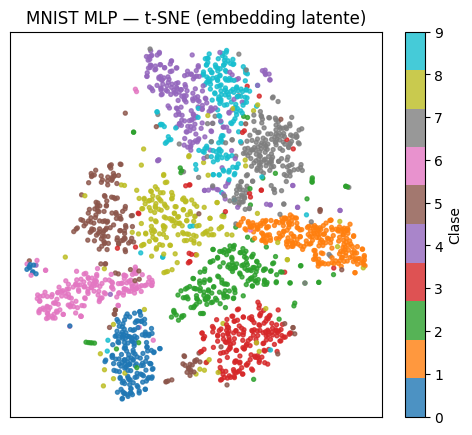

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid val

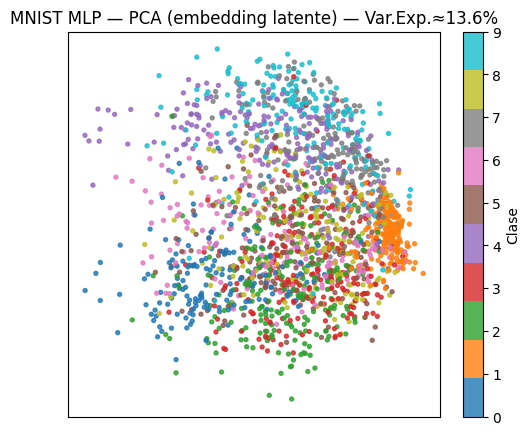

In [110]:
best_model_6 = best_model_mlp_mnist  
Z, y = get_embeddings(best_model_6, test_loader_mnist, max_samples=2000, device=device)

plot_tsne(Z, y, perplexity=30, n_iter=1200, title="MNIST MLP — t-SNE (embedding latente)")
plot_pca(Z, y, title="MNIST MLP — PCA (embedding latente)")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmat

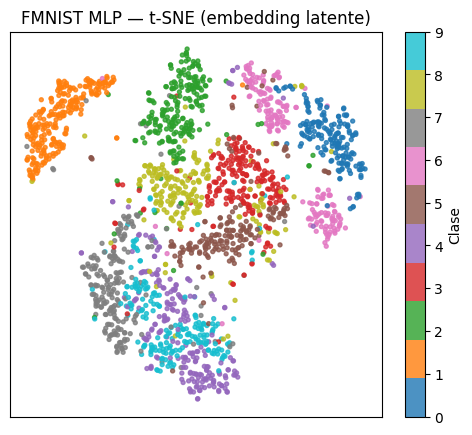

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid val

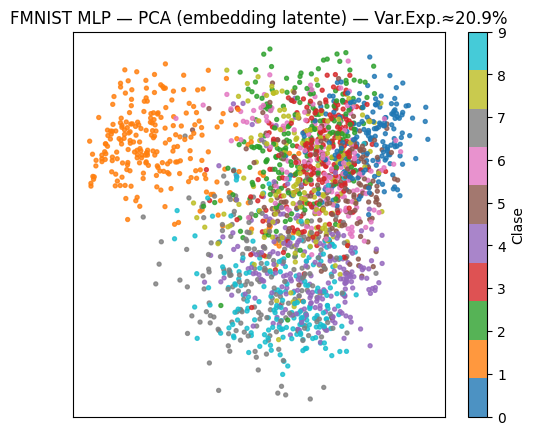

In [111]:
best_model_7 = best_model_mlp_fmnist  
Z, y = get_embeddings(best_model_7, test_loader_mnist, max_samples=2000, device=device)

plot_tsne(Z, y, perplexity=30, n_iter=1200, title="FMNIST MLP — t-SNE (embedding latente)")
plot_pca(Z, y, title="FMNIST MLP — PCA (embedding latente)")

Mostrar las mejores representaciones sin ruido y con ruido

>> Inicializado DAE-MLP con pesos del mejor AE-MLP
[DAE_MNIST_MLP_fromAE_lat600] Epoch 01/15 | TrainLoss=0.01012 | ValPSNR@σ=0.30: 20.72 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 02/15 | TrainLoss=0.00796 | ValPSNR@σ=0.30: 21.10 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 03/15 | TrainLoss=0.00762 | ValPSNR@σ=0.30: 21.14 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 04/15 | TrainLoss=0.00745 | ValPSNR@σ=0.30: 21.29 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 05/15 | TrainLoss=0.00731 | ValPSNR@σ=0.30: 21.38 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 06/15 | TrainLoss=0.00721 | ValPSNR@σ=0.30: 21.40 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 07/15 | TrainLoss=0.00717 | ValPSNR@σ=0.30: 21.41 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 08/15 | TrainLoss=0.00707 | ValPSNR@σ=0.30: 21.45 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 09/15 | TrainLoss=0.00703 | ValPSNR@σ=0.30: 21.39 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 10/15 | TrainLoss=0.00699 | ValPSNR@σ=0.30: 21.44 dB
[DAE_MNIST_MLP_fromAE_lat600] Epoch 11/15 | TrainLoss=0.006

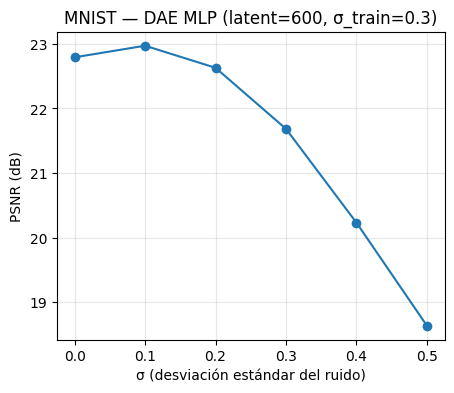

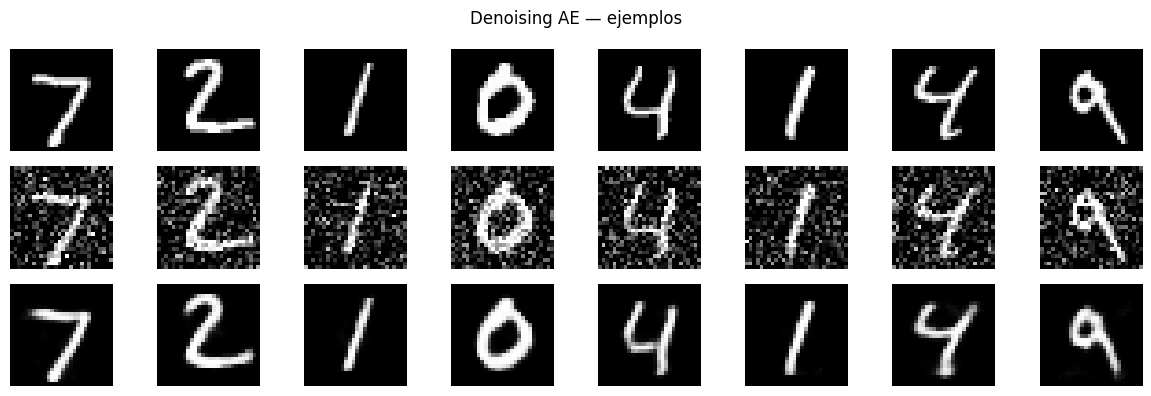

In [117]:
# === DAE desde tu mejor AE-MLP ===
assert 'best_mlp_mnist' in globals() and best_mlp_mnist["state_dict"] is not None, \
       "best_mlp_mnist no definido o sin state_dict."

sigma_train = 0.3
epochs = 15
lr = 1e-3
lambda_l1 = 1e-4

latent_dim_best_MLP_MNIST = best_mlp_mnist["cfg"]["latent"]
dropout_best_MLP_MNIST    = best_mlp_mnist["cfg"]["dropout"]

model_dae_mnist_MLP = MLP_Autoencoder(
    latent_dim=latent_dim_best_MLP_MNIST,
    dropout_p=dropout_best_MLP_MNIST
).to(device)

# Inicializa con los pesos del mejor AE-MLP
model_dae_mnist_MLP.load_state_dict(best_mlp_mnist["state_dict"], strict=True)
print(">> Inicializado DAE-MLP con pesos del mejor AE-MLP")

val_loader_mnist = test_loader_mnist

model_dae_mnist_MLP = train_denoising_autoencoder(
    model=model_dae_mnist_MLP,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=epochs,
    lr=lr,
    lambda_l1=lambda_l1,
    sigma_train=sigma_train,
    device=device,
    name_prefix=f"DAE_MNIST_MLP_fromAE_lat{latent_dim_best_MLP_MNIST}"
)


sigma_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results_mnist_MLP = evaluate_psnr_vs_sigma(model_dae_mnist_MLP, test_loader_mnist, sigma_list, device=device)
print("MNIST (MLP-DAE) — PSNR medios por σ:", results_mnist_MLP)

plot_psnr_vs_sigma(results_mnist_MLP, title=f"MNIST — DAE MLP (latent={latent_dim_best_MLP_MNIST}, σ_train={sigma_train})")

# Ejemplos visuales
show_denoising_examples(model_dae_mnist_MLP, test_loader_mnist, sigma=sigma_train, n=8, device=device)


>> Inicializado DAE-MLP con pesos del mejor AE-MLP
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 01/15 | TrainLoss=0.01195 | ValPSNR@σ=0.30: 19.53 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 02/15 | TrainLoss=0.01063 | ValPSNR@σ=0.30: 19.70 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 03/15 | TrainLoss=0.01036 | ValPSNR@σ=0.30: 19.69 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 04/15 | TrainLoss=0.01024 | ValPSNR@σ=0.30: 19.66 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 05/15 | TrainLoss=0.01012 | ValPSNR@σ=0.30: 19.84 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 06/15 | TrainLoss=0.01008 | ValPSNR@σ=0.30: 19.81 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 07/15 | TrainLoss=0.00996 | ValPSNR@σ=0.30: 19.90 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 08/15 | TrainLoss=0.00995 | ValPSNR@σ=0.30: 19.89 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 09/15 | TrainLoss=0.00992 | ValPSNR@σ=0.30: 19.93 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 10/15 | TrainLoss=0.00986 | ValPSNR@σ=0.30: 19.96 dB
[DAE_FMNIST_MLP_fromAE_lat600] Epoch 11/15 | Trai

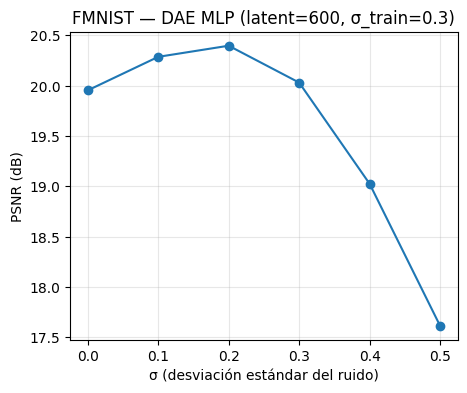

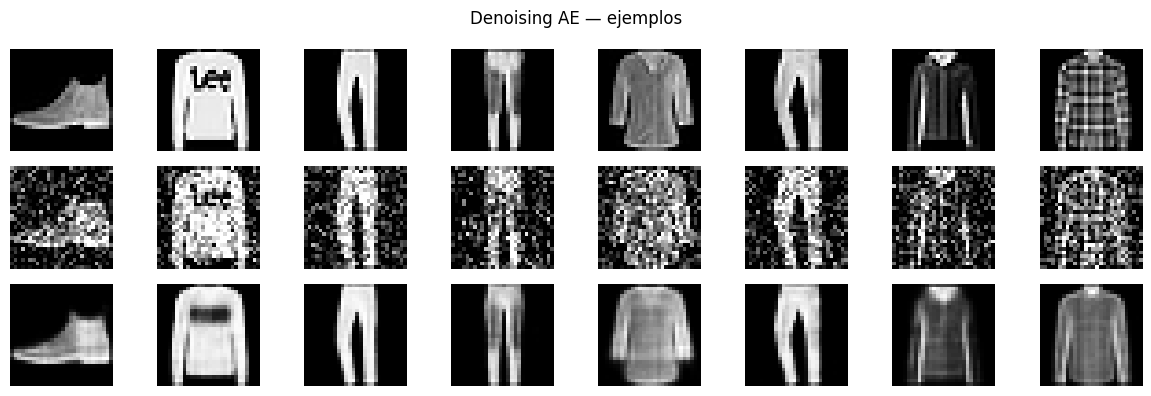

In [118]:
# === DAE desde tu mejor AE-MLP ===
assert 'best_mlp_fmnist' in globals() and best_mlp_fmnist["state_dict"] is not None, \
       "best_mlp_fmnist no definido o sin state_dict."

sigma_train = 0.3
epochs = 15
lr = 1e-3
lambda_l1 = 1e-4

latent_dim_best_MLP_FMNIST = best_mlp_fmnist["cfg"]["latent"]
dropout_best_MLP_FMNIST    = best_mlp_fmnist["cfg"]["dropout"]

model_dae_fmnist_MLP = MLP_Autoencoder(
    latent_dim=latent_dim_best_MLP_FMNIST,
    dropout_p=dropout_best_MLP_FMNIST
).to(device)

# Inicializa con los pesos del mejor AE-MLP
model_dae_fmnist_MLP.load_state_dict(best_mlp_fmnist["state_dict"], strict=True)
print(">> Inicializado DAE-MLP con pesos del mejor AE-MLP")

val_loader_mnist = test_loader_fmnist

model_dae_fmnist_MLP = train_denoising_autoencoder(
    model=model_dae_fmnist_MLP,
    train_loader=train_loader_fmnist,
    val_loader=val_loader_fmnist,
    epochs=epochs,
    lr=lr,
    lambda_l1=lambda_l1,
    sigma_train=sigma_train,
    device=device,
    name_prefix=f"DAE_FMNIST_MLP_fromAE_lat{latent_dim_best_MLP_FMNIST}"
)


sigma_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results_fmnist_MLP = evaluate_psnr_vs_sigma(model_dae_fmnist_MLP, test_loader_fmnist, sigma_list, device=device)
print("FMNIST (MLP-DAE) — PSNR medios por σ:", results_fmnist_MLP)

plot_psnr_vs_sigma(results_fmnist_MLP, title=f"FMNIST — DAE MLP (latent={latent_dim_best_MLP_FMNIST}, σ_train={sigma_train})")

# Ejemplos visuales
show_denoising_examples(model_dae_fmnist_MLP, test_loader_fmnist, sigma=sigma_train, n=8, device=device)


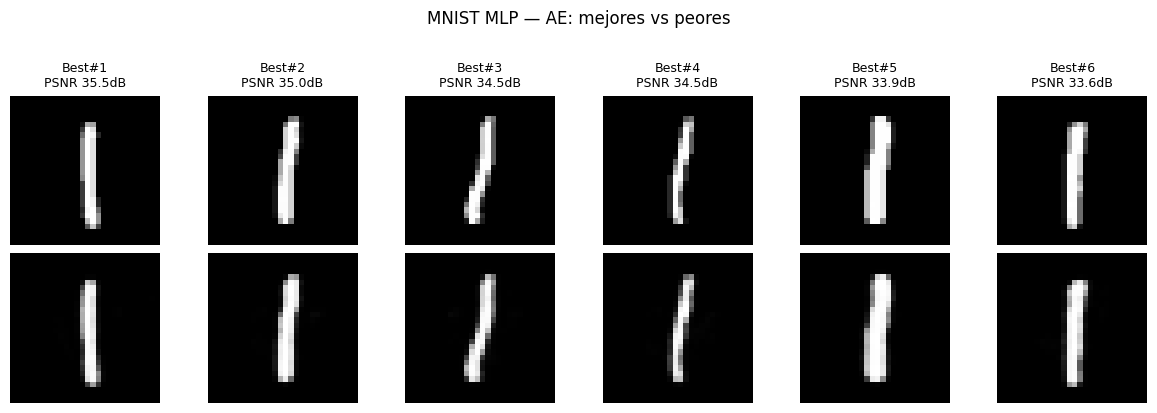

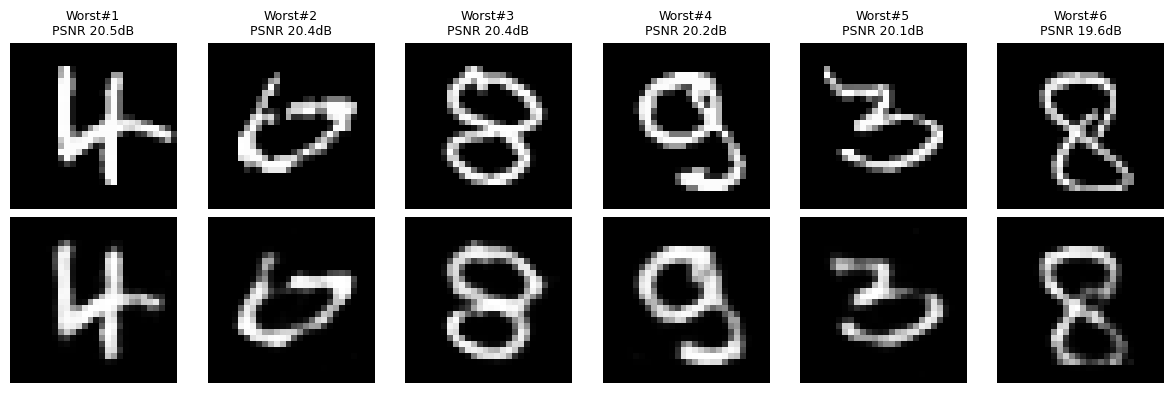

In [112]:
# a) sin ruido
records_clean = collect_psnr_samples(best_model_6, test_loader_mnist, max_samples=512, device=device, noise_sigma=None)
show_best_worst(records_clean, k=6, title="MNIST MLP — AE: mejores vs peores")

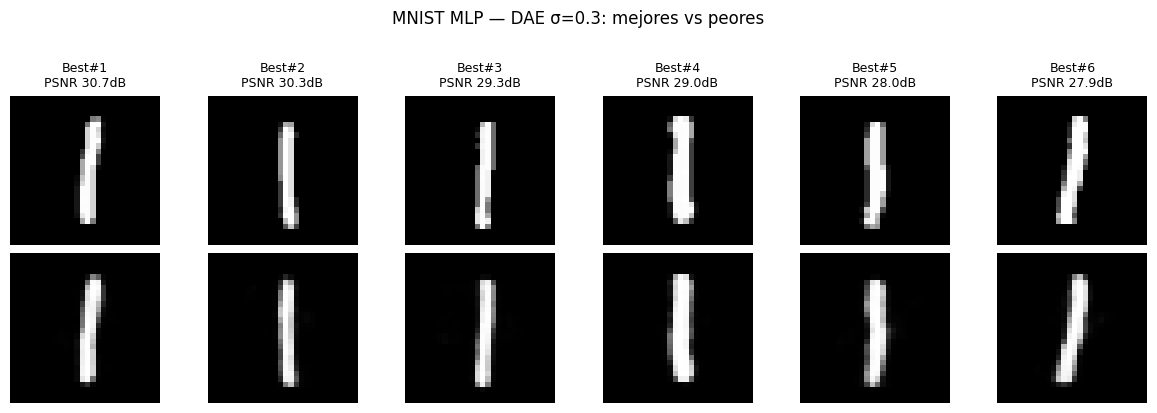

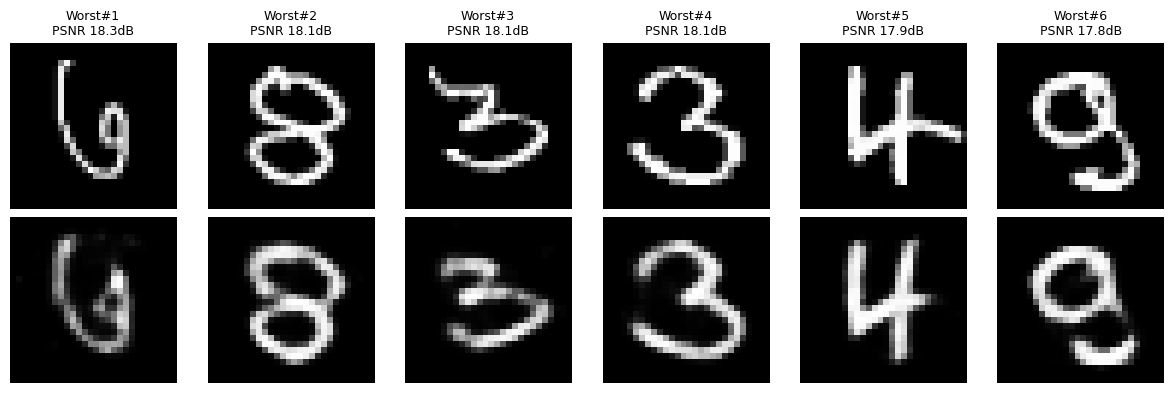

In [119]:
# b) con ruido σ=0.3    
sigma_eval = 0.3
records_noisy = collect_psnr_samples(model_dae_mnist_MLP, test_loader_mnist, max_samples=512, device=device, noise_sigma=sigma_eval)
show_best_worst(records_noisy, k=6, title=f"MNIST MLP — DAE σ={sigma_eval}: mejores vs peores")

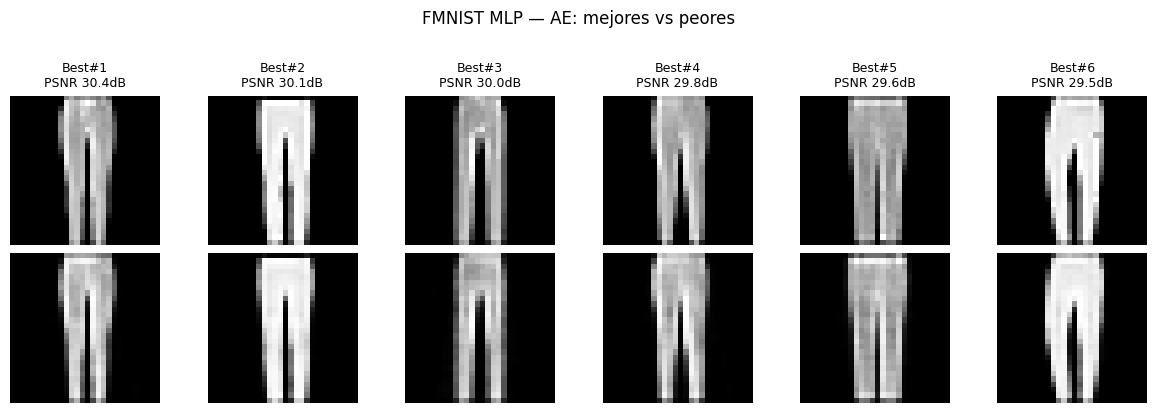

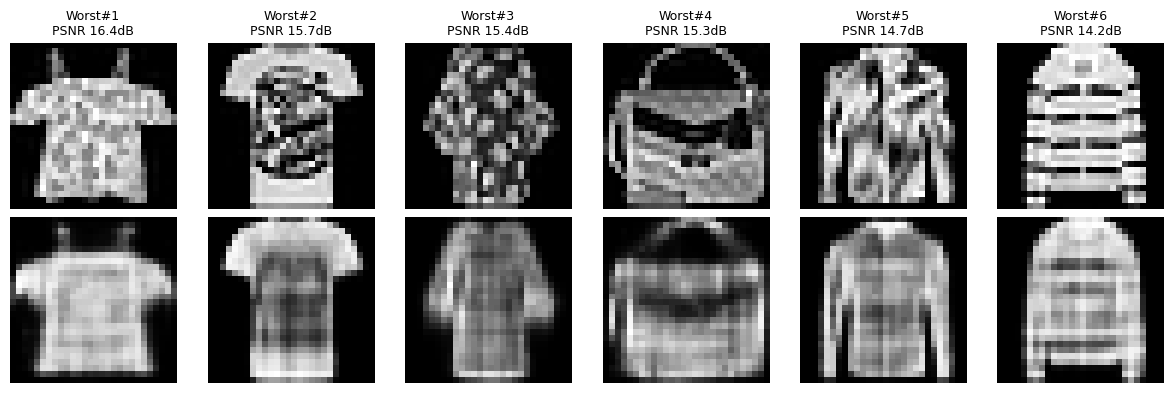

In [115]:
# a) sin ruido
records_clean = collect_psnr_samples(best_model_7, test_loader_fmnist, max_samples=512, device=device, noise_sigma=None)
show_best_worst(records_clean, k=6, title="FMNIST MLP — AE: mejores vs peores")

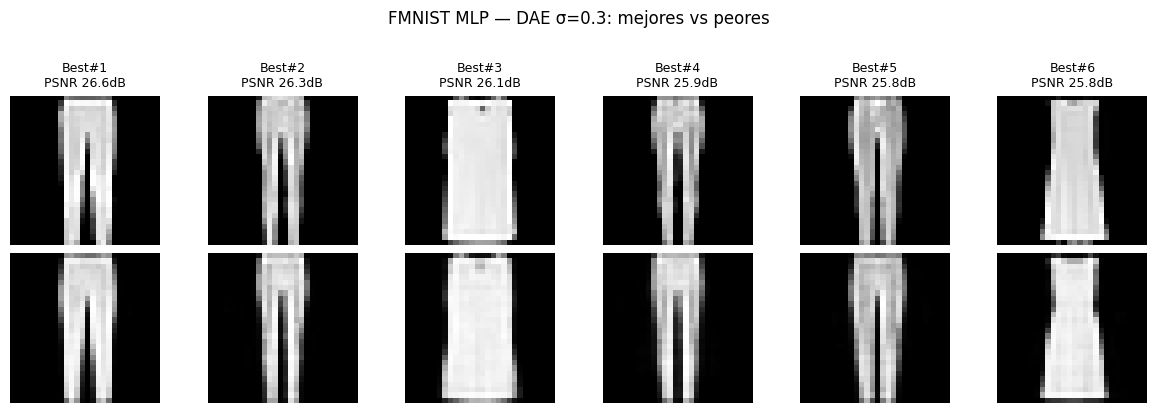

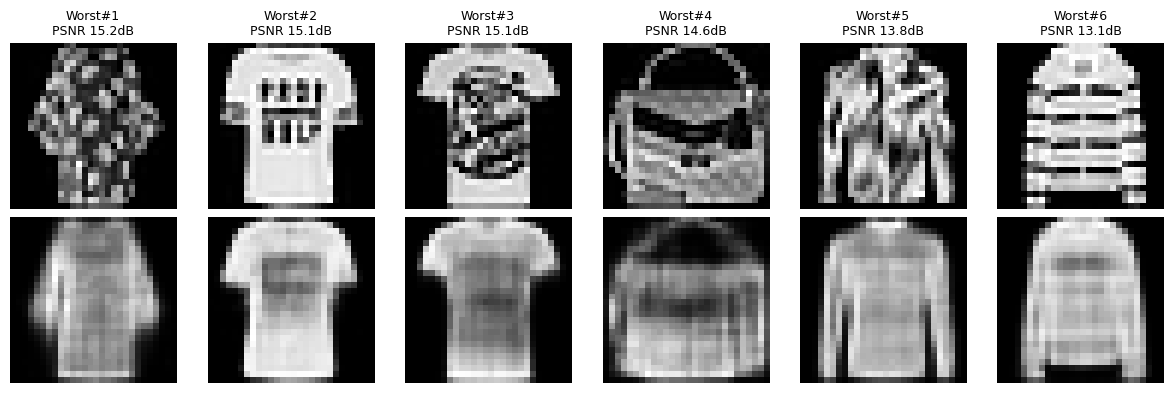

In [120]:
# b) con ruido σ=0.3    
sigma_eval = 0.3
records_noisy = collect_psnr_samples(model_dae_fmnist_MLP, test_loader_fmnist, max_samples=512, device=device, noise_sigma=sigma_eval)
show_best_worst(records_noisy, k=6, title=f"FMNIST MLP — DAE σ={sigma_eval}: mejores vs peores")

Visualizaciones

In [82]:
@torch.no_grad()
def show_reconstructions_mlp(model, data_loader, n=8, device=device, title="Reconstrucciones MLP-AE"):
    model.eval()
    x, _ = next(iter(data_loader))
    x = x[:n].to(device)
    recon, _ = model(x)
    x = x.cpu(); recon = recon.cpu()

    plt.figure(figsize=(12,3))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(x[i,0], cmap='gray'); plt.axis('off')
        if i == 0: plt.ylabel("Original")
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i,0], cmap='gray'); plt.axis('off')
        if i == 0: plt.ylabel("Reconstruida")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



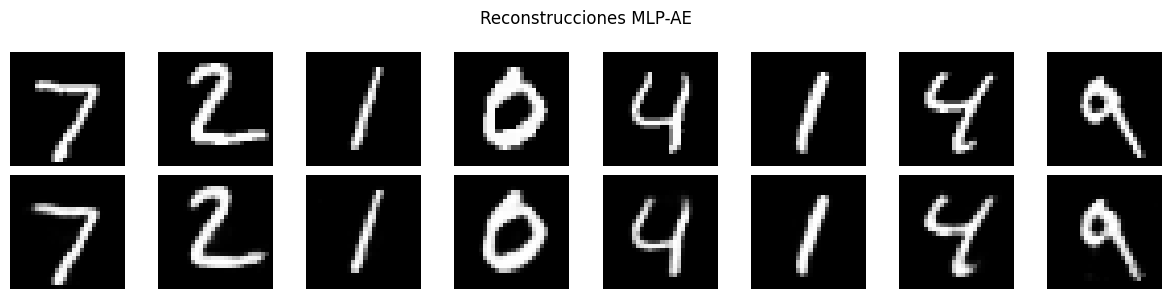

In [83]:
# Ejemplo con el mejor MLP-AE en MNIST:
show_reconstructions_mlp(best_model_mlp_mnist, test_loader_mnist, n=8, device=device)

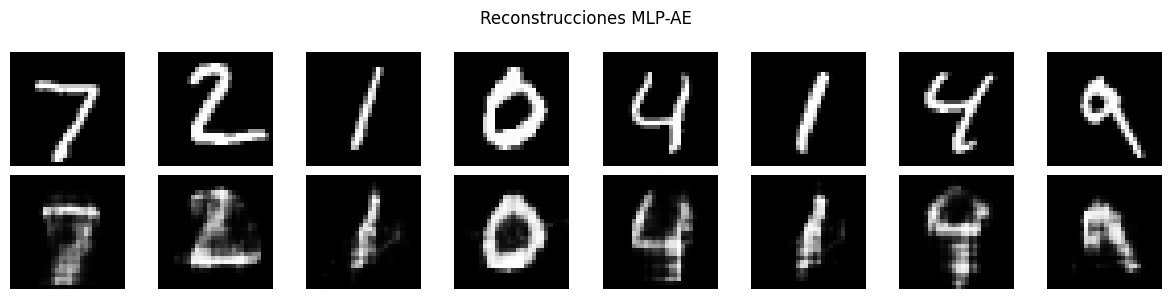

In [84]:
# Ejemplo con el mejor MLP-AE en FMNIST:
show_reconstructions_mlp(best_model_mlp_fmnist, test_loader_mnist, n=8, device=device)

## Entrenamiento con MNIST y test con FMNIST y viceversa

Helper de evaluacion

In [85]:
import torch
import numpy as np

@torch.no_grad()
def evaluate_on_loader(model, test_loader, device):
    model.eval()
    psnr_list = []
    for x, _ in test_loader:
        x = x.to(device)
        x_hat, _ = model(x)
        mse = torch.mean((x_hat - x) ** 2, dim=(1,2,3)).clamp_(min=1e-12)
        psnr = 10.0 * torch.log10(1.0 / mse)
        psnr_list.append(psnr.detach().cpu().numpy())
    psnr_list = np.concatenate(psnr_list, axis=0)
    return float(np.mean(psnr_list)), float(np.std(psnr_list))

def build_model_from_best(best_dict, ModelCls):
    """
    Crea el modelo con los hiperparámetros del mejor experimento.
    Si hay 'dropout' en cfg, lo pasa como dropout_p (CNN). Para MLP, se ignora.
    """
    assert best_dict is not None and "cfg" in best_dict, "best_dict inválido"
    cfg = best_dict["cfg"]
    kwargs = {"latent_dim": cfg["latent"]}
    if "dropout" in cfg:
        kwargs["dropout_p"] = cfg["dropout"]
    model = ModelCls(**kwargs)
    return model


Funcion para entrenar con un dataset y testear con otro

In [86]:
def cross_dataset_eval_from_best(
    best_dict,
    ModelCls,
    device,
    train_loader_src,
    test_loader_src,
    test_loader_tgt,
    epochs=10,
    lr=1e-3,
    l1_lambda=1e-4,
    start_from_pretrained=True,
    save_ckpt_path=None
):
    """
    Instancia el modelo con la mejor configuración encontrada (best_dict['cfg']),
    opcionalmente carga sus pesos (best_dict['state_dict']) y entrena en SRC.
    Luego evalúa PSNR medio±std en SRC y TGT.
    """
    model = build_model_from_best(best_dict, ModelCls).to(device)

    # Opcional: arrancar desde el mejor AE (pre-entrenado)
    if start_from_pretrained and best_dict.get("state_dict") is not None:
        model.load_state_dict(best_dict["state_dict"])
        print(">> Inicializado desde pesos del mejor AE")

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train()
        for x, _ in train_loader_src:
            x = x.to(device)
            x_hat, z = model(x)
            loss = torch.nn.functional.mse_loss(x_hat, x)
            if l1_lambda > 0:
                loss = loss + l1_lambda * z.abs().mean()
            opt.zero_grad()
            loss.backward()
            opt.step()

    if save_ckpt_path:
        torch.save({'state_dict': model.state_dict(),
                    'latent_dim': best_dict['cfg']['latent'],
                    'cfg': best_dict['cfg']}, save_ckpt_path)

    psnr_src_mean, psnr_src_std = evaluate_on_loader(model, test_loader_src, device)
    psnr_tgt_mean, psnr_tgt_std = evaluate_on_loader(model, test_loader_tgt, device)

    print(f"[Cross] PSNR SRC: {psnr_src_mean:.2f}±{psnr_src_std:.2f} | "
          f"PSNR TGT: {psnr_tgt_mean:.2f}±{psnr_tgt_std:.2f}")

    return {
        'psnr_src_mean': psnr_src_mean, 'psnr_src_std': psnr_src_std,
        'psnr_tgt_mean': psnr_tgt_mean, 'psnr_tgt_std': psnr_tgt_std
    }


Ejecuciones

In [87]:
# Hiperparámetros comunes
epochs = 30
lr = 1e-3
l1_lambda = 1e-4
use_pretrained = True  

In [91]:
print("Caso A) SRC=MNIST → TGT=FMNIST | CNN-3L (mejor MNIST-3L)")
res_mnist_to_fmnist_3L = cross_dataset_eval_from_best(
    best_dict=best_3L,   # ← diccionario con 'cfg' y 'state_dict'
    ModelCls=ConvAutoencoder_3L,
    device=device,
    train_loader_src=train_loader_mnist,
    test_loader_src=test_loader_mnist,
    test_loader_tgt=test_loader_fmnist,
    epochs=epochs, lr=lr, l1_lambda=l1_lambda,
    start_from_pretrained=use_pretrained
)



print("Caso B) SRC=FMNIST → TGT=MNIST | CNN-3L (mejor FMNIST-3L)")
res_fmnist_to_mnist_3L = cross_dataset_eval_from_best(
    best_dict=best_fmnist_3L,                # mejor de FMNIST-3L
    ModelCls=ConvAutoencoder_3L,
    device=device,
    train_loader_src=train_loader_fmnist,
    test_loader_src=test_loader_fmnist,
    test_loader_tgt=test_loader_mnist,
    epochs=epochs, lr=lr, l1_lambda=l1_lambda,
    start_from_pretrained=use_pretrained
)

print("Caso C) SRC=MNIST → TGT=FMNIST | CNN-5L (mejor MNIST-5L)")
res_mnist_to_fmnist_5L = cross_dataset_eval_from_best(
    best_dict=best_5L,                 # mejor de MNIST-5L
    ModelCls=ConvAutoencoder_5L,
    device=device,
    train_loader_src=train_loader_mnist,
    test_loader_src=test_loader_mnist,
    test_loader_tgt=test_loader_fmnist,
    epochs=epochs, lr=lr, l1_lambda=l1_lambda,
    start_from_pretrained=use_pretrained
)

print("Caso D) SRC=FMNIST → TGT=MNIST | CNN-5L (mejor FMNIST-5L)")
res_fmnist_to_mnist_5L = cross_dataset_eval_from_best(
    best_dict=best_fmnist_5L,                # mejor de FMNIST-5L
    ModelCls=ConvAutoencoder_5L,
    device=device,
    train_loader_src=train_loader_fmnist,
    test_loader_src=test_loader_fmnist,
    test_loader_tgt=test_loader_mnist,
    epochs=epochs, lr=lr, l1_lambda=l1_lambda,
    start_from_pretrained=use_pretrained
)


Caso A) SRC=MNIST → TGT=FMNIST | CNN-3L (mejor MNIST-3L)
>> Inicializado desde pesos del mejor AE
[Cross] PSNR SRC: 34.68±2.46 | PSNR TGT: 18.43±2.48
Caso B) SRC=FMNIST → TGT=MNIST | CNN-3L (mejor FMNIST-3L)
>> Inicializado desde pesos del mejor AE
[Cross] PSNR SRC: 31.95±2.82 | PSNR TGT: 32.31±1.95
Caso C) SRC=MNIST → TGT=FMNIST | CNN-5L (mejor MNIST-5L)
>> Inicializado desde pesos del mejor AE
[Cross] PSNR SRC: 29.95±2.33 | PSNR TGT: 15.52±2.47
Caso D) SRC=FMNIST → TGT=MNIST | CNN-5L (mejor FMNIST-5L)
>> Inicializado desde pesos del mejor AE
[Cross] PSNR SRC: 27.22±3.05 | PSNR TGT: 24.91±1.95


In [92]:
print("Caso E) SRC=MNIST → TGT=FMNIST | MLP (mejor MLP-MNIST)")
res_mnist_to_fmnist_mlp = cross_dataset_eval_from_best(
    best_dict=best_mlp_mnist,                # mejor de MLP en MNIST
    ModelCls=MLP_Autoencoder,
    device=device,
    train_loader_src=train_loader_mnist,
    test_loader_src=test_loader_mnist,
    test_loader_tgt=test_loader_fmnist,
    epochs=epochs, lr=lr, l1_lambda=l1_lambda,
    start_from_pretrained=use_pretrained
)

print("Caso F) SRC=FMNIST → TGT=MNIST | MLP (mejor MLP-FMNIST)")
res_fmnist_to_mnist_mlp = cross_dataset_eval_from_best(
    best_dict=best_mlp_fmnist,               # mejor de MLP en FMNIST
    ModelCls=MLP_Autoencoder,
    device=device,
    train_loader_src=train_loader_fmnist,
    test_loader_src=test_loader_fmnist,
    test_loader_tgt=test_loader_mnist,
    epochs=epochs, lr=lr, l1_lambda=l1_lambda,
    start_from_pretrained=use_pretrained
)


Caso E) SRC=MNIST → TGT=FMNIST | MLP (mejor MLP-MNIST)
>> Inicializado desde pesos del mejor AE
[Cross] PSNR SRC: 27.41±2.56 | PSNR TGT: 12.00±3.07
Caso F) SRC=FMNIST → TGT=MNIST | MLP (mejor MLP-FMNIST)
>> Inicializado desde pesos del mejor AE
[Cross] PSNR SRC: 24.41±3.21 | PSNR TGT: 18.15±1.85


## Usar el decoder como generador (invertir el flujo) 

In [93]:
import types
import torch
import torch.nn.functional as F

def attach_encode_decode(model):
    """
    Añade métodos .encode(x) y .decode(z) al modelo sin modificar su clase original.
    Soporta:
      - CNN (tus ConvAutoencoder_3L/5L): usa encoder -> flatten -> fc_enc y fc_dec -> reshape -> decoder
      - MLP (tu MLP_Autoencoder): flatten -> encoder y decoder -> reshape (1,28,28)
    Requisitos:
      - Para CNN: atributos encoder, flatten, fc_enc, fc_dec, decoder, shape_before_fc, latent_dim
      - Para MLP: atributos encoder, decoder, latent_dim
    """

    # --- encode ---
    def _encode(self, x):
        if hasattr(self, "fc_enc") and hasattr(self, "flatten"):
            # CNN
            h = self.encoder(x)
            h = self.flatten(h)
            z = self.fc_enc(h)
            return z
        else:
            # MLP: aplanar y pasar por encoder (Linear)
            x_flat = x.view(x.size(0), -1)
            z = self.encoder(x_flat)
            return z

    # --- decode ---
    def _decode(self, z):
        if hasattr(self, "fc_dec") and hasattr(self, "shape_before_fc"):
            # CNN
            h = self.fc_dec(z)
            h = h.view(z.size(0), *self.shape_before_fc)  # p.ej. (B, C, H, W)
            x = self.decoder(h)
            # Asegura 28x28 (por si tu decoder sale 32x32 en alguna config)
            if x.shape[-2:] != (28, 28):
                # mejor recorte central que interpolación para muestras
                H, W = x.shape[-2:]
                off_h = max((H - 28) // 2, 0)
                off_w = max((W - 28) // 2, 0)
                x = x[..., off_h:off_h+28, off_w:off_w+28]
            return x.clamp(0, 1)
        else:
            # MLP
            x_flat = self.decoder(z)                        # (B, 28*28) tras Sigmoid
            x = x_flat.view(z.size(0), 1, 28, 28)
            return x.clamp(0, 1)

    model.encode = types.MethodType(_encode, model)
    model.decode = types.MethodType(_decode, model)
    return model


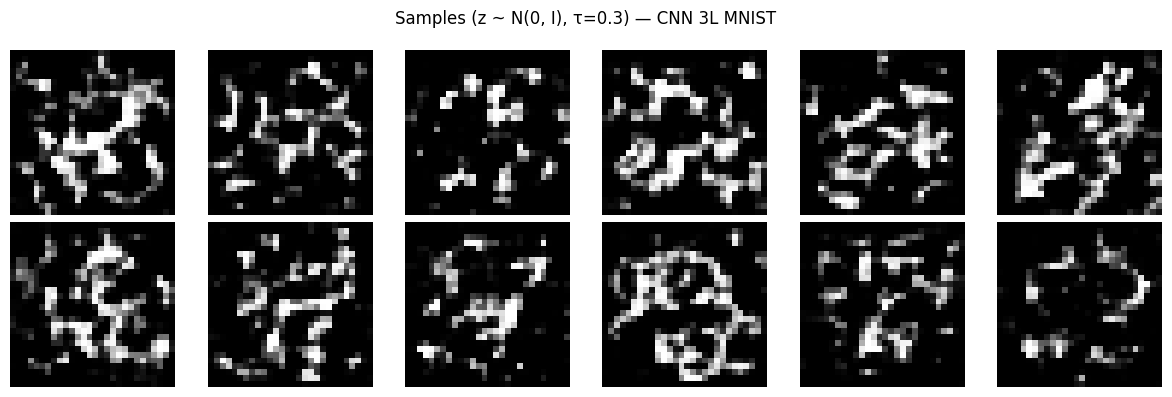

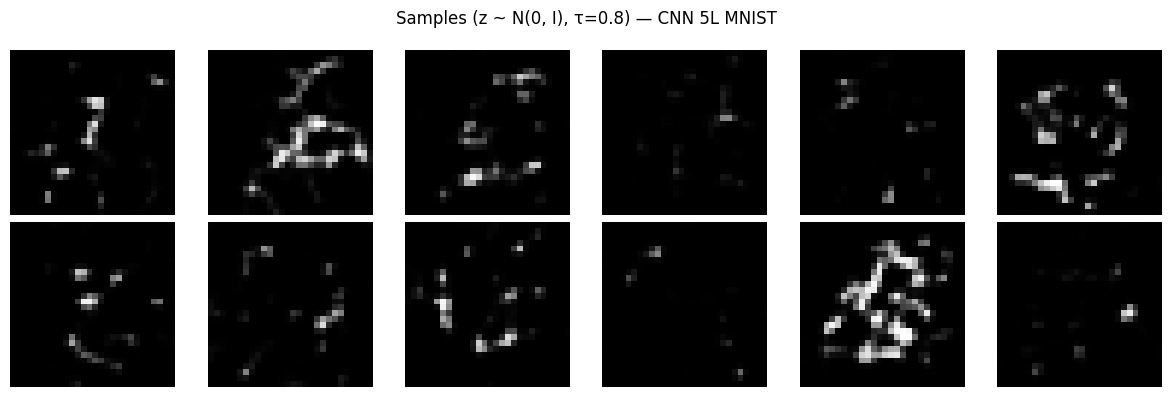

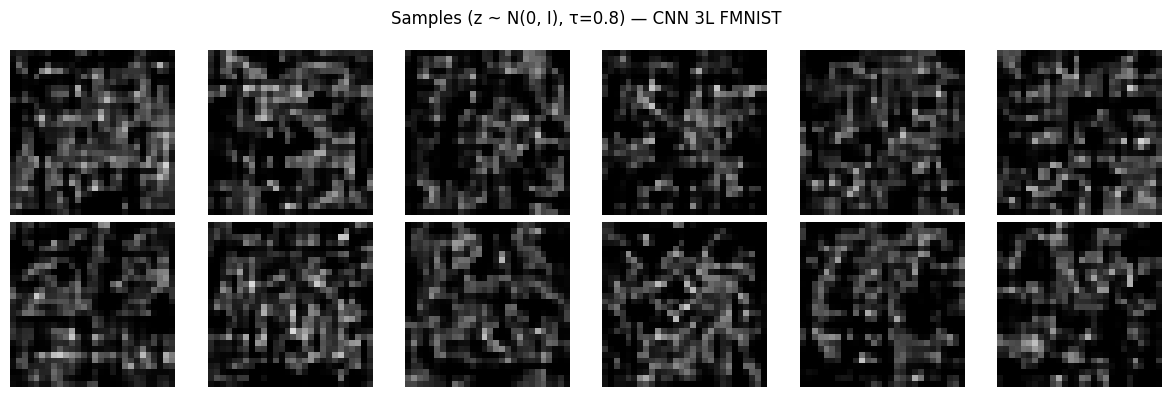

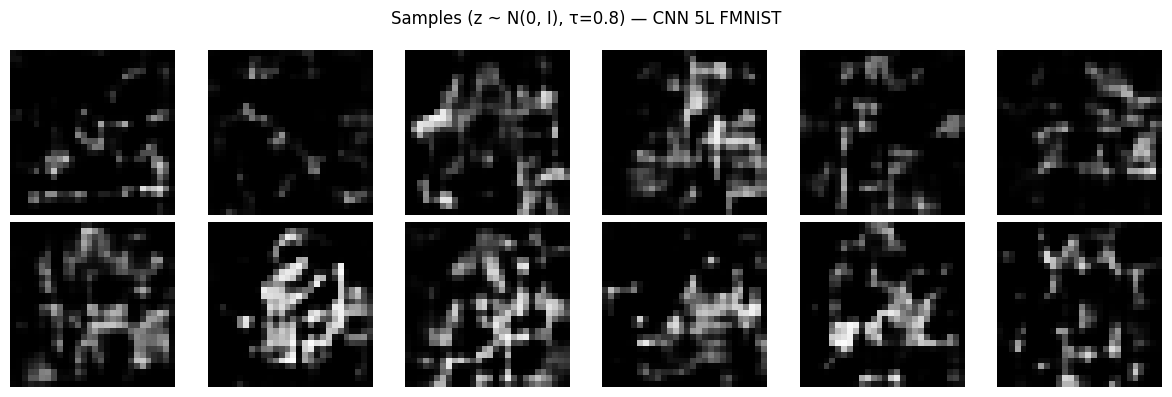

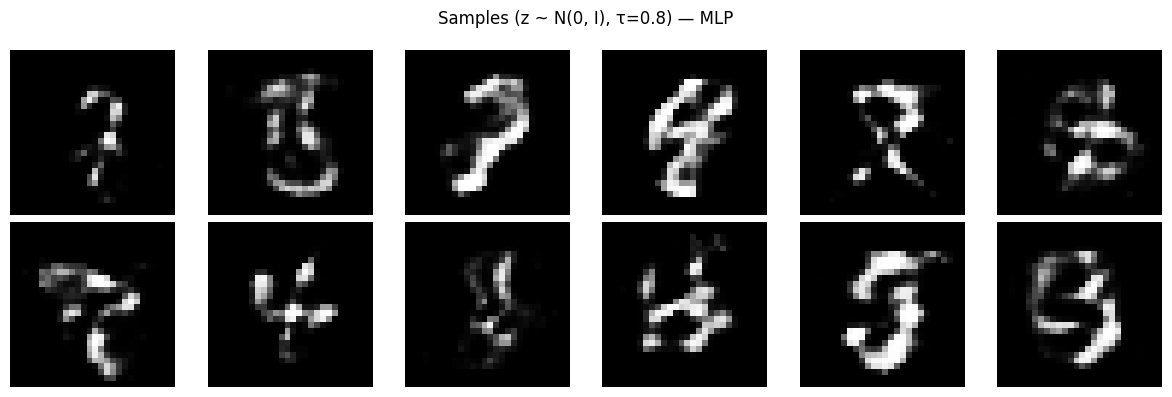

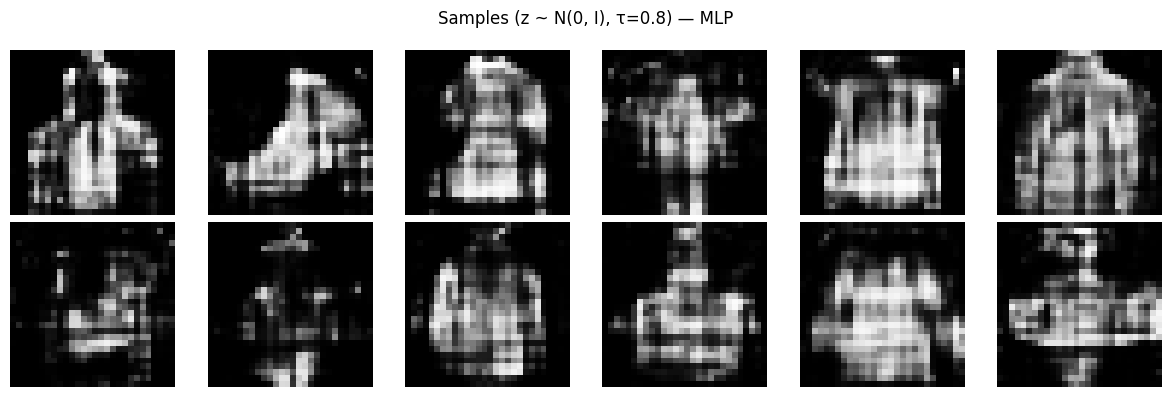

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def sample_from_decoder(model, n=16, device='cpu', temperature=1.0):
    """
    Muestra n imágenes muestreando z ~ N(0, (temperature^2) I).
    temperature < 1.0 = más conservador; >1.0 = más diverso.
    """
    model.eval()
    z = torch.randn(n, model.latent_dim, device=device) * float(temperature)
    x_gen = model.decode(z).cpu()
    return x_gen

def show_grid(tensor_imgs, ncols=4, title=None):
    n = tensor_imgs.size(0)
    nrows = int(np.ceil(n / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
    axs = np.array(axs).reshape(nrows, ncols)
    k = 0
    for r in range(nrows):
        for c in range(ncols):
            axs[r, c].axis('off')
            if k < n:
                axs[r, c].imshow(tensor_imgs[k, 0].numpy(), cmap='gray', vmin=0, vmax=1)
                k += 1
    if title:
        fig.suptitle(title)
    plt.tight_layout(); plt.show()

# === Ejemplos ===
# 1) Con tu mejor CNN 3L de MNIST
gen_model_3L_mnist = attach_encode_decode(best_model_3L)  
samples = sample_from_decoder(gen_model_3L_mnist, n=12, device=device, temperature=0.3)
show_grid(samples, ncols=6, title='Samples (z ~ N(0, I), τ=0.3) — CNN 3L MNIST')

# 2) Con tu mejor CNN 5L de MNIST
gen_model_5L_mnist = attach_encode_decode(best_model_5L)   
samples = sample_from_decoder(gen_model_5L_mnist, n=12, device=device, temperature=0.8)
show_grid(samples, ncols=6, title='Samples (z ~ N(0, I), τ=0.8) — CNN 5L MNIST')

# 3) Con tu mejor CNN 3L de FMNIST
gen_model_3L_fmnist = attach_encode_decode(best_model_fmnist_3L)   
samples = sample_from_decoder(gen_model_3L_fmnist, n=12, device=device, temperature=0.8)
show_grid(samples, ncols=6, title='Samples (z ~ N(0, I), τ=0.8) — CNN 3L FMNIST')

# 4) Con tu mejor CNN 5L de FMNIST
gen_model_5L_fmnist = attach_encode_decode(best_model_fmnist_5L)   
samples = sample_from_decoder(gen_model_5L_fmnist, n=12, device=device, temperature=0.8)
show_grid(samples, ncols=6, title='Samples (z ~ N(0, I), τ=0.8) — CNN 5L FMNIST')

# 2) Con tu mejor MLP de MNIST
gen_model_mlp_mnist = attach_encode_decode(best_model_mlp_mnist)
samples_mlp = sample_from_decoder(gen_model_mlp_mnist, n=12, device=device, temperature=0.8)
show_grid(samples_mlp, ncols=6, title='Samples (z ~ N(0, I), τ=0.8) — MLP')

# 2) Con tu mejor MLP de FMNIST
gen_model_mlp_fmnist = attach_encode_decode( best_model_mlp_fmnist)
samples_mlp = sample_from_decoder(gen_model_mlp_fmnist, n=12, device=device, temperature=0.8)
show_grid(samples_mlp, ncols=6, title='Samples (z ~ N(0, I), τ=0.8) — MLP')


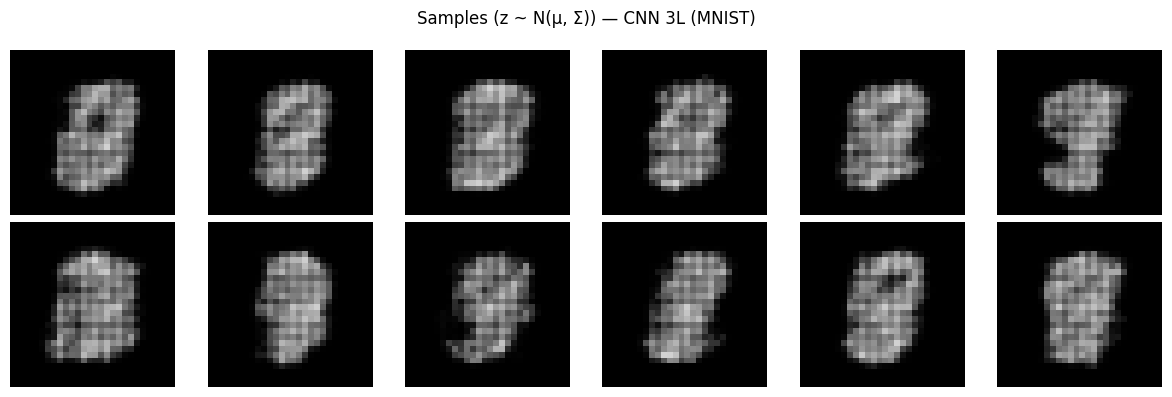

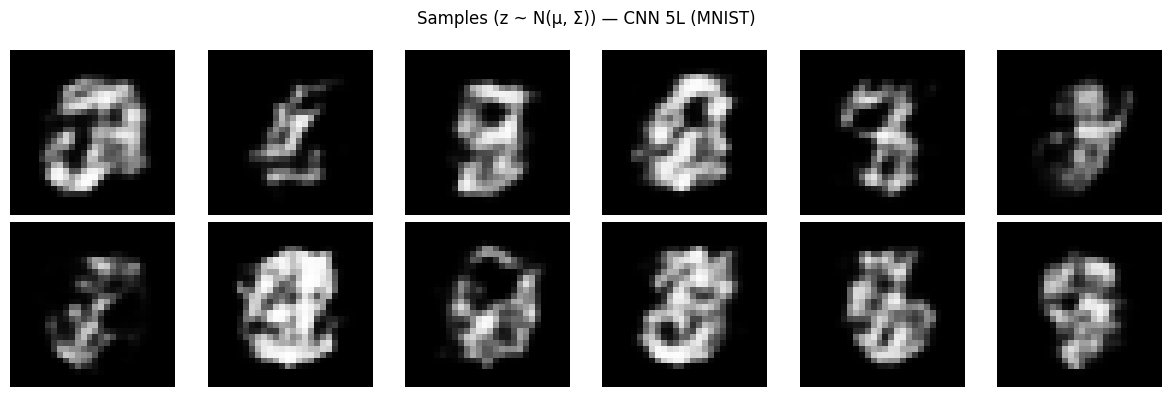

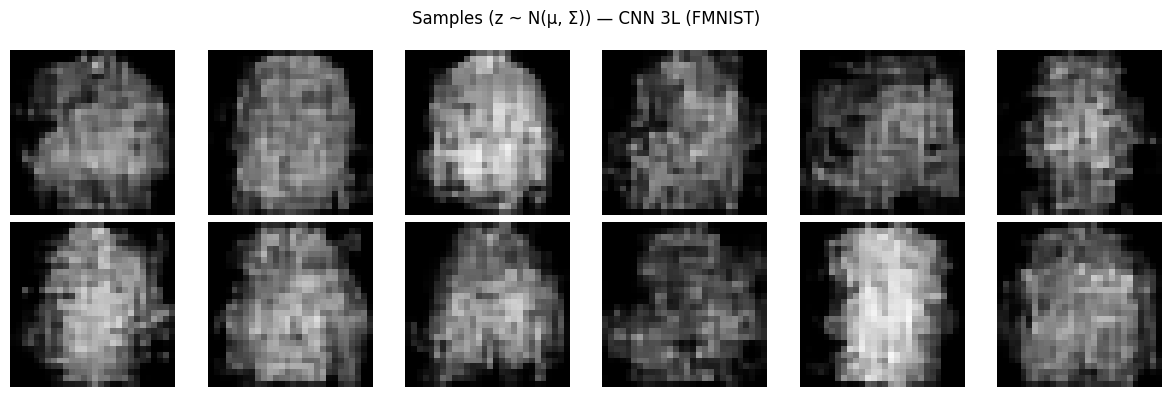

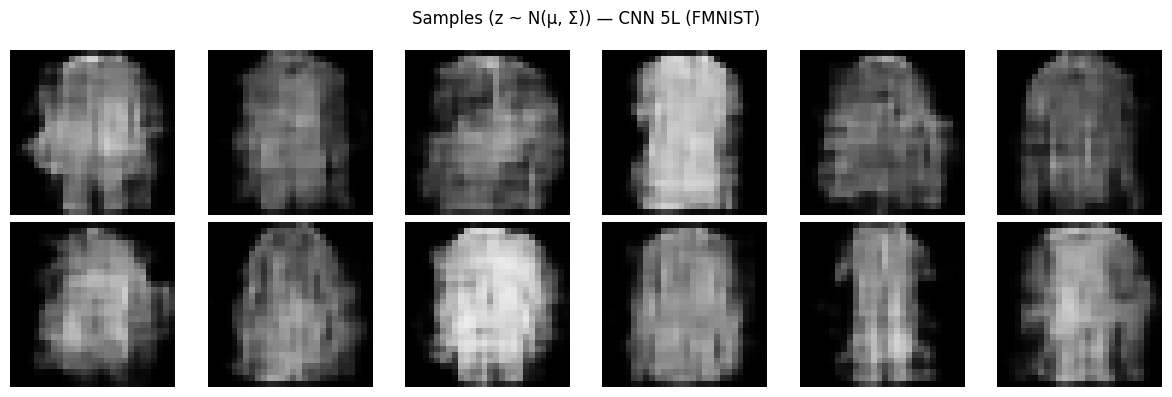

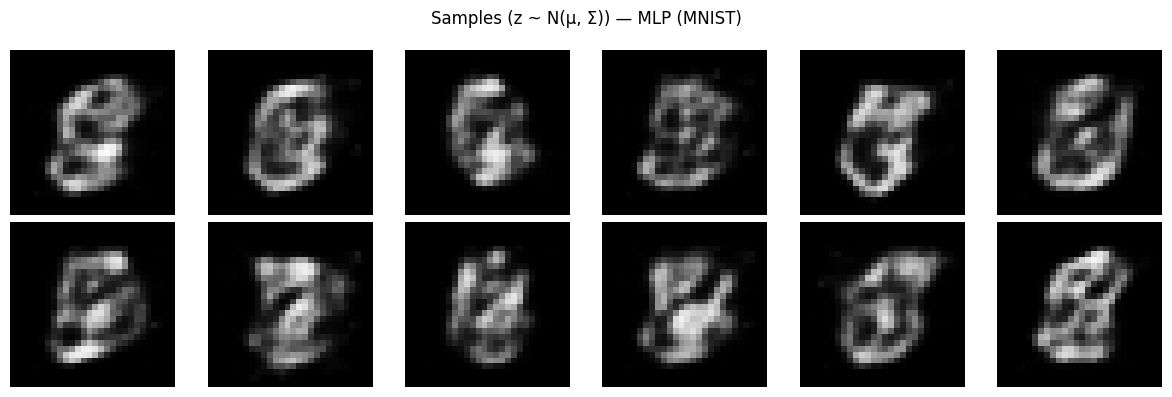

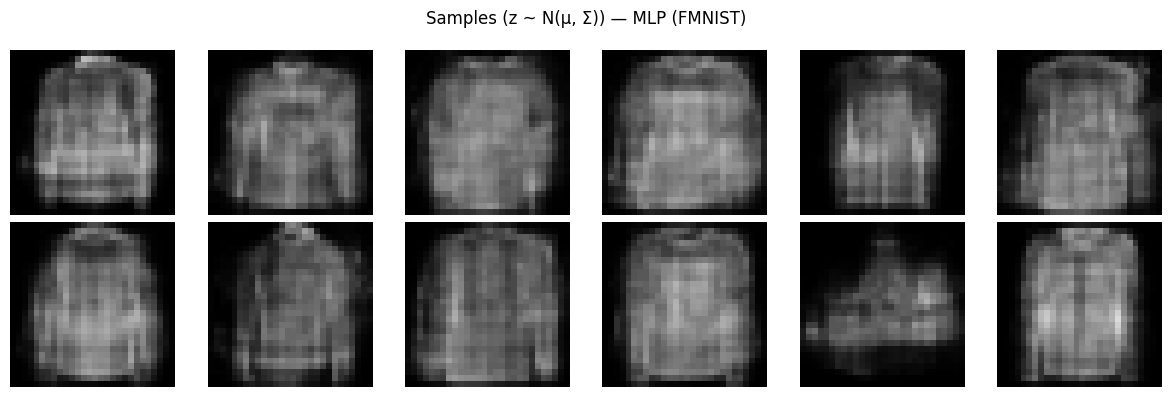

In [145]:
@torch.no_grad()
def fit_latent_gaussian(model, data_loader, max_batches=300, device='cpu'):
    """
    Pasa datos reales por el encoder y estima una gaussiana diagonal N(μ, Σ_diag)
    del espacio latente: devuelve (mu, std) de tamaño (latent_dim,).
    """
    model.eval()
    zs = []
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device)
        z = model.encode(x)
        zs.append(z.detach().cpu())
        if i + 1 >= max_batches:
            break
    Z = torch.cat(zs, dim=0)           # (N, latent_dim)
    mu = Z.mean(dim=0)
    std = Z.std(dim=0).clamp_min(1e-6) # evita degenerar
    return mu, std

@torch.no_grad()
def sample_from_fitted_gaussian(model, mu, std, n=16, device='cpu', temperature=1.0):
    """
    Muestrea z ~ N(μ, (temperature*std)^2 I) y decodifica.
    """
    model.eval()
    z = torch.randn(n, model.latent_dim, device=device) * (std.to(device) * float(temperature)) + mu.to(device)
    x_gen = model.decode(z).cpu()
    return x_gen

# === Estimar N(μ, Σ_diag) en el dataset correspondiente y muestrear ===

# 1) CNN-3L (MNIST)
gen_model_3L_mnist = attach_encode_decode(best_model_3L)
mu_3L_mnist, std_3L_mnist = fit_latent_gaussian(gen_model_3L_mnist, train_loader_mnist, max_batches=300, device=device)
samples_fit_3L_mnist = sample_from_fitted_gaussian(gen_model_3L_mnist, mu_3L_mnist, std_3L_mnist, n=12, device=device, temperature=0.3)
show_grid(samples_fit_3L_mnist, ncols=6, title='Samples (z ~ N(μ, Σ)) — CNN 3L (MNIST)')

# 2) CNN-5L (MNIST)
gen_model_5L_mnist = attach_encode_decode(best_model_5L)
mu_5L_mnist, std_5L_mnist = fit_latent_gaussian(gen_model_5L_mnist, train_loader_mnist, max_batches=300, device=device)
samples_fit_5L_mnist = sample_from_fitted_gaussian(gen_model_5L_mnist, mu_5L_mnist, std_5L_mnist, n=12, device=device, temperature=0.8)
show_grid(samples_fit_5L_mnist, ncols=6, title='Samples (z ~ N(μ, Σ)) — CNN 5L (MNIST)')

# 3) CNN-3L (FMNIST)
gen_model_3L_fmnist = attach_encode_decode(best_model_fmnist_3L)
mu_3L_fmnist, std_3L_fmnist = fit_latent_gaussian(gen_model_3L_fmnist, train_loader_fmnist, max_batches=300, device=device)
samples_fit_3L_fmnist = sample_from_fitted_gaussian(gen_model_3L_fmnist, mu_3L_fmnist, std_3L_fmnist, n=12, device=device, temperature=0.8)
show_grid(samples_fit_3L_fmnist, ncols=6, title='Samples (z ~ N(μ, Σ)) — CNN 3L (FMNIST)')

# 4) CNN-5L (FMNIST)
gen_model_5L_fmnist = attach_encode_decode(best_model_fmnist_5L)
mu_5L_fmnist, std_5L_fmnist = fit_latent_gaussian(gen_model_5L_fmnist, train_loader_fmnist, max_batches=300, device=device)
samples_fit_5L_fmnist = sample_from_fitted_gaussian(gen_model_5L_fmnist, mu_5L_fmnist, std_5L_fmnist, n=12, device=device, temperature=0.8)
show_grid(samples_fit_5L_fmnist, ncols=6, title='Samples (z ~ N(μ, Σ)) — CNN 5L (FMNIST)')

# 5) MLP (MNIST)
gen_model_mlp_mnist = attach_encode_decode(best_model_mlp_mnist)
mu_mlp_mnist, std_mlp_mnist = fit_latent_gaussian(gen_model_mlp_mnist, train_loader_mnist, max_batches=300, device=device)
samples_fit_mlp_mnist = sample_from_fitted_gaussian(gen_model_mlp_mnist, mu_mlp_mnist, std_mlp_mnist, n=12, device=device, temperature=0.8)
show_grid(samples_fit_mlp_mnist, ncols=6, title='Samples (z ~ N(μ, Σ)) — MLP (MNIST)')

# 2) MLP (FMNIST)
gen_model_mlp_fmnist = attach_encode_decode(best_model_mlp_fmnist)
mu_mlp_fmnist, std_mlp_fmnist = fit_latent_gaussian(gen_model_mlp_fmnist, train_loader_fmnist, max_batches=300, device=device)
samples_fit_mlp_fmnist = sample_from_fitted_gaussian(gen_model_mlp_fmnist, mu_mlp_fmnist, std_mlp_fmnist, n=12, device=device, temperature=0.8)
show_grid(samples_fit_mlp_fmnist, ncols=6, title='Samples (z ~ N(μ, Σ)) — MLP (FMNIST)')
